In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 831)
(4629816, 8)
validation
(621056, 831)
(621056, 8)
test
(624904, 831)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 14:05 - loss: 2.1717 - STD: 0.0562 - MAE: 0.2188

  3/463 [..............................] - ETA: 11s - loss: 2.0991 - STD: 0.0473 - MAE: 0.2171  

  5/463 [..............................] - ETA: 11s - loss: 2.0908 - STD: 0.0477 - MAE: 0.2167

  7/463 [..............................] - ETA: 11s - loss: 2.0877 - STD: 0.0473 - MAE: 0.2166

  9/463 [..............................] - ETA: 11s - loss: 2.0804 - STD: 0.0460 - MAE: 0.2165

 11/463 [..............................] - ETA: 11s - loss: 2.0742 - STD: 0.0439 - MAE: 0.2164

 13/463 [..............................] - ETA: 11s - loss: 2.0696 - STD: 0.0418 - MAE: 0.2165

 15/463 [..............................] - ETA: 11s - loss: 2.0662 - STD: 0.0404 - MAE: 0.2165

 17/463 [>.............................] - ETA: 11s - loss: 2.0630 - STD: 0.0395 - MAE: 0.2164

 19/463 [>.............................] - ETA: 11s - loss: 2.0583 - STD: 0.0388 - MAE: 0.2163

 21/463 [>.............................] - ETA: 11s - loss: 2.0530 - STD: 0.0384 - MAE: 0.2162

 24/463 [>.............................] - ETA: 11s - loss: 2.0431 - STD: 0.0389 - MAE: 0.2158

 26/463 [>.............................] - ETA: 11s - loss: 2.0354 - STD: 0.0399 - MAE: 0.2155

 28/463 [>.............................] - ETA: 11s - loss: 2.0273 - STD: 0.0414 - MAE: 0.2151

 30/463 [>.............................] - ETA: 11s - loss: 2.0180 - STD: 0.0430 - MAE: 0.2146

 33/463 [=>............................] - ETA: 11s - loss: 2.0044 - STD: 0.0453 - MAE: 0.2140

 35/463 [=>............................] - ETA: 10s - loss: 1.9955 - STD: 0.0469 - MAE: 0.2136

 37/463 [=>............................] - ETA: 10s - loss: 1.9870 - STD: 0.0485 - MAE: 0.2131

 39/463 [=>............................] - ETA: 10s - loss: 1.9784 - STD: 0.0500 - MAE: 0.2127

 41/463 [=>............................] - ETA: 10s - loss: 1.9696 - STD: 0.0515 - MAE: 0.2122

 43/463 [=>............................] - ETA: 10s - loss: 1.9615 - STD: 0.0529 - MAE: 0.2118

 45/463 [=>............................] - ETA: 10s - loss: 1.9533 - STD: 0.0542 - MAE: 0.2114

 47/463 [==>...........................] - ETA: 10s - loss: 1.9445 - STD: 0.0555 - MAE: 0.2110

 49/463 [==>...........................] - ETA: 10s - loss: 1.9359 - STD: 0.0567 - MAE: 0.2106

 51/463 [==>...........................] - ETA: 10s - loss: 1.9269 - STD: 0.0579 - MAE: 0.2101

 53/463 [==>...........................] - ETA: 10s - loss: 1.9175 - STD: 0.0592 - MAE: 0.2097

 55/463 [==>...........................] - ETA: 10s - loss: 1.9077 - STD: 0.0604 - MAE: 0.2092

 57/463 [==>...........................] - ETA: 10s - loss: 1.8974 - STD: 0.0617 - MAE: 0.2087

 59/463 [==>...........................] - ETA: 10s - loss: 1.8870 - STD: 0.0631 - MAE: 0.2081

 61/463 [==>...........................] - ETA: 10s - loss: 1.8762 - STD: 0.0646 - MAE: 0.2075

 63/463 [===>..........................] - ETA: 10s - loss: 1.8657 - STD: 0.0662 - MAE: 0.2069

 65/463 [===>..........................] - ETA: 10s - loss: 1.8550 - STD: 0.0678 - MAE: 0.2062

 67/463 [===>..........................] - ETA: 10s - loss: 1.8447 - STD: 0.0694 - MAE: 0.2056

 69/463 [===>..........................] - ETA: 10s - loss: 1.8346 - STD: 0.0709 - MAE: 0.2050

 71/463 [===>..........................] - ETA: 10s - loss: 1.8250 - STD: 0.0726 - MAE: 0.2043

 73/463 [===>..........................] - ETA: 10s - loss: 1.8148 - STD: 0.0742 - MAE: 0.2037

 75/463 [===>..........................] - ETA: 10s - loss: 1.8053 - STD: 0.0757 - MAE: 0.2030

 77/463 [===>..........................] - ETA: 9s - loss: 1.7957 - STD: 0.0773 - MAE: 0.2024 

 79/463 [====>.........................] - ETA: 9s - loss: 1.7867 - STD: 0.0788 - MAE: 0.2018

 81/463 [====>.........................] - ETA: 9s - loss: 1.7779 - STD: 0.0803 - MAE: 0.2012

 83/463 [====>.........................] - ETA: 9s - loss: 1.7690 - STD: 0.0817 - MAE: 0.2006

 85/463 [====>.........................] - ETA: 9s - loss: 1.7604 - STD: 0.0832 - MAE: 0.2000

 87/463 [====>.........................] - ETA: 9s - loss: 1.7521 - STD: 0.0846 - MAE: 0.1994

 89/463 [====>.........................] - ETA: 9s - loss: 1.7438 - STD: 0.0859 - MAE: 0.1988

 91/463 [====>.........................] - ETA: 9s - loss: 1.7359 - STD: 0.0872 - MAE: 0.1982

 93/463 [=====>........................] - ETA: 9s - loss: 1.7281 - STD: 0.0885 - MAE: 0.1977

 95/463 [=====>........................] - ETA: 9s - loss: 1.7202 - STD: 0.0898 - MAE: 0.1971

 97/463 [=====>........................] - ETA: 9s - loss: 1.7130 - STD: 0.0910 - MAE: 0.1966

 99/463 [=====>........................] - ETA: 9s - loss: 1.7059 - STD: 0.0922 - MAE: 0.1961

101/463 [=====>........................] - ETA: 9s - loss: 1.6990 - STD: 0.0934 - MAE: 0.1955

104/463 [=====>........................] - ETA: 9s - loss: 1.6887 - STD: 0.0951 - MAE: 0.1948

106/463 [=====>........................] - ETA: 9s - loss: 1.6820 - STD: 0.0962 - MAE: 0.1943

108/463 [=====>........................] - ETA: 9s - loss: 1.6756 - STD: 0.0973 - MAE: 0.1938

110/463 [======>.......................] - ETA: 9s - loss: 1.6692 - STD: 0.0984 - MAE: 0.1933

113/463 [======>.......................] - ETA: 9s - loss: 1.6599 - STD: 0.1000 - MAE: 0.1926

115/463 [======>.......................] - ETA: 9s - loss: 1.6539 - STD: 0.1010 - MAE: 0.1922

117/463 [======>.......................] - ETA: 8s - loss: 1.6481 - STD: 0.1020 - MAE: 0.1917

119/463 [======>.......................] - ETA: 8s - loss: 1.6423 - STD: 0.1029 - MAE: 0.1912

121/463 [======>.......................] - ETA: 8s - loss: 1.6367 - STD: 0.1039 - MAE: 0.1908

123/463 [======>.......................] - ETA: 8s - loss: 1.6311 - STD: 0.1048 - MAE: 0.1904

125/463 [=======>......................] - ETA: 8s - loss: 1.6258 - STD: 0.1057 - MAE: 0.1900

127/463 [=======>......................] - ETA: 8s - loss: 1.6207 - STD: 0.1066 - MAE: 0.1896

129/463 [=======>......................] - ETA: 8s - loss: 1.6155 - STD: 0.1074 - MAE: 0.1892

131/463 [=======>......................] - ETA: 8s - loss: 1.6106 - STD: 0.1083 - MAE: 0.1888

133/463 [=======>......................] - ETA: 8s - loss: 1.6058 - STD: 0.1091 - MAE: 0.1884

135/463 [=======>......................] - ETA: 8s - loss: 1.6011 - STD: 0.1099 - MAE: 0.1880

137/463 [=======>......................] - ETA: 8s - loss: 1.5963 - STD: 0.1107 - MAE: 0.1876

139/463 [========>.....................] - ETA: 8s - loss: 1.5917 - STD: 0.1115 - MAE: 0.1873

141/463 [========>.....................] - ETA: 8s - loss: 1.5872 - STD: 0.1122 - MAE: 0.1869

143/463 [========>.....................] - ETA: 8s - loss: 1.5827 - STD: 0.1129 - MAE: 0.1866

145/463 [========>.....................] - ETA: 8s - loss: 1.5783 - STD: 0.1137 - MAE: 0.1862

147/463 [========>.....................] - ETA: 8s - loss: 1.5741 - STD: 0.1144 - MAE: 0.1859

149/463 [========>.....................] - ETA: 8s - loss: 1.5700 - STD: 0.1151 - MAE: 0.1855

151/463 [========>.....................] - ETA: 8s - loss: 1.5659 - STD: 0.1157 - MAE: 0.1852

153/463 [========>.....................] - ETA: 8s - loss: 1.5618 - STD: 0.1164 - MAE: 0.1849

155/463 [=========>....................] - ETA: 7s - loss: 1.5578 - STD: 0.1171 - MAE: 0.1846

157/463 [=========>....................] - ETA: 7s - loss: 1.5539 - STD: 0.1177 - MAE: 0.1842

159/463 [=========>....................] - ETA: 7s - loss: 1.5501 - STD: 0.1184 - MAE: 0.1839

161/463 [=========>....................] - ETA: 7s - loss: 1.5462 - STD: 0.1190 - MAE: 0.1836

163/463 [=========>....................] - ETA: 7s - loss: 1.5426 - STD: 0.1196 - MAE: 0.1833

165/463 [=========>....................] - ETA: 7s - loss: 1.5389 - STD: 0.1202 - MAE: 0.1830

167/463 [=========>....................] - ETA: 7s - loss: 1.5354 - STD: 0.1208 - MAE: 0.1827

169/463 [=========>....................] - ETA: 7s - loss: 1.5319 - STD: 0.1214 - MAE: 0.1824

172/463 [==========>...................] - ETA: 7s - loss: 1.5267 - STD: 0.1223 - MAE: 0.1820

174/463 [==========>...................] - ETA: 7s - loss: 1.5233 - STD: 0.1228 - MAE: 0.1817

176/463 [==========>...................] - ETA: 7s - loss: 1.5202 - STD: 0.1234 - MAE: 0.1815

178/463 [==========>...................] - ETA: 7s - loss: 1.5169 - STD: 0.1239 - MAE: 0.1812

180/463 [==========>...................] - ETA: 7s - loss: 1.5137 - STD: 0.1245 - MAE: 0.1809

182/463 [==========>...................] - ETA: 7s - loss: 1.5106 - STD: 0.1250 - MAE: 0.1806

185/463 [==========>...................] - ETA: 7s - loss: 1.5061 - STD: 0.1258 - MAE: 0.1803

187/463 [===========>..................] - ETA: 7s - loss: 1.5030 - STD: 0.1263 - MAE: 0.1800

189/463 [===========>..................] - ETA: 7s - loss: 1.5000 - STD: 0.1268 - MAE: 0.1798

191/463 [===========>..................] - ETA: 7s - loss: 1.4970 - STD: 0.1273 - MAE: 0.1795

194/463 [===========>..................] - ETA: 6s - loss: 1.4926 - STD: 0.1280 - MAE: 0.1791

197/463 [===========>..................] - ETA: 6s - loss: 1.4883 - STD: 0.1287 - MAE: 0.1788

199/463 [===========>..................] - ETA: 6s - loss: 1.4857 - STD: 0.1292 - MAE: 0.1785

201/463 [============>.................] - ETA: 6s - loss: 1.4830 - STD: 0.1296 - MAE: 0.1783

203/463 [============>.................] - ETA: 6s - loss: 1.4801 - STD: 0.1301 - MAE: 0.1781

205/463 [============>.................] - ETA: 6s - loss: 1.4774 - STD: 0.1305 - MAE: 0.1778

207/463 [============>.................] - ETA: 6s - loss: 1.4747 - STD: 0.1310 - MAE: 0.1776

209/463 [============>.................] - ETA: 6s - loss: 1.4721 - STD: 0.1314 - MAE: 0.1774

211/463 [============>.................] - ETA: 6s - loss: 1.4695 - STD: 0.1319 - MAE: 0.1772

213/463 [============>.................] - ETA: 6s - loss: 1.4670 - STD: 0.1323 - MAE: 0.1769

215/463 [============>.................] - ETA: 6s - loss: 1.4645 - STD: 0.1327 - MAE: 0.1767

217/463 [=============>................] - ETA: 6s - loss: 1.4619 - STD: 0.1331 - MAE: 0.1765

219/463 [=============>................] - ETA: 6s - loss: 1.4595 - STD: 0.1335 - MAE: 0.1763

221/463 [=============>................] - ETA: 6s - loss: 1.4570 - STD: 0.1339 - MAE: 0.1761

223/463 [=============>................] - ETA: 6s - loss: 1.4546 - STD: 0.1343 - MAE: 0.1759

225/463 [=============>................] - ETA: 6s - loss: 1.4522 - STD: 0.1347 - MAE: 0.1757

227/463 [=============>................] - ETA: 6s - loss: 1.4498 - STD: 0.1351 - MAE: 0.1755

229/463 [=============>................] - ETA: 6s - loss: 1.4475 - STD: 0.1355 - MAE: 0.1753

231/463 [=============>................] - ETA: 6s - loss: 1.4452 - STD: 0.1359 - MAE: 0.1751

233/463 [==============>...............] - ETA: 5s - loss: 1.4430 - STD: 0.1363 - MAE: 0.1749

235/463 [==============>...............] - ETA: 6s - loss: 1.4408 - STD: 0.1366 - MAE: 0.1747

238/463 [==============>...............] - ETA: 6s - loss: 1.4376 - STD: 0.1372 - MAE: 0.1744

241/463 [==============>...............] - ETA: 6s - loss: 1.4343 - STD: 0.1377 - MAE: 0.1741

244/463 [==============>...............] - ETA: 6s - loss: 1.4312 - STD: 0.1383 - MAE: 0.1738

247/463 [===============>..............] - ETA: 6s - loss: 1.4280 - STD: 0.1388 - MAE: 0.1735

250/463 [===============>..............] - ETA: 6s - loss: 1.4249 - STD: 0.1393 - MAE: 0.1733

253/463 [===============>..............] - ETA: 6s - loss: 1.4219 - STD: 0.1398 - MAE: 0.1730

256/463 [===============>..............] - ETA: 6s - loss: 1.4189 - STD: 0.1403 - MAE: 0.1727

259/463 [===============>..............] - ETA: 6s - loss: 1.4159 - STD: 0.1408 - MAE: 0.1725

262/463 [===============>..............] - ETA: 6s - loss: 1.4131 - STD: 0.1413 - MAE: 0.1722

265/463 [================>.............] - ETA: 5s - loss: 1.4103 - STD: 0.1417 - MAE: 0.1719

268/463 [================>.............] - ETA: 5s - loss: 1.4075 - STD: 0.1422 - MAE: 0.1717

271/463 [================>.............] - ETA: 5s - loss: 1.4048 - STD: 0.1427 - MAE: 0.1714

274/463 [================>.............] - ETA: 5s - loss: 1.4021 - STD: 0.1431 - MAE: 0.1712

277/463 [================>.............] - ETA: 5s - loss: 1.3993 - STD: 0.1436 - MAE: 0.1709

280/463 [=================>............] - ETA: 5s - loss: 1.3971 - STD: 0.1440 - MAE: 0.1707

283/463 [=================>............] - ETA: 5s - loss: 1.3948 - STD: 0.1445 - MAE: 0.1705

286/463 [=================>............] - ETA: 5s - loss: 1.3928 - STD: 0.1449 - MAE: 0.1703

289/463 [=================>............] - ETA: 5s - loss: 1.3906 - STD: 0.1453 - MAE: 0.1701

292/463 [=================>............] - ETA: 4s - loss: 1.3884 - STD: 0.1457 - MAE: 0.1699

295/463 [==================>...........] - ETA: 4s - loss: 1.3861 - STD: 0.1461 - MAE: 0.1697

298/463 [==================>...........] - ETA: 4s - loss: 1.3838 - STD: 0.1464 - MAE: 0.1695

301/463 [==================>...........] - ETA: 4s - loss: 1.3815 - STD: 0.1468 - MAE: 0.1693

304/463 [==================>...........] - ETA: 4s - loss: 1.3791 - STD: 0.1472 - MAE: 0.1691

307/463 [==================>...........] - ETA: 4s - loss: 1.3767 - STD: 0.1476 - MAE: 0.1688

310/463 [===================>..........] - ETA: 4s - loss: 1.3743 - STD: 0.1480 - MAE: 0.1686

313/463 [===================>..........] - ETA: 4s - loss: 1.3720 - STD: 0.1484 - MAE: 0.1684

316/463 [===================>..........] - ETA: 4s - loss: 1.3697 - STD: 0.1488 - MAE: 0.1682

319/463 [===================>..........] - ETA: 4s - loss: 1.3676 - STD: 0.1491 - MAE: 0.1680

322/463 [===================>..........] - ETA: 4s - loss: 1.3653 - STD: 0.1495 - MAE: 0.1678

325/463 [====================>.........] - ETA: 3s - loss: 1.3631 - STD: 0.1499 - MAE: 0.1676

328/463 [====================>.........] - ETA: 3s - loss: 1.3609 - STD: 0.1502 - MAE: 0.1674

331/463 [====================>.........] - ETA: 3s - loss: 1.3587 - STD: 0.1506 - MAE: 0.1672

334/463 [====================>.........] - ETA: 3s - loss: 1.3566 - STD: 0.1509 - MAE: 0.1670

337/463 [====================>.........] - ETA: 3s - loss: 1.3545 - STD: 0.1513 - MAE: 0.1668

340/463 [=====================>........] - ETA: 3s - loss: 1.3524 - STD: 0.1516 - MAE: 0.1666

343/463 [=====================>........] - ETA: 3s - loss: 1.3503 - STD: 0.1519 - MAE: 0.1664

346/463 [=====================>........] - ETA: 3s - loss: 1.3483 - STD: 0.1523 - MAE: 0.1662

349/463 [=====================>........] - ETA: 3s - loss: 1.3463 - STD: 0.1526 - MAE: 0.1660

352/463 [=====================>........] - ETA: 3s - loss: 1.3442 - STD: 0.1529 - MAE: 0.1658

355/463 [======================>.......] - ETA: 3s - loss: 1.3423 - STD: 0.1532 - MAE: 0.1656

358/463 [======================>.......] - ETA: 2s - loss: 1.3403 - STD: 0.1536 - MAE: 0.1655

361/463 [======================>.......] - ETA: 2s - loss: 1.3384 - STD: 0.1539 - MAE: 0.1653

364/463 [======================>.......] - ETA: 2s - loss: 1.3366 - STD: 0.1542 - MAE: 0.1651

367/463 [======================>.......] - ETA: 2s - loss: 1.3347 - STD: 0.1545 - MAE: 0.1649

370/463 [======================>.......] - ETA: 2s - loss: 1.3330 - STD: 0.1548 - MAE: 0.1648

373/463 [=======================>......] - ETA: 2s - loss: 1.3311 - STD: 0.1551 - MAE: 0.1646

376/463 [=======================>......] - ETA: 2s - loss: 1.3292 - STD: 0.1554 - MAE: 0.1644

379/463 [=======================>......] - ETA: 2s - loss: 1.3275 - STD: 0.1557 - MAE: 0.1642

382/463 [=======================>......] - ETA: 2s - loss: 1.3257 - STD: 0.1560 - MAE: 0.1641

385/463 [=======================>......] - ETA: 2s - loss: 1.3239 - STD: 0.1563 - MAE: 0.1639

388/463 [========================>.....] - ETA: 2s - loss: 1.3223 - STD: 0.1565 - MAE: 0.1637

391/463 [========================>.....] - ETA: 1s - loss: 1.3206 - STD: 0.1568 - MAE: 0.1636

394/463 [========================>.....] - ETA: 1s - loss: 1.3189 - STD: 0.1571 - MAE: 0.1634

397/463 [========================>.....] - ETA: 1s - loss: 1.3172 - STD: 0.1574 - MAE: 0.1633

400/463 [========================>.....] - ETA: 1s - loss: 1.3156 - STD: 0.1576 - MAE: 0.1631

403/463 [=========================>....] - ETA: 1s - loss: 1.3139 - STD: 0.1579 - MAE: 0.1629

406/463 [=========================>....] - ETA: 1s - loss: 1.3123 - STD: 0.1582 - MAE: 0.1628

409/463 [=========================>....] - ETA: 1s - loss: 1.3106 - STD: 0.1584 - MAE: 0.1626

412/463 [=========================>....] - ETA: 1s - loss: 1.3089 - STD: 0.1587 - MAE: 0.1625

415/463 [=========================>....] - ETA: 1s - loss: 1.3074 - STD: 0.1590 - MAE: 0.1623

418/463 [==========================>...] - ETA: 1s - loss: 1.3057 - STD: 0.1592 - MAE: 0.1622

421/463 [==========================>...] - ETA: 1s - loss: 1.3041 - STD: 0.1595 - MAE: 0.1620

424/463 [==========================>...] - ETA: 1s - loss: 1.3026 - STD: 0.1597 - MAE: 0.1619

427/463 [==========================>...] - ETA: 0s - loss: 1.3011 - STD: 0.1600 - MAE: 0.1617

430/463 [==========================>...] - ETA: 0s - loss: 1.2998 - STD: 0.1602 - MAE: 0.1616

433/463 [===========================>..] - ETA: 0s - loss: 1.2982 - STD: 0.1605 - MAE: 0.1614

436/463 [===========================>..] - ETA: 0s - loss: 1.2968 - STD: 0.1607 - MAE: 0.1613

439/463 [===========================>..] - ETA: 0s - loss: 1.2954 - STD: 0.1610 - MAE: 0.1611

442/463 [===========================>..] - ETA: 0s - loss: 1.2938 - STD: 0.1612 - MAE: 0.1610

445/463 [===========================>..] - ETA: 0s - loss: 1.2924 - STD: 0.1614 - MAE: 0.1609

448/463 [============================>.] - ETA: 0s - loss: 1.2910 - STD: 0.1617 - MAE: 0.1607

451/463 [============================>.] - ETA: 0s - loss: 1.2896 - STD: 0.1619 - MAE: 0.1606

454/463 [============================>.] - ETA: 0s - loss: 1.2882 - STD: 0.1621 - MAE: 0.1605

457/463 [============================>.] - ETA: 0s - loss: 1.2868 - STD: 0.1624 - MAE: 0.1603

460/463 [============================>.] - ETA: 0s - loss: 1.2854 - STD: 0.1626 - MAE: 0.1602

463/463 [==============================] - ETA: 0s - loss: 1.2840 - STD: 0.1628 - MAE: 0.1600

463/463 [==============================] - 16s 30ms/step - loss: 1.2840 - STD: 0.1628 - MAE: 0.1600 - val_loss: 1.2009 - val_STD: 0.1917 - val_MAE: 0.1478


Epoch 2/10000


  1/463 [..............................] - ETA: 23s - loss: 1.0714 - STD: 0.1967 - MAE: 0.1394

  3/463 [..............................] - ETA: 11s - loss: 1.0617 - STD: 0.1966 - MAE: 0.1391

  6/463 [..............................] - ETA: 10s - loss: 1.0657 - STD: 0.1968 - MAE: 0.1393

  9/463 [..............................] - ETA: 10s - loss: 1.0676 - STD: 0.1973 - MAE: 0.1391

 12/463 [..............................] - ETA: 10s - loss: 1.0658 - STD: 0.1975 - MAE: 0.1389

 15/463 [..............................] - ETA: 10s - loss: 1.0635 - STD: 0.1975 - MAE: 0.1388

 18/463 [>.............................] - ETA: 10s - loss: 1.0641 - STD: 0.1975 - MAE: 0.1388

 21/463 [>.............................] - ETA: 10s - loss: 1.0652 - STD: 0.1976 - MAE: 0.1389

 24/463 [>.............................] - ETA: 10s - loss: 1.0653 - STD: 0.1977 - MAE: 0.1388

 27/463 [>.............................] - ETA: 9s - loss: 1.0645 - STD: 0.1978 - MAE: 0.1388 

 30/463 [>.............................] - ETA: 9s - loss: 1.0648 - STD: 0.1978 - MAE: 0.1387

 33/463 [=>............................] - ETA: 9s - loss: 1.0653 - STD: 0.1980 - MAE: 0.1387

 36/463 [=>............................] - ETA: 9s - loss: 1.0648 - STD: 0.1981 - MAE: 0.1386

 39/463 [=>............................] - ETA: 9s - loss: 1.0639 - STD: 0.1982 - MAE: 0.1386

 42/463 [=>............................] - ETA: 9s - loss: 1.0633 - STD: 0.1982 - MAE: 0.1385

 45/463 [=>............................] - ETA: 9s - loss: 1.0627 - STD: 0.1982 - MAE: 0.1385

 48/463 [==>...........................] - ETA: 9s - loss: 1.0620 - STD: 0.1983 - MAE: 0.1384

 51/463 [==>...........................] - ETA: 9s - loss: 1.0615 - STD: 0.1984 - MAE: 0.1384

 54/463 [==>...........................] - ETA: 9s - loss: 1.0613 - STD: 0.1985 - MAE: 0.1383

 57/463 [==>...........................] - ETA: 9s - loss: 1.0609 - STD: 0.1986 - MAE: 0.1383

 60/463 [==>...........................] - ETA: 9s - loss: 1.0606 - STD: 0.1986 - MAE: 0.1382

 63/463 [===>..........................] - ETA: 9s - loss: 1.0608 - STD: 0.1987 - MAE: 0.1382

 66/463 [===>..........................] - ETA: 9s - loss: 1.0622 - STD: 0.1988 - MAE: 0.1382

 69/463 [===>..........................] - ETA: 8s - loss: 1.0619 - STD: 0.1988 - MAE: 0.1382

 72/463 [===>..........................] - ETA: 8s - loss: 1.0617 - STD: 0.1989 - MAE: 0.1382

 75/463 [===>..........................] - ETA: 8s - loss: 1.0614 - STD: 0.1989 - MAE: 0.1382

 78/463 [====>.........................] - ETA: 8s - loss: 1.0613 - STD: 0.1990 - MAE: 0.1381

 81/463 [====>.........................] - ETA: 8s - loss: 1.0607 - STD: 0.1990 - MAE: 0.1381

 84/463 [====>.........................] - ETA: 8s - loss: 1.0600 - STD: 0.1990 - MAE: 0.1380

 87/463 [====>.........................] - ETA: 8s - loss: 1.0597 - STD: 0.1991 - MAE: 0.1380

 90/463 [====>.........................] - ETA: 8s - loss: 1.0592 - STD: 0.1992 - MAE: 0.1379

 93/463 [=====>........................] - ETA: 8s - loss: 1.0589 - STD: 0.1992 - MAE: 0.1379

 96/463 [=====>........................] - ETA: 8s - loss: 1.0584 - STD: 0.1992 - MAE: 0.1379

 99/463 [=====>........................] - ETA: 8s - loss: 1.0580 - STD: 0.1993 - MAE: 0.1378

102/463 [=====>........................] - ETA: 8s - loss: 1.0574 - STD: 0.1993 - MAE: 0.1378

105/463 [=====>........................] - ETA: 8s - loss: 1.0571 - STD: 0.1994 - MAE: 0.1377

108/463 [=====>........................] - ETA: 8s - loss: 1.0565 - STD: 0.1995 - MAE: 0.1377

111/463 [======>.......................] - ETA: 7s - loss: 1.0558 - STD: 0.1995 - MAE: 0.1376

114/463 [======>.......................] - ETA: 7s - loss: 1.0553 - STD: 0.1996 - MAE: 0.1375

117/463 [======>.......................] - ETA: 7s - loss: 1.0553 - STD: 0.1996 - MAE: 0.1375

120/463 [======>.......................] - ETA: 7s - loss: 1.0561 - STD: 0.1997 - MAE: 0.1375

123/463 [======>.......................] - ETA: 7s - loss: 1.0559 - STD: 0.1998 - MAE: 0.1375

126/463 [=======>......................] - ETA: 7s - loss: 1.0565 - STD: 0.1998 - MAE: 0.1375

129/463 [=======>......................] - ETA: 7s - loss: 1.0564 - STD: 0.1998 - MAE: 0.1375

132/463 [=======>......................] - ETA: 7s - loss: 1.0564 - STD: 0.1998 - MAE: 0.1375

135/463 [=======>......................] - ETA: 7s - loss: 1.0558 - STD: 0.1999 - MAE: 0.1375

138/463 [=======>......................] - ETA: 7s - loss: 1.0555 - STD: 0.2000 - MAE: 0.1374

141/463 [========>.....................] - ETA: 7s - loss: 1.0550 - STD: 0.2000 - MAE: 0.1374

144/463 [========>.....................] - ETA: 7s - loss: 1.0546 - STD: 0.2001 - MAE: 0.1373

147/463 [========>.....................] - ETA: 7s - loss: 1.0543 - STD: 0.2001 - MAE: 0.1373

150/463 [========>.....................] - ETA: 7s - loss: 1.0540 - STD: 0.2002 - MAE: 0.1373

153/463 [========>.....................] - ETA: 7s - loss: 1.0534 - STD: 0.2002 - MAE: 0.1372

156/463 [=========>....................] - ETA: 6s - loss: 1.0531 - STD: 0.2003 - MAE: 0.1372

159/463 [=========>....................] - ETA: 6s - loss: 1.0525 - STD: 0.2003 - MAE: 0.1371

162/463 [=========>....................] - ETA: 6s - loss: 1.0519 - STD: 0.2004 - MAE: 0.1371

165/463 [=========>....................] - ETA: 6s - loss: 1.0514 - STD: 0.2004 - MAE: 0.1370

168/463 [=========>....................] - ETA: 6s - loss: 1.0509 - STD: 0.2005 - MAE: 0.1370

171/463 [==========>...................] - ETA: 6s - loss: 1.0504 - STD: 0.2006 - MAE: 0.1369

174/463 [==========>...................] - ETA: 6s - loss: 1.0500 - STD: 0.2006 - MAE: 0.1369

177/463 [==========>...................] - ETA: 6s - loss: 1.0493 - STD: 0.2007 - MAE: 0.1368

180/463 [==========>...................] - ETA: 6s - loss: 1.0488 - STD: 0.2007 - MAE: 0.1367

183/463 [==========>...................] - ETA: 6s - loss: 1.0483 - STD: 0.2008 - MAE: 0.1367

186/463 [===========>..................] - ETA: 6s - loss: 1.0478 - STD: 0.2008 - MAE: 0.1367

189/463 [===========>..................] - ETA: 6s - loss: 1.0473 - STD: 0.2009 - MAE: 0.1366

192/463 [===========>..................] - ETA: 6s - loss: 1.0470 - STD: 0.2009 - MAE: 0.1366

195/463 [===========>..................] - ETA: 6s - loss: 1.0475 - STD: 0.2010 - MAE: 0.1366

198/463 [===========>..................] - ETA: 6s - loss: 1.0475 - STD: 0.2010 - MAE: 0.1366

201/463 [============>.................] - ETA: 5s - loss: 1.0472 - STD: 0.2010 - MAE: 0.1365

204/463 [============>.................] - ETA: 5s - loss: 1.0471 - STD: 0.2011 - MAE: 0.1365

207/463 [============>.................] - ETA: 5s - loss: 1.0471 - STD: 0.2011 - MAE: 0.1365

210/463 [============>.................] - ETA: 5s - loss: 1.0468 - STD: 0.2012 - MAE: 0.1365

213/463 [============>.................] - ETA: 5s - loss: 1.0464 - STD: 0.2012 - MAE: 0.1364

216/463 [============>.................] - ETA: 5s - loss: 1.0462 - STD: 0.2013 - MAE: 0.1364

219/463 [=============>................] - ETA: 5s - loss: 1.0457 - STD: 0.2013 - MAE: 0.1364

222/463 [=============>................] - ETA: 5s - loss: 1.0452 - STD: 0.2013 - MAE: 0.1363

225/463 [=============>................] - ETA: 5s - loss: 1.0447 - STD: 0.2014 - MAE: 0.1363

228/463 [=============>................] - ETA: 5s - loss: 1.0441 - STD: 0.2014 - MAE: 0.1362

231/463 [=============>................] - ETA: 5s - loss: 1.0438 - STD: 0.2015 - MAE: 0.1362

234/463 [==============>...............] - ETA: 5s - loss: 1.0435 - STD: 0.2015 - MAE: 0.1361

237/463 [==============>...............] - ETA: 5s - loss: 1.0431 - STD: 0.2016 - MAE: 0.1361

240/463 [==============>...............] - ETA: 5s - loss: 1.0428 - STD: 0.2016 - MAE: 0.1360

243/463 [==============>...............] - ETA: 4s - loss: 1.0424 - STD: 0.2017 - MAE: 0.1360

246/463 [==============>...............] - ETA: 4s - loss: 1.0420 - STD: 0.2017 - MAE: 0.1360

249/463 [===============>..............] - ETA: 4s - loss: 1.0416 - STD: 0.2018 - MAE: 0.1359

252/463 [===============>..............] - ETA: 4s - loss: 1.0411 - STD: 0.2018 - MAE: 0.1359

255/463 [===============>..............] - ETA: 4s - loss: 1.0409 - STD: 0.2019 - MAE: 0.1358

258/463 [===============>..............] - ETA: 4s - loss: 1.0406 - STD: 0.2019 - MAE: 0.1358

261/463 [===============>..............] - ETA: 4s - loss: 1.0403 - STD: 0.2020 - MAE: 0.1358

264/463 [================>.............] - ETA: 4s - loss: 1.0400 - STD: 0.2020 - MAE: 0.1357

267/463 [================>.............] - ETA: 4s - loss: 1.0397 - STD: 0.2021 - MAE: 0.1357

270/463 [================>.............] - ETA: 4s - loss: 1.0399 - STD: 0.2021 - MAE: 0.1357

273/463 [================>.............] - ETA: 4s - loss: 1.0398 - STD: 0.2021 - MAE: 0.1357

276/463 [================>.............] - ETA: 4s - loss: 1.0398 - STD: 0.2022 - MAE: 0.1357

279/463 [=================>............] - ETA: 4s - loss: 1.0396 - STD: 0.2022 - MAE: 0.1356

282/463 [=================>............] - ETA: 4s - loss: 1.0393 - STD: 0.2022 - MAE: 0.1356

285/463 [=================>............] - ETA: 4s - loss: 1.0390 - STD: 0.2023 - MAE: 0.1356

288/463 [=================>............] - ETA: 3s - loss: 1.0386 - STD: 0.2023 - MAE: 0.1355

291/463 [=================>............] - ETA: 3s - loss: 1.0383 - STD: 0.2024 - MAE: 0.1355

294/463 [==================>...........] - ETA: 3s - loss: 1.0380 - STD: 0.2024 - MAE: 0.1355

297/463 [==================>...........] - ETA: 3s - loss: 1.0376 - STD: 0.2024 - MAE: 0.1354

300/463 [==================>...........] - ETA: 3s - loss: 1.0373 - STD: 0.2025 - MAE: 0.1354

303/463 [==================>...........] - ETA: 3s - loss: 1.0369 - STD: 0.2025 - MAE: 0.1354

306/463 [==================>...........] - ETA: 3s - loss: 1.0365 - STD: 0.2026 - MAE: 0.1353

309/463 [===================>..........] - ETA: 3s - loss: 1.0362 - STD: 0.2026 - MAE: 0.1353

312/463 [===================>..........] - ETA: 3s - loss: 1.0359 - STD: 0.2026 - MAE: 0.1353

315/463 [===================>..........] - ETA: 3s - loss: 1.0356 - STD: 0.2027 - MAE: 0.1352

318/463 [===================>..........] - ETA: 3s - loss: 1.0352 - STD: 0.2027 - MAE: 0.1352

321/463 [===================>..........] - ETA: 3s - loss: 1.0349 - STD: 0.2028 - MAE: 0.1351

324/463 [===================>..........] - ETA: 3s - loss: 1.0345 - STD: 0.2028 - MAE: 0.1351

327/463 [====================>.........] - ETA: 3s - loss: 1.0340 - STD: 0.2029 - MAE: 0.1351

330/463 [====================>.........] - ETA: 3s - loss: 1.0336 - STD: 0.2029 - MAE: 0.1350

333/463 [====================>.........] - ETA: 2s - loss: 1.0333 - STD: 0.2029 - MAE: 0.1350

336/463 [====================>.........] - ETA: 2s - loss: 1.0329 - STD: 0.2030 - MAE: 0.1349

339/463 [====================>.........] - ETA: 2s - loss: 1.0327 - STD: 0.2030 - MAE: 0.1349

342/463 [=====================>........] - ETA: 2s - loss: 1.0324 - STD: 0.2031 - MAE: 0.1349

345/463 [=====================>........] - ETA: 2s - loss: 1.0321 - STD: 0.2031 - MAE: 0.1349

348/463 [=====================>........] - ETA: 2s - loss: 1.0317 - STD: 0.2032 - MAE: 0.1348

351/463 [=====================>........] - ETA: 2s - loss: 1.0314 - STD: 0.2032 - MAE: 0.1348

354/463 [=====================>........] - ETA: 2s - loss: 1.0310 - STD: 0.2033 - MAE: 0.1347

357/463 [======================>.......] - ETA: 2s - loss: 1.0305 - STD: 0.2033 - MAE: 0.1347

360/463 [======================>.......] - ETA: 2s - loss: 1.0301 - STD: 0.2033 - MAE: 0.1347

363/463 [======================>.......] - ETA: 2s - loss: 1.0297 - STD: 0.2034 - MAE: 0.1346

366/463 [======================>.......] - ETA: 2s - loss: 1.0293 - STD: 0.2034 - MAE: 0.1346

369/463 [======================>.......] - ETA: 2s - loss: 1.0291 - STD: 0.2035 - MAE: 0.1345

372/463 [=======================>......] - ETA: 2s - loss: 1.0287 - STD: 0.2035 - MAE: 0.1345

375/463 [=======================>......] - ETA: 1s - loss: 1.0284 - STD: 0.2036 - MAE: 0.1345

378/463 [=======================>......] - ETA: 1s - loss: 1.0283 - STD: 0.2036 - MAE: 0.1344

381/463 [=======================>......] - ETA: 1s - loss: 1.0279 - STD: 0.2037 - MAE: 0.1344

384/463 [=======================>......] - ETA: 1s - loss: 1.0276 - STD: 0.2037 - MAE: 0.1344

387/463 [========================>.....] - ETA: 1s - loss: 1.0272 - STD: 0.2038 - MAE: 0.1343

390/463 [========================>.....] - ETA: 1s - loss: 1.0268 - STD: 0.2038 - MAE: 0.1343

393/463 [========================>.....] - ETA: 1s - loss: 1.0264 - STD: 0.2038 - MAE: 0.1342

396/463 [========================>.....] - ETA: 1s - loss: 1.0261 - STD: 0.2039 - MAE: 0.1342

399/463 [========================>.....] - ETA: 1s - loss: 1.0256 - STD: 0.2039 - MAE: 0.1342

402/463 [=========================>....] - ETA: 1s - loss: 1.0253 - STD: 0.2040 - MAE: 0.1341

405/463 [=========================>....] - ETA: 1s - loss: 1.0249 - STD: 0.2040 - MAE: 0.1341

408/463 [=========================>....] - ETA: 1s - loss: 1.0246 - STD: 0.2041 - MAE: 0.1340

411/463 [=========================>....] - ETA: 1s - loss: 1.0242 - STD: 0.2041 - MAE: 0.1340

414/463 [=========================>....] - ETA: 1s - loss: 1.0240 - STD: 0.2042 - MAE: 0.1340

417/463 [==========================>...] - ETA: 1s - loss: 1.0237 - STD: 0.2042 - MAE: 0.1339

420/463 [==========================>...] - ETA: 0s - loss: 1.0233 - STD: 0.2043 - MAE: 0.1339

423/463 [==========================>...] - ETA: 0s - loss: 1.0229 - STD: 0.2043 - MAE: 0.1338

426/463 [==========================>...] - ETA: 0s - loss: 1.0227 - STD: 0.2044 - MAE: 0.1338

429/463 [==========================>...] - ETA: 0s - loss: 1.0223 - STD: 0.2044 - MAE: 0.1338

432/463 [==========================>...] - ETA: 0s - loss: 1.0221 - STD: 0.2045 - MAE: 0.1337

435/463 [===========================>..] - ETA: 0s - loss: 1.0218 - STD: 0.2045 - MAE: 0.1337

438/463 [===========================>..] - ETA: 0s - loss: 1.0215 - STD: 0.2045 - MAE: 0.1337

441/463 [===========================>..] - ETA: 0s - loss: 1.0211 - STD: 0.2046 - MAE: 0.1336

444/463 [===========================>..] - ETA: 0s - loss: 1.0208 - STD: 0.2046 - MAE: 0.1336

447/463 [===========================>..] - ETA: 0s - loss: 1.0210 - STD: 0.2047 - MAE: 0.1336

450/463 [============================>.] - ETA: 0s - loss: 1.0208 - STD: 0.2047 - MAE: 0.1336

453/463 [============================>.] - ETA: 0s - loss: 1.0205 - STD: 0.2047 - MAE: 0.1335

456/463 [============================>.] - ETA: 0s - loss: 1.0203 - STD: 0.2048 - MAE: 0.1335

459/463 [============================>.] - ETA: 0s - loss: 1.0199 - STD: 0.2048 - MAE: 0.1335

462/463 [============================>.] - ETA: 0s - loss: 1.0195 - STD: 0.2049 - MAE: 0.1334

463/463 [==============================] - 12s 25ms/step - loss: 1.0194 - STD: 0.2049 - MAE: 0.1334 - val_loss: 1.0656 - val_STD: 0.2055 - val_MAE: 0.1358


Epoch 3/10000


  1/463 [..............................] - ETA: 21s - loss: 0.9716 - STD: 0.2119 - MAE: 0.1280

  4/463 [..............................] - ETA: 10s - loss: 0.9618 - STD: 0.2120 - MAE: 0.1272

  7/463 [..............................] - ETA: 10s - loss: 0.9636 - STD: 0.2116 - MAE: 0.1274

 10/463 [..............................] - ETA: 10s - loss: 0.9657 - STD: 0.2113 - MAE: 0.1276

 13/463 [..............................] - ETA: 10s - loss: 0.9633 - STD: 0.2115 - MAE: 0.1274

 16/463 [>.............................] - ETA: 10s - loss: 0.9610 - STD: 0.2117 - MAE: 0.1272

 19/463 [>.............................] - ETA: 10s - loss: 0.9598 - STD: 0.2118 - MAE: 0.1271

 22/463 [>.............................] - ETA: 10s - loss: 0.9582 - STD: 0.2119 - MAE: 0.1270

 25/463 [>.............................] - ETA: 9s - loss: 0.9610 - STD: 0.2119 - MAE: 0.1272 

 28/463 [>.............................] - ETA: 9s - loss: 0.9769 - STD: 0.2122 - MAE: 0.1279

 31/463 [=>............................] - ETA: 9s - loss: 0.9799 - STD: 0.2122 - MAE: 0.1281

 34/463 [=>............................] - ETA: 9s - loss: 0.9825 - STD: 0.2120 - MAE: 0.1283

 37/463 [=>............................] - ETA: 9s - loss: 0.9837 - STD: 0.2119 - MAE: 0.1284

 40/463 [=>............................] - ETA: 9s - loss: 0.9839 - STD: 0.2118 - MAE: 0.1285

 43/463 [=>............................] - ETA: 9s - loss: 0.9835 - STD: 0.2118 - MAE: 0.1285

 46/463 [=>............................] - ETA: 9s - loss: 0.9823 - STD: 0.2118 - MAE: 0.1284

 49/463 [==>...........................] - ETA: 9s - loss: 0.9819 - STD: 0.2118 - MAE: 0.1284

 52/463 [==>...........................] - ETA: 9s - loss: 0.9813 - STD: 0.2117 - MAE: 0.1284

 55/463 [==>...........................] - ETA: 9s - loss: 0.9803 - STD: 0.2117 - MAE: 0.1284

 58/463 [==>...........................] - ETA: 9s - loss: 0.9793 - STD: 0.2116 - MAE: 0.1284

 61/463 [==>...........................] - ETA: 9s - loss: 0.9786 - STD: 0.2116 - MAE: 0.1283

 64/463 [===>..........................] - ETA: 9s - loss: 0.9776 - STD: 0.2117 - MAE: 0.1282

 67/463 [===>..........................] - ETA: 8s - loss: 0.9770 - STD: 0.2117 - MAE: 0.1282

 70/463 [===>..........................] - ETA: 8s - loss: 0.9764 - STD: 0.2117 - MAE: 0.1282

 73/463 [===>..........................] - ETA: 8s - loss: 0.9754 - STD: 0.2117 - MAE: 0.1281

 76/463 [===>..........................] - ETA: 8s - loss: 0.9748 - STD: 0.2118 - MAE: 0.1280

 79/463 [====>.........................] - ETA: 8s - loss: 0.9746 - STD: 0.2118 - MAE: 0.1280

 82/463 [====>.........................] - ETA: 8s - loss: 0.9739 - STD: 0.2118 - MAE: 0.1280

 84/463 [====>.........................] - ETA: 8s - loss: 0.9733 - STD: 0.2119 - MAE: 0.1279

 87/463 [====>.........................] - ETA: 8s - loss: 0.9727 - STD: 0.2120 - MAE: 0.1279

 90/463 [====>.........................] - ETA: 8s - loss: 0.9723 - STD: 0.2120 - MAE: 0.1278

 93/463 [=====>........................] - ETA: 8s - loss: 0.9713 - STD: 0.2120 - MAE: 0.1278

 96/463 [=====>........................] - ETA: 8s - loss: 0.9703 - STD: 0.2121 - MAE: 0.1277

 99/463 [=====>........................] - ETA: 8s - loss: 0.9696 - STD: 0.2122 - MAE: 0.1276

102/463 [=====>........................] - ETA: 8s - loss: 0.9693 - STD: 0.2122 - MAE: 0.1275

105/463 [=====>........................] - ETA: 8s - loss: 0.9683 - STD: 0.2123 - MAE: 0.1275

108/463 [=====>........................] - ETA: 8s - loss: 0.9677 - STD: 0.2123 - MAE: 0.1274

111/463 [======>.......................] - ETA: 7s - loss: 0.9669 - STD: 0.2123 - MAE: 0.1274

114/463 [======>.......................] - ETA: 7s - loss: 0.9661 - STD: 0.2124 - MAE: 0.1273

117/463 [======>.......................] - ETA: 7s - loss: 0.9654 - STD: 0.2125 - MAE: 0.1272

120/463 [======>.......................] - ETA: 7s - loss: 0.9649 - STD: 0.2125 - MAE: 0.1272

123/463 [======>.......................] - ETA: 7s - loss: 0.9647 - STD: 0.2126 - MAE: 0.1271

126/463 [=======>......................] - ETA: 7s - loss: 0.9648 - STD: 0.2127 - MAE: 0.1271

129/463 [=======>......................] - ETA: 7s - loss: 0.9647 - STD: 0.2127 - MAE: 0.1271

132/463 [=======>......................] - ETA: 7s - loss: 0.9647 - STD: 0.2127 - MAE: 0.1271

135/463 [=======>......................] - ETA: 7s - loss: 0.9645 - STD: 0.2128 - MAE: 0.1270

138/463 [=======>......................] - ETA: 7s - loss: 0.9646 - STD: 0.2128 - MAE: 0.1270

141/463 [========>.....................] - ETA: 7s - loss: 0.9642 - STD: 0.2128 - MAE: 0.1270

144/463 [========>.....................] - ETA: 7s - loss: 0.9639 - STD: 0.2129 - MAE: 0.1270

147/463 [========>.....................] - ETA: 7s - loss: 0.9635 - STD: 0.2129 - MAE: 0.1269

150/463 [========>.....................] - ETA: 7s - loss: 0.9631 - STD: 0.2130 - MAE: 0.1269

153/463 [========>.....................] - ETA: 7s - loss: 0.9629 - STD: 0.2130 - MAE: 0.1269

156/463 [=========>....................] - ETA: 6s - loss: 0.9626 - STD: 0.2130 - MAE: 0.1268

159/463 [=========>....................] - ETA: 6s - loss: 0.9621 - STD: 0.2130 - MAE: 0.1268

162/463 [=========>....................] - ETA: 6s - loss: 0.9617 - STD: 0.2131 - MAE: 0.1268

165/463 [=========>....................] - ETA: 6s - loss: 0.9613 - STD: 0.2131 - MAE: 0.1267

168/463 [=========>....................] - ETA: 6s - loss: 0.9611 - STD: 0.2131 - MAE: 0.1267

171/463 [==========>...................] - ETA: 6s - loss: 0.9607 - STD: 0.2132 - MAE: 0.1267

174/463 [==========>...................] - ETA: 6s - loss: 0.9605 - STD: 0.2132 - MAE: 0.1266

177/463 [==========>...................] - ETA: 6s - loss: 0.9604 - STD: 0.2132 - MAE: 0.1266

180/463 [==========>...................] - ETA: 6s - loss: 0.9600 - STD: 0.2133 - MAE: 0.1266

183/463 [==========>...................] - ETA: 6s - loss: 0.9599 - STD: 0.2133 - MAE: 0.1266

186/463 [===========>..................] - ETA: 6s - loss: 0.9602 - STD: 0.2133 - MAE: 0.1266

189/463 [===========>..................] - ETA: 6s - loss: 0.9600 - STD: 0.2134 - MAE: 0.1265

192/463 [===========>..................] - ETA: 6s - loss: 0.9598 - STD: 0.2134 - MAE: 0.1265

195/463 [===========>..................] - ETA: 6s - loss: 0.9599 - STD: 0.2134 - MAE: 0.1265

198/463 [===========>..................] - ETA: 6s - loss: 0.9597 - STD: 0.2135 - MAE: 0.1265

201/463 [============>.................] - ETA: 5s - loss: 0.9597 - STD: 0.2135 - MAE: 0.1265

204/463 [============>.................] - ETA: 5s - loss: 0.9597 - STD: 0.2135 - MAE: 0.1265

207/463 [============>.................] - ETA: 5s - loss: 0.9595 - STD: 0.2135 - MAE: 0.1265

210/463 [============>.................] - ETA: 5s - loss: 0.9592 - STD: 0.2136 - MAE: 0.1264

213/463 [============>.................] - ETA: 5s - loss: 0.9589 - STD: 0.2136 - MAE: 0.1264

216/463 [============>.................] - ETA: 5s - loss: 0.9586 - STD: 0.2136 - MAE: 0.1264

219/463 [=============>................] - ETA: 5s - loss: 0.9584 - STD: 0.2136 - MAE: 0.1263

222/463 [=============>................] - ETA: 5s - loss: 0.9583 - STD: 0.2137 - MAE: 0.1263

225/463 [=============>................] - ETA: 5s - loss: 0.9581 - STD: 0.2137 - MAE: 0.1263

228/463 [=============>................] - ETA: 5s - loss: 0.9580 - STD: 0.2137 - MAE: 0.1263

231/463 [=============>................] - ETA: 5s - loss: 0.9578 - STD: 0.2137 - MAE: 0.1263

234/463 [==============>...............] - ETA: 5s - loss: 0.9577 - STD: 0.2138 - MAE: 0.1263

237/463 [==============>...............] - ETA: 5s - loss: 0.9573 - STD: 0.2138 - MAE: 0.1262

240/463 [==============>...............] - ETA: 5s - loss: 0.9568 - STD: 0.2138 - MAE: 0.1262

242/463 [==============>...............] - ETA: 5s - loss: 0.9566 - STD: 0.2138 - MAE: 0.1262

245/463 [==============>...............] - ETA: 4s - loss: 0.9565 - STD: 0.2139 - MAE: 0.1261

248/463 [===============>..............] - ETA: 4s - loss: 0.9562 - STD: 0.2139 - MAE: 0.1261

251/463 [===============>..............] - ETA: 4s - loss: 0.9564 - STD: 0.2139 - MAE: 0.1261

254/463 [===============>..............] - ETA: 4s - loss: 0.9563 - STD: 0.2140 - MAE: 0.1261

257/463 [===============>..............] - ETA: 4s - loss: 0.9563 - STD: 0.2140 - MAE: 0.1261

260/463 [===============>..............] - ETA: 4s - loss: 0.9564 - STD: 0.2140 - MAE: 0.1261

263/463 [================>.............] - ETA: 4s - loss: 0.9562 - STD: 0.2140 - MAE: 0.1261

266/463 [================>.............] - ETA: 4s - loss: 0.9558 - STD: 0.2141 - MAE: 0.1260

269/463 [================>.............] - ETA: 4s - loss: 0.9556 - STD: 0.2141 - MAE: 0.1260

272/463 [================>.............] - ETA: 4s - loss: 0.9554 - STD: 0.2141 - MAE: 0.1260

275/463 [================>.............] - ETA: 4s - loss: 0.9550 - STD: 0.2141 - MAE: 0.1260

278/463 [=================>............] - ETA: 4s - loss: 0.9546 - STD: 0.2142 - MAE: 0.1259

281/463 [=================>............] - ETA: 4s - loss: 0.9544 - STD: 0.2142 - MAE: 0.1259

284/463 [=================>............] - ETA: 4s - loss: 0.9541 - STD: 0.2142 - MAE: 0.1259

287/463 [=================>............] - ETA: 3s - loss: 0.9539 - STD: 0.2142 - MAE: 0.1258

290/463 [=================>............] - ETA: 3s - loss: 0.9536 - STD: 0.2143 - MAE: 0.1258

293/463 [=================>............] - ETA: 3s - loss: 0.9534 - STD: 0.2143 - MAE: 0.1258

296/463 [==================>...........] - ETA: 3s - loss: 0.9532 - STD: 0.2144 - MAE: 0.1258

299/463 [==================>...........] - ETA: 3s - loss: 0.9532 - STD: 0.2144 - MAE: 0.1257

302/463 [==================>...........] - ETA: 3s - loss: 0.9529 - STD: 0.2144 - MAE: 0.1257

305/463 [==================>...........] - ETA: 3s - loss: 0.9528 - STD: 0.2144 - MAE: 0.1257

308/463 [==================>...........] - ETA: 3s - loss: 0.9526 - STD: 0.2145 - MAE: 0.1257

311/463 [===================>..........] - ETA: 3s - loss: 0.9526 - STD: 0.2145 - MAE: 0.1257

314/463 [===================>..........] - ETA: 3s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1256

317/463 [===================>..........] - ETA: 3s - loss: 0.9521 - STD: 0.2145 - MAE: 0.1256

320/463 [===================>..........] - ETA: 3s - loss: 0.9519 - STD: 0.2146 - MAE: 0.1256

323/463 [===================>..........] - ETA: 3s - loss: 0.9518 - STD: 0.2146 - MAE: 0.1256

326/463 [====================>.........] - ETA: 3s - loss: 0.9515 - STD: 0.2146 - MAE: 0.1256

329/463 [====================>.........] - ETA: 3s - loss: 0.9515 - STD: 0.2146 - MAE: 0.1255

332/463 [====================>.........] - ETA: 2s - loss: 0.9512 - STD: 0.2147 - MAE: 0.1255

335/463 [====================>.........] - ETA: 2s - loss: 0.9509 - STD: 0.2147 - MAE: 0.1255

338/463 [====================>.........] - ETA: 2s - loss: 0.9507 - STD: 0.2147 - MAE: 0.1255

341/463 [=====================>........] - ETA: 2s - loss: 0.9504 - STD: 0.2147 - MAE: 0.1254

344/463 [=====================>........] - ETA: 2s - loss: 0.9501 - STD: 0.2148 - MAE: 0.1254

347/463 [=====================>........] - ETA: 2s - loss: 0.9497 - STD: 0.2148 - MAE: 0.1254

350/463 [=====================>........] - ETA: 2s - loss: 0.9493 - STD: 0.2148 - MAE: 0.1253

353/463 [=====================>........] - ETA: 2s - loss: 0.9491 - STD: 0.2148 - MAE: 0.1253

356/463 [======================>.......] - ETA: 2s - loss: 0.9487 - STD: 0.2149 - MAE: 0.1253

359/463 [======================>.......] - ETA: 2s - loss: 0.9484 - STD: 0.2149 - MAE: 0.1252

362/463 [======================>.......] - ETA: 2s - loss: 0.9482 - STD: 0.2150 - MAE: 0.1252

365/463 [======================>.......] - ETA: 2s - loss: 0.9479 - STD: 0.2150 - MAE: 0.1252

368/463 [======================>.......] - ETA: 2s - loss: 0.9477 - STD: 0.2150 - MAE: 0.1252

371/463 [=======================>......] - ETA: 2s - loss: 0.9476 - STD: 0.2151 - MAE: 0.1251

374/463 [=======================>......] - ETA: 2s - loss: 0.9473 - STD: 0.2151 - MAE: 0.1251

377/463 [=======================>......] - ETA: 1s - loss: 0.9469 - STD: 0.2151 - MAE: 0.1251

380/463 [=======================>......] - ETA: 1s - loss: 0.9469 - STD: 0.2151 - MAE: 0.1251

383/463 [=======================>......] - ETA: 1s - loss: 0.9477 - STD: 0.2152 - MAE: 0.1251

386/463 [========================>.....] - ETA: 1s - loss: 0.9477 - STD: 0.2152 - MAE: 0.1251

389/463 [========================>.....] - ETA: 1s - loss: 0.9477 - STD: 0.2152 - MAE: 0.1251

392/463 [========================>.....] - ETA: 1s - loss: 0.9475 - STD: 0.2152 - MAE: 0.1251

395/463 [========================>.....] - ETA: 1s - loss: 0.9473 - STD: 0.2152 - MAE: 0.1250

398/463 [========================>.....] - ETA: 1s - loss: 0.9471 - STD: 0.2153 - MAE: 0.1250

401/463 [========================>.....] - ETA: 1s - loss: 0.9469 - STD: 0.2153 - MAE: 0.1250

404/463 [=========================>....] - ETA: 1s - loss: 0.9466 - STD: 0.2153 - MAE: 0.1250

407/463 [=========================>....] - ETA: 1s - loss: 0.9462 - STD: 0.2154 - MAE: 0.1249

410/463 [=========================>....] - ETA: 1s - loss: 0.9460 - STD: 0.2154 - MAE: 0.1249

413/463 [=========================>....] - ETA: 1s - loss: 0.9457 - STD: 0.2154 - MAE: 0.1249

416/463 [=========================>....] - ETA: 1s - loss: 0.9455 - STD: 0.2154 - MAE: 0.1249

419/463 [==========================>...] - ETA: 0s - loss: 0.9452 - STD: 0.2155 - MAE: 0.1248

422/463 [==========================>...] - ETA: 0s - loss: 0.9448 - STD: 0.2155 - MAE: 0.1248

425/463 [==========================>...] - ETA: 0s - loss: 0.9445 - STD: 0.2155 - MAE: 0.1248

428/463 [==========================>...] - ETA: 0s - loss: 0.9442 - STD: 0.2155 - MAE: 0.1247

431/463 [==========================>...] - ETA: 0s - loss: 0.9439 - STD: 0.2156 - MAE: 0.1247

434/463 [===========================>..] - ETA: 0s - loss: 0.9436 - STD: 0.2156 - MAE: 0.1247

437/463 [===========================>..] - ETA: 0s - loss: 0.9433 - STD: 0.2156 - MAE: 0.1246

440/463 [===========================>..] - ETA: 0s - loss: 0.9431 - STD: 0.2157 - MAE: 0.1246

443/463 [===========================>..] - ETA: 0s - loss: 0.9431 - STD: 0.2157 - MAE: 0.1246

446/463 [===========================>..] - ETA: 0s - loss: 0.9429 - STD: 0.2157 - MAE: 0.1246

449/463 [============================>.] - ETA: 0s - loss: 0.9430 - STD: 0.2158 - MAE: 0.1246

452/463 [============================>.] - ETA: 0s - loss: 0.9429 - STD: 0.2158 - MAE: 0.1245

455/463 [============================>.] - ETA: 0s - loss: 0.9428 - STD: 0.2158 - MAE: 0.1245

458/463 [============================>.] - ETA: 0s - loss: 0.9427 - STD: 0.2158 - MAE: 0.1245

461/463 [============================>.] - ETA: 0s - loss: 0.9424 - STD: 0.2159 - MAE: 0.1245

463/463 [==============================] - 12s 25ms/step - loss: 0.9423 - STD: 0.2159 - MAE: 0.1245 - val_loss: 1.0343 - val_STD: 0.2126 - val_MAE: 0.1313


Epoch 4/10000


  1/463 [..............................] - ETA: 22s - loss: 0.8982 - STD: 0.2199 - MAE: 0.1201

  4/463 [..............................] - ETA: 10s - loss: 0.8960 - STD: 0.2202 - MAE: 0.1198

  7/463 [..............................] - ETA: 10s - loss: 0.9024 - STD: 0.2203 - MAE: 0.1202

 10/463 [..............................] - ETA: 10s - loss: 0.9065 - STD: 0.2203 - MAE: 0.1204

 13/463 [..............................] - ETA: 10s - loss: 0.9068 - STD: 0.2203 - MAE: 0.1205

 16/463 [>.............................] - ETA: 10s - loss: 0.9082 - STD: 0.2202 - MAE: 0.1206

 19/463 [>.............................] - ETA: 10s - loss: 0.9064 - STD: 0.2202 - MAE: 0.1205

 22/463 [>.............................] - ETA: 10s - loss: 0.9065 - STD: 0.2202 - MAE: 0.1206

 25/463 [>.............................] - ETA: 9s - loss: 0.9058 - STD: 0.2202 - MAE: 0.1205 

 28/463 [>.............................] - ETA: 9s - loss: 0.9048 - STD: 0.2202 - MAE: 0.1204

 31/463 [=>............................] - ETA: 9s - loss: 0.9048 - STD: 0.2202 - MAE: 0.1204

 34/463 [=>............................] - ETA: 9s - loss: 0.9029 - STD: 0.2202 - MAE: 0.1203

 37/463 [=>............................] - ETA: 9s - loss: 0.9027 - STD: 0.2203 - MAE: 0.1202

 40/463 [=>............................] - ETA: 9s - loss: 0.9017 - STD: 0.2203 - MAE: 0.1202

 43/463 [=>............................] - ETA: 9s - loss: 0.9027 - STD: 0.2203 - MAE: 0.1203

 46/463 [=>............................] - ETA: 9s - loss: 0.9022 - STD: 0.2203 - MAE: 0.1202

 49/463 [==>...........................] - ETA: 9s - loss: 0.9027 - STD: 0.2204 - MAE: 0.1202

 52/463 [==>...........................] - ETA: 9s - loss: 0.9030 - STD: 0.2205 - MAE: 0.1202

 55/463 [==>...........................] - ETA: 9s - loss: 0.9021 - STD: 0.2206 - MAE: 0.1201

 58/463 [==>...........................] - ETA: 9s - loss: 0.9017 - STD: 0.2205 - MAE: 0.1201

 61/463 [==>...........................] - ETA: 9s - loss: 0.9021 - STD: 0.2205 - MAE: 0.1201

 64/463 [===>..........................] - ETA: 9s - loss: 0.9026 - STD: 0.2206 - MAE: 0.1201

 67/463 [===>..........................] - ETA: 8s - loss: 0.9021 - STD: 0.2207 - MAE: 0.1201

 70/463 [===>..........................] - ETA: 8s - loss: 0.9020 - STD: 0.2207 - MAE: 0.1201

 73/463 [===>..........................] - ETA: 8s - loss: 0.9023 - STD: 0.2207 - MAE: 0.1201

 76/463 [===>..........................] - ETA: 8s - loss: 0.9023 - STD: 0.2207 - MAE: 0.1201

 79/463 [====>.........................] - ETA: 8s - loss: 0.9028 - STD: 0.2207 - MAE: 0.1201

 82/463 [====>.........................] - ETA: 8s - loss: 0.9029 - STD: 0.2207 - MAE: 0.1201

 85/463 [====>.........................] - ETA: 8s - loss: 0.9034 - STD: 0.2207 - MAE: 0.1201

 88/463 [====>.........................] - ETA: 8s - loss: 0.9037 - STD: 0.2207 - MAE: 0.1202

 91/463 [====>.........................] - ETA: 8s - loss: 0.9037 - STD: 0.2207 - MAE: 0.1202

 94/463 [=====>........................] - ETA: 8s - loss: 0.9031 - STD: 0.2207 - MAE: 0.1201

 97/463 [=====>........................] - ETA: 8s - loss: 0.9030 - STD: 0.2207 - MAE: 0.1201

100/463 [=====>........................] - ETA: 8s - loss: 0.9030 - STD: 0.2207 - MAE: 0.1201

103/463 [=====>........................] - ETA: 8s - loss: 0.9029 - STD: 0.2207 - MAE: 0.1201

106/463 [=====>........................] - ETA: 8s - loss: 0.9022 - STD: 0.2208 - MAE: 0.1200

109/463 [======>.......................] - ETA: 8s - loss: 0.9016 - STD: 0.2208 - MAE: 0.1200

112/463 [======>.......................] - ETA: 7s - loss: 0.9014 - STD: 0.2209 - MAE: 0.1200

115/463 [======>.......................] - ETA: 7s - loss: 0.9019 - STD: 0.2209 - MAE: 0.1200

118/463 [======>.......................] - ETA: 7s - loss: 0.9016 - STD: 0.2209 - MAE: 0.1200

121/463 [======>.......................] - ETA: 7s - loss: 0.9016 - STD: 0.2209 - MAE: 0.1199

124/463 [=======>......................] - ETA: 7s - loss: 0.9018 - STD: 0.2210 - MAE: 0.1200

127/463 [=======>......................] - ETA: 7s - loss: 0.9012 - STD: 0.2210 - MAE: 0.1199

130/463 [=======>......................] - ETA: 7s - loss: 0.9010 - STD: 0.2210 - MAE: 0.1199

133/463 [=======>......................] - ETA: 7s - loss: 0.9016 - STD: 0.2211 - MAE: 0.1199

136/463 [=======>......................] - ETA: 7s - loss: 0.9019 - STD: 0.2211 - MAE: 0.1199

139/463 [========>.....................] - ETA: 7s - loss: 0.9017 - STD: 0.2211 - MAE: 0.1199

142/463 [========>.....................] - ETA: 7s - loss: 0.9014 - STD: 0.2211 - MAE: 0.1199

145/463 [========>.....................] - ETA: 7s - loss: 0.9012 - STD: 0.2211 - MAE: 0.1199

148/463 [========>.....................] - ETA: 7s - loss: 0.9009 - STD: 0.2211 - MAE: 0.1198

151/463 [========>.....................] - ETA: 7s - loss: 0.9010 - STD: 0.2211 - MAE: 0.1198

154/463 [========>.....................] - ETA: 6s - loss: 0.9010 - STD: 0.2212 - MAE: 0.1198

157/463 [=========>....................] - ETA: 6s - loss: 0.9009 - STD: 0.2212 - MAE: 0.1198

160/463 [=========>....................] - ETA: 6s - loss: 0.9008 - STD: 0.2212 - MAE: 0.1198

163/463 [=========>....................] - ETA: 6s - loss: 0.9006 - STD: 0.2212 - MAE: 0.1198

166/463 [=========>....................] - ETA: 6s - loss: 0.9003 - STD: 0.2212 - MAE: 0.1197

169/463 [=========>....................] - ETA: 6s - loss: 0.9008 - STD: 0.2213 - MAE: 0.1198

172/463 [==========>...................] - ETA: 6s - loss: 0.9014 - STD: 0.2213 - MAE: 0.1198

175/463 [==========>...................] - ETA: 6s - loss: 0.9022 - STD: 0.2213 - MAE: 0.1198

178/463 [==========>...................] - ETA: 6s - loss: 0.9024 - STD: 0.2213 - MAE: 0.1198

181/463 [==========>...................] - ETA: 6s - loss: 0.9026 - STD: 0.2213 - MAE: 0.1198

184/463 [==========>...................] - ETA: 6s - loss: 0.9030 - STD: 0.2213 - MAE: 0.1199

187/463 [===========>..................] - ETA: 6s - loss: 0.9032 - STD: 0.2213 - MAE: 0.1199

190/463 [===========>..................] - ETA: 6s - loss: 0.9031 - STD: 0.2213 - MAE: 0.1199

193/463 [===========>..................] - ETA: 6s - loss: 0.9029 - STD: 0.2213 - MAE: 0.1199

196/463 [===========>..................] - ETA: 6s - loss: 0.9028 - STD: 0.2213 - MAE: 0.1199

199/463 [===========>..................] - ETA: 5s - loss: 0.9024 - STD: 0.2213 - MAE: 0.1198

202/463 [============>.................] - ETA: 5s - loss: 0.9021 - STD: 0.2213 - MAE: 0.1198

205/463 [============>.................] - ETA: 5s - loss: 0.9018 - STD: 0.2213 - MAE: 0.1198

208/463 [============>.................] - ETA: 5s - loss: 0.9015 - STD: 0.2213 - MAE: 0.1198

211/463 [============>.................] - ETA: 5s - loss: 0.9014 - STD: 0.2213 - MAE: 0.1198

214/463 [============>.................] - ETA: 5s - loss: 0.9011 - STD: 0.2213 - MAE: 0.1197

217/463 [=============>................] - ETA: 5s - loss: 0.9011 - STD: 0.2213 - MAE: 0.1197

220/463 [=============>................] - ETA: 5s - loss: 0.9009 - STD: 0.2214 - MAE: 0.1197

223/463 [=============>................] - ETA: 5s - loss: 0.9007 - STD: 0.2214 - MAE: 0.1197

226/463 [=============>................] - ETA: 5s - loss: 0.9004 - STD: 0.2214 - MAE: 0.1197

229/463 [=============>................] - ETA: 5s - loss: 0.9003 - STD: 0.2214 - MAE: 0.1197

232/463 [==============>...............] - ETA: 5s - loss: 0.9000 - STD: 0.2214 - MAE: 0.1196

235/463 [==============>...............] - ETA: 5s - loss: 0.8998 - STD: 0.2214 - MAE: 0.1196

238/463 [==============>...............] - ETA: 5s - loss: 0.8996 - STD: 0.2215 - MAE: 0.1196

241/463 [==============>...............] - ETA: 5s - loss: 0.8993 - STD: 0.2215 - MAE: 0.1196

244/463 [==============>...............] - ETA: 4s - loss: 0.8991 - STD: 0.2215 - MAE: 0.1195

247/463 [===============>..............] - ETA: 4s - loss: 0.8988 - STD: 0.2215 - MAE: 0.1195

250/463 [===============>..............] - ETA: 4s - loss: 0.8986 - STD: 0.2215 - MAE: 0.1195

253/463 [===============>..............] - ETA: 4s - loss: 0.8984 - STD: 0.2216 - MAE: 0.1195

256/463 [===============>..............] - ETA: 4s - loss: 0.8984 - STD: 0.2216 - MAE: 0.1195

259/463 [===============>..............] - ETA: 4s - loss: 0.8981 - STD: 0.2216 - MAE: 0.1194

262/463 [===============>..............] - ETA: 4s - loss: 0.8980 - STD: 0.2216 - MAE: 0.1194

265/463 [================>.............] - ETA: 4s - loss: 0.8982 - STD: 0.2217 - MAE: 0.1194

268/463 [================>.............] - ETA: 4s - loss: 0.8980 - STD: 0.2217 - MAE: 0.1194

271/463 [================>.............] - ETA: 4s - loss: 0.8980 - STD: 0.2217 - MAE: 0.1194

274/463 [================>.............] - ETA: 4s - loss: 0.8978 - STD: 0.2217 - MAE: 0.1194

277/463 [================>.............] - ETA: 4s - loss: 0.8976 - STD: 0.2217 - MAE: 0.1193

280/463 [=================>............] - ETA: 4s - loss: 0.8977 - STD: 0.2218 - MAE: 0.1193

283/463 [=================>............] - ETA: 4s - loss: 0.8974 - STD: 0.2218 - MAE: 0.1193

286/463 [=================>............] - ETA: 3s - loss: 0.8972 - STD: 0.2218 - MAE: 0.1193

289/463 [=================>............] - ETA: 3s - loss: 0.8970 - STD: 0.2218 - MAE: 0.1193

292/463 [=================>............] - ETA: 3s - loss: 0.8967 - STD: 0.2218 - MAE: 0.1192

295/463 [==================>...........] - ETA: 3s - loss: 0.8965 - STD: 0.2219 - MAE: 0.1192

298/463 [==================>...........] - ETA: 3s - loss: 0.8962 - STD: 0.2219 - MAE: 0.1192

301/463 [==================>...........] - ETA: 3s - loss: 0.8962 - STD: 0.2219 - MAE: 0.1192

304/463 [==================>...........] - ETA: 3s - loss: 0.8960 - STD: 0.2219 - MAE: 0.1192

307/463 [==================>...........] - ETA: 3s - loss: 0.8958 - STD: 0.2219 - MAE: 0.1192

310/463 [===================>..........] - ETA: 3s - loss: 0.8959 - STD: 0.2219 - MAE: 0.1192

313/463 [===================>..........] - ETA: 3s - loss: 0.8958 - STD: 0.2220 - MAE: 0.1191

316/463 [===================>..........] - ETA: 3s - loss: 0.8959 - STD: 0.2220 - MAE: 0.1191

319/463 [===================>..........] - ETA: 3s - loss: 0.8957 - STD: 0.2220 - MAE: 0.1191

322/463 [===================>..........] - ETA: 3s - loss: 0.8956 - STD: 0.2220 - MAE: 0.1191

325/463 [====================>.........] - ETA: 3s - loss: 0.8955 - STD: 0.2220 - MAE: 0.1191

328/463 [====================>.........] - ETA: 3s - loss: 0.8954 - STD: 0.2221 - MAE: 0.1191

331/463 [====================>.........] - ETA: 2s - loss: 0.8952 - STD: 0.2221 - MAE: 0.1191

334/463 [====================>.........] - ETA: 2s - loss: 0.8951 - STD: 0.2221 - MAE: 0.1190

337/463 [====================>.........] - ETA: 2s - loss: 0.8950 - STD: 0.2221 - MAE: 0.1190

340/463 [=====================>........] - ETA: 2s - loss: 0.8948 - STD: 0.2221 - MAE: 0.1190

343/463 [=====================>........] - ETA: 2s - loss: 0.8947 - STD: 0.2221 - MAE: 0.1190

346/463 [=====================>........] - ETA: 2s - loss: 0.8946 - STD: 0.2221 - MAE: 0.1190

349/463 [=====================>........] - ETA: 2s - loss: 0.8944 - STD: 0.2222 - MAE: 0.1190

352/463 [=====================>........] - ETA: 2s - loss: 0.8941 - STD: 0.2222 - MAE: 0.1189

355/463 [======================>.......] - ETA: 2s - loss: 0.8938 - STD: 0.2222 - MAE: 0.1189

358/463 [======================>.......] - ETA: 2s - loss: 0.8935 - STD: 0.2222 - MAE: 0.1189

361/463 [======================>.......] - ETA: 2s - loss: 0.8933 - STD: 0.2223 - MAE: 0.1189

364/463 [======================>.......] - ETA: 2s - loss: 0.8931 - STD: 0.2223 - MAE: 0.1188

367/463 [======================>.......] - ETA: 2s - loss: 0.8928 - STD: 0.2223 - MAE: 0.1188

370/463 [======================>.......] - ETA: 2s - loss: 0.8927 - STD: 0.2223 - MAE: 0.1188

373/463 [=======================>......] - ETA: 2s - loss: 0.8925 - STD: 0.2223 - MAE: 0.1188

376/463 [=======================>......] - ETA: 1s - loss: 0.8923 - STD: 0.2224 - MAE: 0.1188

379/463 [=======================>......] - ETA: 1s - loss: 0.8920 - STD: 0.2224 - MAE: 0.1187

382/463 [=======================>......] - ETA: 1s - loss: 0.8918 - STD: 0.2224 - MAE: 0.1187

385/463 [=======================>......] - ETA: 1s - loss: 0.8916 - STD: 0.2224 - MAE: 0.1187

388/463 [========================>.....] - ETA: 1s - loss: 0.8916 - STD: 0.2224 - MAE: 0.1187

391/463 [========================>.....] - ETA: 1s - loss: 0.8914 - STD: 0.2225 - MAE: 0.1187

394/463 [========================>.....] - ETA: 1s - loss: 0.8912 - STD: 0.2225 - MAE: 0.1186

397/463 [========================>.....] - ETA: 1s - loss: 0.8913 - STD: 0.2225 - MAE: 0.1186

400/463 [========================>.....] - ETA: 1s - loss: 0.8916 - STD: 0.2225 - MAE: 0.1186

403/463 [=========================>....] - ETA: 1s - loss: 0.8915 - STD: 0.2225 - MAE: 0.1186

406/463 [=========================>....] - ETA: 1s - loss: 0.8915 - STD: 0.2226 - MAE: 0.1186

409/463 [=========================>....] - ETA: 1s - loss: 0.8913 - STD: 0.2226 - MAE: 0.1186

412/463 [=========================>....] - ETA: 1s - loss: 0.8911 - STD: 0.2226 - MAE: 0.1186

415/463 [=========================>....] - ETA: 1s - loss: 0.8909 - STD: 0.2226 - MAE: 0.1186

418/463 [==========================>...] - ETA: 1s - loss: 0.8908 - STD: 0.2226 - MAE: 0.1186

421/463 [==========================>...] - ETA: 0s - loss: 0.8906 - STD: 0.2226 - MAE: 0.1185

424/463 [==========================>...] - ETA: 0s - loss: 0.8904 - STD: 0.2227 - MAE: 0.1185

427/463 [==========================>...] - ETA: 0s - loss: 0.8903 - STD: 0.2227 - MAE: 0.1185

430/463 [==========================>...] - ETA: 0s - loss: 0.8903 - STD: 0.2227 - MAE: 0.1185

433/463 [===========================>..] - ETA: 0s - loss: 0.8904 - STD: 0.2227 - MAE: 0.1185

436/463 [===========================>..] - ETA: 0s - loss: 0.8902 - STD: 0.2227 - MAE: 0.1185

439/463 [===========================>..] - ETA: 0s - loss: 0.8899 - STD: 0.2227 - MAE: 0.1185

442/463 [===========================>..] - ETA: 0s - loss: 0.8897 - STD: 0.2228 - MAE: 0.1184

445/463 [===========================>..] - ETA: 0s - loss: 0.8895 - STD: 0.2228 - MAE: 0.1184

448/463 [============================>.] - ETA: 0s - loss: 0.8893 - STD: 0.2228 - MAE: 0.1184

451/463 [============================>.] - ETA: 0s - loss: 0.8891 - STD: 0.2228 - MAE: 0.1184

454/463 [============================>.] - ETA: 0s - loss: 0.8889 - STD: 0.2228 - MAE: 0.1184

457/463 [============================>.] - ETA: 0s - loss: 0.8886 - STD: 0.2228 - MAE: 0.1183

460/463 [============================>.] - ETA: 0s - loss: 0.8884 - STD: 0.2229 - MAE: 0.1183

463/463 [==============================] - ETA: 0s - loss: 0.8882 - STD: 0.2229 - MAE: 0.1183

463/463 [==============================] - 12s 25ms/step - loss: 0.8882 - STD: 0.2229 - MAE: 0.1183 - val_loss: 1.0010 - val_STD: 0.2174 - val_MAE: 0.1279


Epoch 5/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8629 - STD: 0.2254 - MAE: 0.1154

  4/463 [..............................] - ETA: 10s - loss: 0.8530 - STD: 0.2251 - MAE: 0.1150

  7/463 [..............................] - ETA: 10s - loss: 0.8505 - STD: 0.2251 - MAE: 0.1149

 10/463 [..............................] - ETA: 10s - loss: 0.8487 - STD: 0.2258 - MAE: 0.1145

 13/463 [..............................] - ETA: 10s - loss: 0.8539 - STD: 0.2258 - MAE: 0.1148

 16/463 [>.............................] - ETA: 10s - loss: 0.8748 - STD: 0.2259 - MAE: 0.1160

 19/463 [>.............................] - ETA: 10s - loss: 0.8835 - STD: 0.2261 - MAE: 0.1164

 22/463 [>.............................] - ETA: 10s - loss: 0.8835 - STD: 0.2261 - MAE: 0.1165

 25/463 [>.............................] - ETA: 9s - loss: 0.8800 - STD: 0.2262 - MAE: 0.1162 

 28/463 [>.............................] - ETA: 9s - loss: 0.8784 - STD: 0.2262 - MAE: 0.1161

 31/463 [=>............................] - ETA: 9s - loss: 0.8774 - STD: 0.2263 - MAE: 0.1160

 34/463 [=>............................] - ETA: 9s - loss: 0.8762 - STD: 0.2262 - MAE: 0.1160

 37/463 [=>............................] - ETA: 9s - loss: 0.8744 - STD: 0.2261 - MAE: 0.1160

 40/463 [=>............................] - ETA: 9s - loss: 0.8725 - STD: 0.2261 - MAE: 0.1159

 43/463 [=>............................] - ETA: 9s - loss: 0.8715 - STD: 0.2261 - MAE: 0.1158

 46/463 [=>............................] - ETA: 9s - loss: 0.8711 - STD: 0.2261 - MAE: 0.1158

 49/463 [==>...........................] - ETA: 9s - loss: 0.8707 - STD: 0.2261 - MAE: 0.1158

 52/463 [==>...........................] - ETA: 9s - loss: 0.8709 - STD: 0.2260 - MAE: 0.1158

 55/463 [==>...........................] - ETA: 9s - loss: 0.8700 - STD: 0.2260 - MAE: 0.1158

 58/463 [==>...........................] - ETA: 9s - loss: 0.8699 - STD: 0.2260 - MAE: 0.1158

 61/463 [==>...........................] - ETA: 9s - loss: 0.8691 - STD: 0.2260 - MAE: 0.1157

 64/463 [===>..........................] - ETA: 9s - loss: 0.8699 - STD: 0.2261 - MAE: 0.1157

 67/463 [===>..........................] - ETA: 8s - loss: 0.8699 - STD: 0.2261 - MAE: 0.1157

 70/463 [===>..........................] - ETA: 8s - loss: 0.8688 - STD: 0.2261 - MAE: 0.1157

 73/463 [===>..........................] - ETA: 8s - loss: 0.8683 - STD: 0.2261 - MAE: 0.1156

 76/463 [===>..........................] - ETA: 8s - loss: 0.8678 - STD: 0.2261 - MAE: 0.1156

 79/463 [====>.........................] - ETA: 8s - loss: 0.8669 - STD: 0.2261 - MAE: 0.1155

 82/463 [====>.........................] - ETA: 8s - loss: 0.8659 - STD: 0.2262 - MAE: 0.1155

 85/463 [====>.........................] - ETA: 8s - loss: 0.8657 - STD: 0.2262 - MAE: 0.1154

 88/463 [====>.........................] - ETA: 8s - loss: 0.8655 - STD: 0.2262 - MAE: 0.1154

 91/463 [====>.........................] - ETA: 8s - loss: 0.8658 - STD: 0.2262 - MAE: 0.1154

 94/463 [=====>........................] - ETA: 8s - loss: 0.8652 - STD: 0.2262 - MAE: 0.1154

 97/463 [=====>........................] - ETA: 8s - loss: 0.8650 - STD: 0.2263 - MAE: 0.1154

100/463 [=====>........................] - ETA: 8s - loss: 0.8646 - STD: 0.2263 - MAE: 0.1153

103/463 [=====>........................] - ETA: 8s - loss: 0.8642 - STD: 0.2263 - MAE: 0.1153

106/463 [=====>........................] - ETA: 8s - loss: 0.8637 - STD: 0.2263 - MAE: 0.1153

109/463 [======>.......................] - ETA: 8s - loss: 0.8643 - STD: 0.2263 - MAE: 0.1153

112/463 [======>.......................] - ETA: 7s - loss: 0.8646 - STD: 0.2263 - MAE: 0.1153

115/463 [======>.......................] - ETA: 7s - loss: 0.8642 - STD: 0.2264 - MAE: 0.1153

118/463 [======>.......................] - ETA: 7s - loss: 0.8642 - STD: 0.2264 - MAE: 0.1153

121/463 [======>.......................] - ETA: 7s - loss: 0.8641 - STD: 0.2264 - MAE: 0.1153

124/463 [=======>......................] - ETA: 7s - loss: 0.8643 - STD: 0.2264 - MAE: 0.1153

127/463 [=======>......................] - ETA: 7s - loss: 0.8640 - STD: 0.2264 - MAE: 0.1153

130/463 [=======>......................] - ETA: 7s - loss: 0.8636 - STD: 0.2264 - MAE: 0.1152

133/463 [=======>......................] - ETA: 7s - loss: 0.8634 - STD: 0.2264 - MAE: 0.1152

136/463 [=======>......................] - ETA: 7s - loss: 0.8629 - STD: 0.2264 - MAE: 0.1152

139/463 [========>.....................] - ETA: 7s - loss: 0.8628 - STD: 0.2264 - MAE: 0.1152

142/463 [========>.....................] - ETA: 7s - loss: 0.8626 - STD: 0.2264 - MAE: 0.1152

145/463 [========>.....................] - ETA: 7s - loss: 0.8625 - STD: 0.2264 - MAE: 0.1152

148/463 [========>.....................] - ETA: 7s - loss: 0.8627 - STD: 0.2264 - MAE: 0.1152

151/463 [========>.....................] - ETA: 7s - loss: 0.8632 - STD: 0.2264 - MAE: 0.1152

154/463 [========>.....................] - ETA: 6s - loss: 0.8632 - STD: 0.2264 - MAE: 0.1152

157/463 [=========>....................] - ETA: 6s - loss: 0.8632 - STD: 0.2265 - MAE: 0.1152

160/463 [=========>....................] - ETA: 6s - loss: 0.8633 - STD: 0.2265 - MAE: 0.1152

163/463 [=========>....................] - ETA: 6s - loss: 0.8631 - STD: 0.2265 - MAE: 0.1152

166/463 [=========>....................] - ETA: 6s - loss: 0.8629 - STD: 0.2265 - MAE: 0.1151

169/463 [=========>....................] - ETA: 6s - loss: 0.8625 - STD: 0.2265 - MAE: 0.1151

172/463 [==========>...................] - ETA: 6s - loss: 0.8621 - STD: 0.2266 - MAE: 0.1151

175/463 [==========>...................] - ETA: 6s - loss: 0.8620 - STD: 0.2266 - MAE: 0.1150

178/463 [==========>...................] - ETA: 6s - loss: 0.8617 - STD: 0.2266 - MAE: 0.1150

181/463 [==========>...................] - ETA: 6s - loss: 0.8614 - STD: 0.2266 - MAE: 0.1150

184/463 [==========>...................] - ETA: 6s - loss: 0.8612 - STD: 0.2266 - MAE: 0.1150

187/463 [===========>..................] - ETA: 6s - loss: 0.8607 - STD: 0.2266 - MAE: 0.1150

190/463 [===========>..................] - ETA: 6s - loss: 0.8605 - STD: 0.2266 - MAE: 0.1150

193/463 [===========>..................] - ETA: 6s - loss: 0.8605 - STD: 0.2266 - MAE: 0.1149

196/463 [===========>..................] - ETA: 6s - loss: 0.8603 - STD: 0.2266 - MAE: 0.1149

199/463 [===========>..................] - ETA: 5s - loss: 0.8604 - STD: 0.2267 - MAE: 0.1149

202/463 [============>.................] - ETA: 5s - loss: 0.8602 - STD: 0.2267 - MAE: 0.1149

205/463 [============>.................] - ETA: 5s - loss: 0.8602 - STD: 0.2267 - MAE: 0.1149

208/463 [============>.................] - ETA: 5s - loss: 0.8601 - STD: 0.2267 - MAE: 0.1149

211/463 [============>.................] - ETA: 5s - loss: 0.8600 - STD: 0.2267 - MAE: 0.1149

214/463 [============>.................] - ETA: 5s - loss: 0.8599 - STD: 0.2267 - MAE: 0.1149

217/463 [=============>................] - ETA: 5s - loss: 0.8603 - STD: 0.2268 - MAE: 0.1149

220/463 [=============>................] - ETA: 5s - loss: 0.8601 - STD: 0.2268 - MAE: 0.1148

223/463 [=============>................] - ETA: 5s - loss: 0.8601 - STD: 0.2268 - MAE: 0.1148

226/463 [=============>................] - ETA: 5s - loss: 0.8601 - STD: 0.2268 - MAE: 0.1148

229/463 [=============>................] - ETA: 5s - loss: 0.8602 - STD: 0.2268 - MAE: 0.1148

232/463 [==============>...............] - ETA: 5s - loss: 0.8604 - STD: 0.2268 - MAE: 0.1148

235/463 [==============>...............] - ETA: 5s - loss: 0.8606 - STD: 0.2268 - MAE: 0.1149

238/463 [==============>...............] - ETA: 5s - loss: 0.8606 - STD: 0.2269 - MAE: 0.1149

241/463 [==============>...............] - ETA: 5s - loss: 0.8604 - STD: 0.2269 - MAE: 0.1148

244/463 [==============>...............] - ETA: 4s - loss: 0.8605 - STD: 0.2269 - MAE: 0.1148

247/463 [===============>..............] - ETA: 4s - loss: 0.8601 - STD: 0.2269 - MAE: 0.1148

250/463 [===============>..............] - ETA: 4s - loss: 0.8601 - STD: 0.2269 - MAE: 0.1148

253/463 [===============>..............] - ETA: 4s - loss: 0.8597 - STD: 0.2269 - MAE: 0.1148

256/463 [===============>..............] - ETA: 4s - loss: 0.8593 - STD: 0.2269 - MAE: 0.1148

259/463 [===============>..............] - ETA: 4s - loss: 0.8590 - STD: 0.2269 - MAE: 0.1147

262/463 [===============>..............] - ETA: 4s - loss: 0.8586 - STD: 0.2269 - MAE: 0.1147

265/463 [================>.............] - ETA: 4s - loss: 0.8583 - STD: 0.2269 - MAE: 0.1147

268/463 [================>.............] - ETA: 4s - loss: 0.8580 - STD: 0.2269 - MAE: 0.1147

271/463 [================>.............] - ETA: 4s - loss: 0.8579 - STD: 0.2270 - MAE: 0.1146

274/463 [================>.............] - ETA: 4s - loss: 0.8578 - STD: 0.2270 - MAE: 0.1146

277/463 [================>.............] - ETA: 4s - loss: 0.8577 - STD: 0.2270 - MAE: 0.1146

280/463 [=================>............] - ETA: 4s - loss: 0.8575 - STD: 0.2270 - MAE: 0.1146

283/463 [=================>............] - ETA: 4s - loss: 0.8572 - STD: 0.2270 - MAE: 0.1146

286/463 [=================>............] - ETA: 4s - loss: 0.8571 - STD: 0.2271 - MAE: 0.1146

289/463 [=================>............] - ETA: 3s - loss: 0.8572 - STD: 0.2271 - MAE: 0.1145

292/463 [=================>............] - ETA: 3s - loss: 0.8571 - STD: 0.2271 - MAE: 0.1145

295/463 [==================>...........] - ETA: 3s - loss: 0.8568 - STD: 0.2271 - MAE: 0.1145

298/463 [==================>...........] - ETA: 3s - loss: 0.8565 - STD: 0.2271 - MAE: 0.1145

301/463 [==================>...........] - ETA: 3s - loss: 0.8563 - STD: 0.2271 - MAE: 0.1145

304/463 [==================>...........] - ETA: 3s - loss: 0.8559 - STD: 0.2272 - MAE: 0.1144

307/463 [==================>...........] - ETA: 3s - loss: 0.8557 - STD: 0.2272 - MAE: 0.1144

310/463 [===================>..........] - ETA: 3s - loss: 0.8559 - STD: 0.2272 - MAE: 0.1144

313/463 [===================>..........] - ETA: 3s - loss: 0.8558 - STD: 0.2272 - MAE: 0.1144

316/463 [===================>..........] - ETA: 3s - loss: 0.8560 - STD: 0.2272 - MAE: 0.1144

319/463 [===================>..........] - ETA: 3s - loss: 0.8559 - STD: 0.2272 - MAE: 0.1144

322/463 [===================>..........] - ETA: 3s - loss: 0.8561 - STD: 0.2272 - MAE: 0.1144

325/463 [====================>.........] - ETA: 3s - loss: 0.8560 - STD: 0.2272 - MAE: 0.1144

328/463 [====================>.........] - ETA: 3s - loss: 0.8560 - STD: 0.2273 - MAE: 0.1144

331/463 [====================>.........] - ETA: 2s - loss: 0.8560 - STD: 0.2273 - MAE: 0.1144

334/463 [====================>.........] - ETA: 2s - loss: 0.8558 - STD: 0.2273 - MAE: 0.1144

337/463 [====================>.........] - ETA: 2s - loss: 0.8558 - STD: 0.2273 - MAE: 0.1144

340/463 [=====================>........] - ETA: 2s - loss: 0.8558 - STD: 0.2273 - MAE: 0.1144

343/463 [=====================>........] - ETA: 2s - loss: 0.8557 - STD: 0.2273 - MAE: 0.1144

346/463 [=====================>........] - ETA: 2s - loss: 0.8555 - STD: 0.2273 - MAE: 0.1143

349/463 [=====================>........] - ETA: 2s - loss: 0.8554 - STD: 0.2273 - MAE: 0.1143

352/463 [=====================>........] - ETA: 2s - loss: 0.8554 - STD: 0.2273 - MAE: 0.1143

355/463 [======================>.......] - ETA: 2s - loss: 0.8553 - STD: 0.2273 - MAE: 0.1143

358/463 [======================>.......] - ETA: 2s - loss: 0.8551 - STD: 0.2274 - MAE: 0.1143

361/463 [======================>.......] - ETA: 2s - loss: 0.8548 - STD: 0.2274 - MAE: 0.1143

364/463 [======================>.......] - ETA: 2s - loss: 0.8546 - STD: 0.2274 - MAE: 0.1142

367/463 [======================>.......] - ETA: 2s - loss: 0.8545 - STD: 0.2274 - MAE: 0.1142

370/463 [======================>.......] - ETA: 2s - loss: 0.8542 - STD: 0.2274 - MAE: 0.1142

373/463 [=======================>......] - ETA: 2s - loss: 0.8542 - STD: 0.2275 - MAE: 0.1142

376/463 [=======================>......] - ETA: 1s - loss: 0.8539 - STD: 0.2275 - MAE: 0.1142

379/463 [=======================>......] - ETA: 1s - loss: 0.8537 - STD: 0.2275 - MAE: 0.1142

382/463 [=======================>......] - ETA: 1s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1141

385/463 [=======================>......] - ETA: 1s - loss: 0.8533 - STD: 0.2275 - MAE: 0.1141

388/463 [========================>.....] - ETA: 1s - loss: 0.8533 - STD: 0.2275 - MAE: 0.1141

391/463 [========================>.....] - ETA: 1s - loss: 0.8531 - STD: 0.2275 - MAE: 0.1141

394/463 [========================>.....] - ETA: 1s - loss: 0.8532 - STD: 0.2276 - MAE: 0.1141

397/463 [========================>.....] - ETA: 1s - loss: 0.8530 - STD: 0.2276 - MAE: 0.1141

400/463 [========================>.....] - ETA: 1s - loss: 0.8528 - STD: 0.2276 - MAE: 0.1140

403/463 [=========================>....] - ETA: 1s - loss: 0.8527 - STD: 0.2276 - MAE: 0.1140

406/463 [=========================>....] - ETA: 1s - loss: 0.8525 - STD: 0.2276 - MAE: 0.1140

409/463 [=========================>....] - ETA: 1s - loss: 0.8524 - STD: 0.2276 - MAE: 0.1140

412/463 [=========================>....] - ETA: 1s - loss: 0.8522 - STD: 0.2276 - MAE: 0.1140

415/463 [=========================>....] - ETA: 1s - loss: 0.8520 - STD: 0.2277 - MAE: 0.1140

418/463 [==========================>...] - ETA: 1s - loss: 0.8518 - STD: 0.2277 - MAE: 0.1139

421/463 [==========================>...] - ETA: 0s - loss: 0.8517 - STD: 0.2277 - MAE: 0.1139

424/463 [==========================>...] - ETA: 0s - loss: 0.8515 - STD: 0.2277 - MAE: 0.1139

427/463 [==========================>...] - ETA: 0s - loss: 0.8512 - STD: 0.2277 - MAE: 0.1139

430/463 [==========================>...] - ETA: 0s - loss: 0.8513 - STD: 0.2277 - MAE: 0.1139

433/463 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2277 - MAE: 0.1139

436/463 [===========================>..] - ETA: 0s - loss: 0.8514 - STD: 0.2277 - MAE: 0.1139

439/463 [===========================>..] - ETA: 0s - loss: 0.8516 - STD: 0.2278 - MAE: 0.1139

442/463 [===========================>..] - ETA: 0s - loss: 0.8515 - STD: 0.2278 - MAE: 0.1139

445/463 [===========================>..] - ETA: 0s - loss: 0.8514 - STD: 0.2278 - MAE: 0.1139

448/463 [============================>.] - ETA: 0s - loss: 0.8514 - STD: 0.2278 - MAE: 0.1139

451/463 [============================>.] - ETA: 0s - loss: 0.8512 - STD: 0.2278 - MAE: 0.1139

454/463 [============================>.] - ETA: 0s - loss: 0.8510 - STD: 0.2278 - MAE: 0.1138

457/463 [============================>.] - ETA: 0s - loss: 0.8508 - STD: 0.2278 - MAE: 0.1138

460/463 [============================>.] - ETA: 0s - loss: 0.8506 - STD: 0.2278 - MAE: 0.1138

463/463 [==============================] - ETA: 0s - loss: 0.8503 - STD: 0.2279 - MAE: 0.1138

463/463 [==============================] - 12s 25ms/step - loss: 0.8503 - STD: 0.2279 - MAE: 0.1138 - val_loss: 1.0436 - val_STD: 0.2207 - val_MAE: 0.1286


Epoch 6/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8106 - STD: 0.2295 - MAE: 0.1105

  4/463 [..............................] - ETA: 10s - loss: 0.8220 - STD: 0.2295 - MAE: 0.1113

  7/463 [..............................] - ETA: 10s - loss: 0.8218 - STD: 0.2293 - MAE: 0.1114

 10/463 [..............................] - ETA: 10s - loss: 0.8237 - STD: 0.2300 - MAE: 0.1111

 13/463 [..............................] - ETA: 10s - loss: 0.8290 - STD: 0.2303 - MAE: 0.1114

 16/463 [>.............................] - ETA: 10s - loss: 0.8299 - STD: 0.2305 - MAE: 0.1114

 19/463 [>.............................] - ETA: 10s - loss: 0.8300 - STD: 0.2304 - MAE: 0.1114

 22/463 [>.............................] - ETA: 10s - loss: 0.8286 - STD: 0.2306 - MAE: 0.1113

 25/463 [>.............................] - ETA: 10s - loss: 0.8281 - STD: 0.2305 - MAE: 0.1112

 28/463 [>.............................] - ETA: 9s - loss: 0.8267 - STD: 0.2305 - MAE: 0.1111 

 31/463 [=>............................] - ETA: 9s - loss: 0.8265 - STD: 0.2305 - MAE: 0.1111

 34/463 [=>............................] - ETA: 9s - loss: 0.8266 - STD: 0.2305 - MAE: 0.1111

 37/463 [=>............................] - ETA: 9s - loss: 0.8265 - STD: 0.2305 - MAE: 0.1112

 40/463 [=>............................] - ETA: 9s - loss: 0.8259 - STD: 0.2304 - MAE: 0.1111

 43/463 [=>............................] - ETA: 9s - loss: 0.8280 - STD: 0.2304 - MAE: 0.1113

 46/463 [=>............................] - ETA: 9s - loss: 0.8290 - STD: 0.2304 - MAE: 0.1113

 49/463 [==>...........................] - ETA: 9s - loss: 0.8283 - STD: 0.2305 - MAE: 0.1113

 52/463 [==>...........................] - ETA: 9s - loss: 0.8276 - STD: 0.2305 - MAE: 0.1112

 55/463 [==>...........................] - ETA: 9s - loss: 0.8271 - STD: 0.2305 - MAE: 0.1112

 58/463 [==>...........................] - ETA: 9s - loss: 0.8266 - STD: 0.2305 - MAE: 0.1111

 61/463 [==>...........................] - ETA: 9s - loss: 0.8264 - STD: 0.2305 - MAE: 0.1111

 64/463 [===>..........................] - ETA: 9s - loss: 0.8257 - STD: 0.2306 - MAE: 0.1111

 67/463 [===>..........................] - ETA: 8s - loss: 0.8257 - STD: 0.2306 - MAE: 0.1110

 70/463 [===>..........................] - ETA: 8s - loss: 0.8268 - STD: 0.2307 - MAE: 0.1111

 73/463 [===>..........................] - ETA: 8s - loss: 0.8271 - STD: 0.2307 - MAE: 0.1111

 76/463 [===>..........................] - ETA: 8s - loss: 0.8276 - STD: 0.2307 - MAE: 0.1111

 79/463 [====>.........................] - ETA: 8s - loss: 0.8275 - STD: 0.2307 - MAE: 0.1111

 82/463 [====>.........................] - ETA: 8s - loss: 0.8274 - STD: 0.2307 - MAE: 0.1111

 85/463 [====>.........................] - ETA: 8s - loss: 0.8269 - STD: 0.2308 - MAE: 0.1110

 88/463 [====>.........................] - ETA: 8s - loss: 0.8267 - STD: 0.2308 - MAE: 0.1110

 91/463 [====>.........................] - ETA: 8s - loss: 0.8259 - STD: 0.2308 - MAE: 0.1109

 94/463 [=====>........................] - ETA: 8s - loss: 0.8252 - STD: 0.2308 - MAE: 0.1109

 97/463 [=====>........................] - ETA: 8s - loss: 0.8248 - STD: 0.2308 - MAE: 0.1109

100/463 [=====>........................] - ETA: 8s - loss: 0.8242 - STD: 0.2309 - MAE: 0.1108

103/463 [=====>........................] - ETA: 8s - loss: 0.8256 - STD: 0.2308 - MAE: 0.1109

106/463 [=====>........................] - ETA: 8s - loss: 0.8265 - STD: 0.2308 - MAE: 0.1110

109/463 [======>.......................] - ETA: 8s - loss: 0.8287 - STD: 0.2308 - MAE: 0.1111

112/463 [======>.......................] - ETA: 7s - loss: 0.8300 - STD: 0.2308 - MAE: 0.1112

115/463 [======>.......................] - ETA: 7s - loss: 0.8304 - STD: 0.2308 - MAE: 0.1112

118/463 [======>.......................] - ETA: 7s - loss: 0.8303 - STD: 0.2308 - MAE: 0.1112

121/463 [======>.......................] - ETA: 7s - loss: 0.8301 - STD: 0.2308 - MAE: 0.1112

124/463 [=======>......................] - ETA: 7s - loss: 0.8299 - STD: 0.2308 - MAE: 0.1112

127/463 [=======>......................] - ETA: 7s - loss: 0.8298 - STD: 0.2308 - MAE: 0.1112

130/463 [=======>......................] - ETA: 7s - loss: 0.8295 - STD: 0.2308 - MAE: 0.1112

133/463 [=======>......................] - ETA: 7s - loss: 0.8292 - STD: 0.2307 - MAE: 0.1112

136/463 [=======>......................] - ETA: 7s - loss: 0.8290 - STD: 0.2307 - MAE: 0.1112

139/463 [========>.....................] - ETA: 7s - loss: 0.8291 - STD: 0.2307 - MAE: 0.1112

142/463 [========>.....................] - ETA: 7s - loss: 0.8289 - STD: 0.2307 - MAE: 0.1112

145/463 [========>.....................] - ETA: 7s - loss: 0.8285 - STD: 0.2307 - MAE: 0.1111

148/463 [========>.....................] - ETA: 7s - loss: 0.8281 - STD: 0.2307 - MAE: 0.1111

151/463 [========>.....................] - ETA: 7s - loss: 0.8283 - STD: 0.2307 - MAE: 0.1111

154/463 [========>.....................] - ETA: 7s - loss: 0.8281 - STD: 0.2308 - MAE: 0.1111

157/463 [=========>....................] - ETA: 6s - loss: 0.8280 - STD: 0.2308 - MAE: 0.1111

160/463 [=========>....................] - ETA: 6s - loss: 0.8277 - STD: 0.2308 - MAE: 0.1111

163/463 [=========>....................] - ETA: 6s - loss: 0.8274 - STD: 0.2308 - MAE: 0.1111

166/463 [=========>....................] - ETA: 6s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1110

169/463 [=========>....................] - ETA: 6s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1110

172/463 [==========>...................] - ETA: 6s - loss: 0.8270 - STD: 0.2308 - MAE: 0.1110

175/463 [==========>...................] - ETA: 6s - loss: 0.8270 - STD: 0.2308 - MAE: 0.1110

178/463 [==========>...................] - ETA: 6s - loss: 0.8267 - STD: 0.2308 - MAE: 0.1110

181/463 [==========>...................] - ETA: 6s - loss: 0.8264 - STD: 0.2309 - MAE: 0.1109

184/463 [==========>...................] - ETA: 6s - loss: 0.8261 - STD: 0.2309 - MAE: 0.1109

187/463 [===========>..................] - ETA: 6s - loss: 0.8258 - STD: 0.2309 - MAE: 0.1109

190/463 [===========>..................] - ETA: 6s - loss: 0.8256 - STD: 0.2309 - MAE: 0.1109

193/463 [===========>..................] - ETA: 6s - loss: 0.8252 - STD: 0.2309 - MAE: 0.1108

196/463 [===========>..................] - ETA: 6s - loss: 0.8248 - STD: 0.2309 - MAE: 0.1108

199/463 [===========>..................] - ETA: 6s - loss: 0.8248 - STD: 0.2309 - MAE: 0.1108

202/463 [============>.................] - ETA: 5s - loss: 0.8246 - STD: 0.2310 - MAE: 0.1108

205/463 [============>.................] - ETA: 5s - loss: 0.8245 - STD: 0.2310 - MAE: 0.1108

208/463 [============>.................] - ETA: 5s - loss: 0.8247 - STD: 0.2310 - MAE: 0.1108

211/463 [============>.................] - ETA: 5s - loss: 0.8249 - STD: 0.2310 - MAE: 0.1108

214/463 [============>.................] - ETA: 5s - loss: 0.8253 - STD: 0.2310 - MAE: 0.1108

217/463 [=============>................] - ETA: 5s - loss: 0.8254 - STD: 0.2310 - MAE: 0.1108

220/463 [=============>................] - ETA: 5s - loss: 0.8259 - STD: 0.2310 - MAE: 0.1108

223/463 [=============>................] - ETA: 5s - loss: 0.8259 - STD: 0.2310 - MAE: 0.1108

226/463 [=============>................] - ETA: 5s - loss: 0.8258 - STD: 0.2310 - MAE: 0.1108

229/463 [=============>................] - ETA: 5s - loss: 0.8256 - STD: 0.2311 - MAE: 0.1108

232/463 [==============>...............] - ETA: 5s - loss: 0.8256 - STD: 0.2311 - MAE: 0.1108

235/463 [==============>...............] - ETA: 5s - loss: 0.8255 - STD: 0.2311 - MAE: 0.1108

238/463 [==============>...............] - ETA: 5s - loss: 0.8254 - STD: 0.2311 - MAE: 0.1108

241/463 [==============>...............] - ETA: 5s - loss: 0.8251 - STD: 0.2311 - MAE: 0.1108

244/463 [==============>...............] - ETA: 4s - loss: 0.8248 - STD: 0.2311 - MAE: 0.1107

247/463 [===============>..............] - ETA: 4s - loss: 0.8247 - STD: 0.2311 - MAE: 0.1107

250/463 [===============>..............] - ETA: 4s - loss: 0.8245 - STD: 0.2311 - MAE: 0.1107

253/463 [===============>..............] - ETA: 4s - loss: 0.8244 - STD: 0.2311 - MAE: 0.1107

256/463 [===============>..............] - ETA: 4s - loss: 0.8244 - STD: 0.2311 - MAE: 0.1107

259/463 [===============>..............] - ETA: 4s - loss: 0.8242 - STD: 0.2312 - MAE: 0.1107

262/463 [===============>..............] - ETA: 4s - loss: 0.8239 - STD: 0.2312 - MAE: 0.1106

265/463 [================>.............] - ETA: 4s - loss: 0.8236 - STD: 0.2312 - MAE: 0.1106

268/463 [================>.............] - ETA: 4s - loss: 0.8234 - STD: 0.2312 - MAE: 0.1106

271/463 [================>.............] - ETA: 4s - loss: 0.8233 - STD: 0.2312 - MAE: 0.1106

274/463 [================>.............] - ETA: 4s - loss: 0.8231 - STD: 0.2312 - MAE: 0.1106

277/463 [================>.............] - ETA: 4s - loss: 0.8230 - STD: 0.2313 - MAE: 0.1105

280/463 [=================>............] - ETA: 4s - loss: 0.8229 - STD: 0.2313 - MAE: 0.1105

283/463 [=================>............] - ETA: 4s - loss: 0.8228 - STD: 0.2313 - MAE: 0.1105

286/463 [=================>............] - ETA: 4s - loss: 0.8233 - STD: 0.2313 - MAE: 0.1105

289/463 [=================>............] - ETA: 3s - loss: 0.8232 - STD: 0.2313 - MAE: 0.1105

292/463 [=================>............] - ETA: 3s - loss: 0.8231 - STD: 0.2313 - MAE: 0.1105

295/463 [==================>...........] - ETA: 3s - loss: 0.8229 - STD: 0.2313 - MAE: 0.1105

298/463 [==================>...........] - ETA: 3s - loss: 0.8227 - STD: 0.2314 - MAE: 0.1105

301/463 [==================>...........] - ETA: 3s - loss: 0.8226 - STD: 0.2314 - MAE: 0.1105

304/463 [==================>...........] - ETA: 3s - loss: 0.8225 - STD: 0.2314 - MAE: 0.1105

307/463 [==================>...........] - ETA: 3s - loss: 0.8223 - STD: 0.2314 - MAE: 0.1104

310/463 [===================>..........] - ETA: 3s - loss: 0.8222 - STD: 0.2314 - MAE: 0.1104

313/463 [===================>..........] - ETA: 3s - loss: 0.8224 - STD: 0.2314 - MAE: 0.1104

316/463 [===================>..........] - ETA: 3s - loss: 0.8222 - STD: 0.2314 - MAE: 0.1104

319/463 [===================>..........] - ETA: 3s - loss: 0.8220 - STD: 0.2314 - MAE: 0.1104

322/463 [===================>..........] - ETA: 3s - loss: 0.8219 - STD: 0.2314 - MAE: 0.1104

325/463 [====================>.........] - ETA: 3s - loss: 0.8218 - STD: 0.2314 - MAE: 0.1104

328/463 [====================>.........] - ETA: 3s - loss: 0.8215 - STD: 0.2315 - MAE: 0.1104

331/463 [====================>.........] - ETA: 3s - loss: 0.8214 - STD: 0.2315 - MAE: 0.1103

334/463 [====================>.........] - ETA: 2s - loss: 0.8212 - STD: 0.2315 - MAE: 0.1103

337/463 [====================>.........] - ETA: 2s - loss: 0.8218 - STD: 0.2315 - MAE: 0.1104

340/463 [=====================>........] - ETA: 2s - loss: 0.8219 - STD: 0.2315 - MAE: 0.1104

343/463 [=====================>........] - ETA: 2s - loss: 0.8220 - STD: 0.2315 - MAE: 0.1104

346/463 [=====================>........] - ETA: 2s - loss: 0.8220 - STD: 0.2315 - MAE: 0.1104

349/463 [=====================>........] - ETA: 2s - loss: 0.8219 - STD: 0.2315 - MAE: 0.1104

352/463 [=====================>........] - ETA: 2s - loss: 0.8219 - STD: 0.2316 - MAE: 0.1103

355/463 [======================>.......] - ETA: 2s - loss: 0.8218 - STD: 0.2316 - MAE: 0.1103

358/463 [======================>.......] - ETA: 2s - loss: 0.8216 - STD: 0.2316 - MAE: 0.1103

361/463 [======================>.......] - ETA: 2s - loss: 0.8214 - STD: 0.2316 - MAE: 0.1103

364/463 [======================>.......] - ETA: 2s - loss: 0.8214 - STD: 0.2316 - MAE: 0.1103

367/463 [======================>.......] - ETA: 2s - loss: 0.8213 - STD: 0.2316 - MAE: 0.1103

370/463 [======================>.......] - ETA: 2s - loss: 0.8213 - STD: 0.2316 - MAE: 0.1103

373/463 [=======================>......] - ETA: 2s - loss: 0.8212 - STD: 0.2316 - MAE: 0.1103

376/463 [=======================>......] - ETA: 1s - loss: 0.8211 - STD: 0.2316 - MAE: 0.1103

379/463 [=======================>......] - ETA: 1s - loss: 0.8211 - STD: 0.2316 - MAE: 0.1103

382/463 [=======================>......] - ETA: 1s - loss: 0.8209 - STD: 0.2316 - MAE: 0.1102

385/463 [=======================>......] - ETA: 1s - loss: 0.8207 - STD: 0.2316 - MAE: 0.1102

388/463 [========================>.....] - ETA: 1s - loss: 0.8205 - STD: 0.2316 - MAE: 0.1102

391/463 [========================>.....] - ETA: 1s - loss: 0.8204 - STD: 0.2317 - MAE: 0.1102

394/463 [========================>.....] - ETA: 1s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1102

397/463 [========================>.....] - ETA: 1s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1102

400/463 [========================>.....] - ETA: 1s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1102

403/463 [=========================>....] - ETA: 1s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1102

406/463 [=========================>....] - ETA: 1s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1102

409/463 [=========================>....] - ETA: 1s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1102

412/463 [=========================>....] - ETA: 1s - loss: 0.8206 - STD: 0.2317 - MAE: 0.1102

415/463 [=========================>....] - ETA: 1s - loss: 0.8207 - STD: 0.2317 - MAE: 0.1102

418/463 [==========================>...] - ETA: 1s - loss: 0.8208 - STD: 0.2318 - MAE: 0.1102

421/463 [==========================>...] - ETA: 0s - loss: 0.8207 - STD: 0.2318 - MAE: 0.1102

424/463 [==========================>...] - ETA: 0s - loss: 0.8205 - STD: 0.2318 - MAE: 0.1101

427/463 [==========================>...] - ETA: 0s - loss: 0.8203 - STD: 0.2318 - MAE: 0.1101

430/463 [==========================>...] - ETA: 0s - loss: 0.8201 - STD: 0.2318 - MAE: 0.1101

433/463 [===========================>..] - ETA: 0s - loss: 0.8198 - STD: 0.2318 - MAE: 0.1101

436/463 [===========================>..] - ETA: 0s - loss: 0.8196 - STD: 0.2318 - MAE: 0.1101

439/463 [===========================>..] - ETA: 0s - loss: 0.8194 - STD: 0.2318 - MAE: 0.1101

442/463 [===========================>..] - ETA: 0s - loss: 0.8192 - STD: 0.2318 - MAE: 0.1100

445/463 [===========================>..] - ETA: 0s - loss: 0.8190 - STD: 0.2318 - MAE: 0.1100

448/463 [============================>.] - ETA: 0s - loss: 0.8188 - STD: 0.2319 - MAE: 0.1100

451/463 [============================>.] - ETA: 0s - loss: 0.8188 - STD: 0.2319 - MAE: 0.1100

454/463 [============================>.] - ETA: 0s - loss: 0.8186 - STD: 0.2319 - MAE: 0.1100

457/463 [============================>.] - ETA: 0s - loss: 0.8185 - STD: 0.2319 - MAE: 0.1100

460/463 [============================>.] - ETA: 0s - loss: 0.8183 - STD: 0.2319 - MAE: 0.1099

463/463 [==============================] - ETA: 0s - loss: 0.8184 - STD: 0.2319 - MAE: 0.1099

463/463 [==============================] - 12s 25ms/step - loss: 0.8184 - STD: 0.2319 - MAE: 0.1099 - val_loss: 1.0223 - val_STD: 0.2277 - val_MAE: 0.1260


Epoch 7/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8247 - STD: 0.2360 - MAE: 0.1081

  4/463 [..............................] - ETA: 10s - loss: 0.8057 - STD: 0.2344 - MAE: 0.1079

  7/463 [..............................] - ETA: 10s - loss: 0.8055 - STD: 0.2344 - MAE: 0.1079

 10/463 [..............................] - ETA: 10s - loss: 0.8022 - STD: 0.2342 - MAE: 0.1078

 13/463 [..............................] - ETA: 10s - loss: 0.8029 - STD: 0.2345 - MAE: 0.1078

 16/463 [>.............................] - ETA: 10s - loss: 0.7997 - STD: 0.2348 - MAE: 0.1074

 19/463 [>.............................] - ETA: 10s - loss: 0.7984 - STD: 0.2348 - MAE: 0.1073

 22/463 [>.............................] - ETA: 10s - loss: 0.7976 - STD: 0.2347 - MAE: 0.1074

 25/463 [>.............................] - ETA: 10s - loss: 0.7962 - STD: 0.2345 - MAE: 0.1074

 28/463 [>.............................] - ETA: 9s - loss: 0.7950 - STD: 0.2344 - MAE: 0.1073 

 31/463 [=>............................] - ETA: 9s - loss: 0.7948 - STD: 0.2344 - MAE: 0.1073

 33/463 [=>............................] - ETA: 10s - loss: 0.7948 - STD: 0.2344 - MAE: 0.1073

 36/463 [=>............................] - ETA: 9s - loss: 0.7948 - STD: 0.2344 - MAE: 0.1073 

 39/463 [=>............................] - ETA: 9s - loss: 0.7956 - STD: 0.2344 - MAE: 0.1074

 42/463 [=>............................] - ETA: 9s - loss: 0.8001 - STD: 0.2343 - MAE: 0.1077

 45/463 [=>............................] - ETA: 9s - loss: 0.8023 - STD: 0.2344 - MAE: 0.1078

 48/463 [==>...........................] - ETA: 9s - loss: 0.8013 - STD: 0.2344 - MAE: 0.1077

 51/463 [==>...........................] - ETA: 9s - loss: 0.8007 - STD: 0.2343 - MAE: 0.1077

 54/463 [==>...........................] - ETA: 9s - loss: 0.8002 - STD: 0.2343 - MAE: 0.1077

 57/463 [==>...........................] - ETA: 9s - loss: 0.7997 - STD: 0.2343 - MAE: 0.1077

 60/463 [==>...........................] - ETA: 9s - loss: 0.7994 - STD: 0.2343 - MAE: 0.1077

 63/463 [===>..........................] - ETA: 9s - loss: 0.7988 - STD: 0.2343 - MAE: 0.1076

 66/463 [===>..........................] - ETA: 9s - loss: 0.7982 - STD: 0.2344 - MAE: 0.1076

 69/463 [===>..........................] - ETA: 9s - loss: 0.7971 - STD: 0.2343 - MAE: 0.1075

 72/463 [===>..........................] - ETA: 9s - loss: 0.7972 - STD: 0.2344 - MAE: 0.1075

 75/463 [===>..........................] - ETA: 9s - loss: 0.7963 - STD: 0.2344 - MAE: 0.1074

 78/463 [====>.........................] - ETA: 8s - loss: 0.7961 - STD: 0.2344 - MAE: 0.1074

 81/463 [====>.........................] - ETA: 8s - loss: 0.7952 - STD: 0.2345 - MAE: 0.1073

 84/463 [====>.........................] - ETA: 8s - loss: 0.7946 - STD: 0.2345 - MAE: 0.1073

 87/463 [====>.........................] - ETA: 8s - loss: 0.7938 - STD: 0.2346 - MAE: 0.1072

 90/463 [====>.........................] - ETA: 8s - loss: 0.7934 - STD: 0.2346 - MAE: 0.1072

 93/463 [=====>........................] - ETA: 8s - loss: 0.7933 - STD: 0.2346 - MAE: 0.1071

 96/463 [=====>........................] - ETA: 8s - loss: 0.7929 - STD: 0.2346 - MAE: 0.1071

 99/463 [=====>........................] - ETA: 8s - loss: 0.7926 - STD: 0.2346 - MAE: 0.1071

102/463 [=====>........................] - ETA: 8s - loss: 0.7925 - STD: 0.2347 - MAE: 0.1071

105/463 [=====>........................] - ETA: 8s - loss: 0.7932 - STD: 0.2347 - MAE: 0.1071

108/463 [=====>........................] - ETA: 8s - loss: 0.7935 - STD: 0.2347 - MAE: 0.1071

111/463 [======>.......................] - ETA: 8s - loss: 0.7932 - STD: 0.2346 - MAE: 0.1071

114/463 [======>.......................] - ETA: 8s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1071

117/463 [======>.......................] - ETA: 8s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1071

120/463 [======>.......................] - ETA: 8s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1071

123/463 [======>.......................] - ETA: 7s - loss: 0.7935 - STD: 0.2347 - MAE: 0.1071

126/463 [=======>......................] - ETA: 7s - loss: 0.7933 - STD: 0.2347 - MAE: 0.1071

129/463 [=======>......................] - ETA: 7s - loss: 0.7932 - STD: 0.2347 - MAE: 0.1071

132/463 [=======>......................] - ETA: 7s - loss: 0.7930 - STD: 0.2347 - MAE: 0.1071

135/463 [=======>......................] - ETA: 7s - loss: 0.7932 - STD: 0.2347 - MAE: 0.1071

138/463 [=======>......................] - ETA: 7s - loss: 0.7933 - STD: 0.2347 - MAE: 0.1071

141/463 [========>.....................] - ETA: 7s - loss: 0.7932 - STD: 0.2347 - MAE: 0.1071

144/463 [========>.....................] - ETA: 7s - loss: 0.7932 - STD: 0.2348 - MAE: 0.1071

147/463 [========>.....................] - ETA: 7s - loss: 0.7934 - STD: 0.2348 - MAE: 0.1071

150/463 [========>.....................] - ETA: 7s - loss: 0.7933 - STD: 0.2348 - MAE: 0.1070

153/463 [========>.....................] - ETA: 7s - loss: 0.7933 - STD: 0.2348 - MAE: 0.1070

156/463 [=========>....................] - ETA: 7s - loss: 0.7940 - STD: 0.2348 - MAE: 0.1071

159/463 [=========>....................] - ETA: 7s - loss: 0.7940 - STD: 0.2348 - MAE: 0.1071

162/463 [=========>....................] - ETA: 7s - loss: 0.7954 - STD: 0.2348 - MAE: 0.1072

165/463 [=========>....................] - ETA: 6s - loss: 0.7956 - STD: 0.2348 - MAE: 0.1072

168/463 [=========>....................] - ETA: 6s - loss: 0.7965 - STD: 0.2348 - MAE: 0.1072

171/463 [==========>...................] - ETA: 6s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1072

174/463 [==========>...................] - ETA: 6s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1072

177/463 [==========>...................] - ETA: 6s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1072

180/463 [==========>...................] - ETA: 6s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1072

183/463 [==========>...................] - ETA: 6s - loss: 0.7967 - STD: 0.2348 - MAE: 0.1072

186/463 [===========>..................] - ETA: 6s - loss: 0.7966 - STD: 0.2348 - MAE: 0.1072

189/463 [===========>..................] - ETA: 6s - loss: 0.7963 - STD: 0.2348 - MAE: 0.1072

192/463 [===========>..................] - ETA: 6s - loss: 0.7960 - STD: 0.2348 - MAE: 0.1072

195/463 [===========>..................] - ETA: 6s - loss: 0.7958 - STD: 0.2348 - MAE: 0.1072

198/463 [===========>..................] - ETA: 6s - loss: 0.7956 - STD: 0.2348 - MAE: 0.1072

201/463 [============>.................] - ETA: 6s - loss: 0.7953 - STD: 0.2348 - MAE: 0.1071

204/463 [============>.................] - ETA: 6s - loss: 0.7951 - STD: 0.2348 - MAE: 0.1071

207/463 [============>.................] - ETA: 6s - loss: 0.7947 - STD: 0.2348 - MAE: 0.1071

210/463 [============>.................] - ETA: 5s - loss: 0.7947 - STD: 0.2349 - MAE: 0.1071

213/463 [============>.................] - ETA: 5s - loss: 0.7947 - STD: 0.2349 - MAE: 0.1071

216/463 [============>.................] - ETA: 5s - loss: 0.7946 - STD: 0.2349 - MAE: 0.1071

219/463 [=============>................] - ETA: 5s - loss: 0.7949 - STD: 0.2349 - MAE: 0.1071

222/463 [=============>................] - ETA: 5s - loss: 0.7949 - STD: 0.2349 - MAE: 0.1071

225/463 [=============>................] - ETA: 5s - loss: 0.7947 - STD: 0.2349 - MAE: 0.1071

228/463 [=============>................] - ETA: 5s - loss: 0.7951 - STD: 0.2349 - MAE: 0.1071

231/463 [=============>................] - ETA: 5s - loss: 0.7949 - STD: 0.2349 - MAE: 0.1071

234/463 [==============>...............] - ETA: 5s - loss: 0.7948 - STD: 0.2349 - MAE: 0.1071

237/463 [==============>...............] - ETA: 5s - loss: 0.7946 - STD: 0.2349 - MAE: 0.1071

240/463 [==============>...............] - ETA: 5s - loss: 0.7946 - STD: 0.2349 - MAE: 0.1070

243/463 [==============>...............] - ETA: 5s - loss: 0.7946 - STD: 0.2349 - MAE: 0.1070

246/463 [==============>...............] - ETA: 5s - loss: 0.7946 - STD: 0.2350 - MAE: 0.1070

249/463 [===============>..............] - ETA: 5s - loss: 0.7947 - STD: 0.2349 - MAE: 0.1071

252/463 [===============>..............] - ETA: 4s - loss: 0.7946 - STD: 0.2350 - MAE: 0.1070

255/463 [===============>..............] - ETA: 4s - loss: 0.7944 - STD: 0.2350 - MAE: 0.1070

258/463 [===============>..............] - ETA: 4s - loss: 0.7943 - STD: 0.2350 - MAE: 0.1070

261/463 [===============>..............] - ETA: 4s - loss: 0.7941 - STD: 0.2350 - MAE: 0.1070

264/463 [================>.............] - ETA: 4s - loss: 0.7941 - STD: 0.2350 - MAE: 0.1070

267/463 [================>.............] - ETA: 4s - loss: 0.7939 - STD: 0.2350 - MAE: 0.1070

270/463 [================>.............] - ETA: 4s - loss: 0.7938 - STD: 0.2351 - MAE: 0.1069

273/463 [================>.............] - ETA: 4s - loss: 0.7936 - STD: 0.2351 - MAE: 0.1069

276/463 [================>.............] - ETA: 4s - loss: 0.7935 - STD: 0.2351 - MAE: 0.1069

279/463 [=================>............] - ETA: 4s - loss: 0.7934 - STD: 0.2351 - MAE: 0.1069

282/463 [=================>............] - ETA: 4s - loss: 0.7932 - STD: 0.2351 - MAE: 0.1069

285/463 [=================>............] - ETA: 4s - loss: 0.7931 - STD: 0.2351 - MAE: 0.1069

288/463 [=================>............] - ETA: 4s - loss: 0.7928 - STD: 0.2351 - MAE: 0.1069

291/463 [=================>............] - ETA: 4s - loss: 0.7927 - STD: 0.2351 - MAE: 0.1068

294/463 [==================>...........] - ETA: 3s - loss: 0.7927 - STD: 0.2351 - MAE: 0.1068

297/463 [==================>...........] - ETA: 3s - loss: 0.7925 - STD: 0.2351 - MAE: 0.1068

300/463 [==================>...........] - ETA: 3s - loss: 0.7925 - STD: 0.2352 - MAE: 0.1068

303/463 [==================>...........] - ETA: 3s - loss: 0.7926 - STD: 0.2352 - MAE: 0.1068

306/463 [==================>...........] - ETA: 3s - loss: 0.7926 - STD: 0.2352 - MAE: 0.1068

309/463 [===================>..........] - ETA: 3s - loss: 0.7928 - STD: 0.2352 - MAE: 0.1068

312/463 [===================>..........] - ETA: 3s - loss: 0.7928 - STD: 0.2352 - MAE: 0.1068

315/463 [===================>..........] - ETA: 3s - loss: 0.7927 - STD: 0.2352 - MAE: 0.1068

318/463 [===================>..........] - ETA: 3s - loss: 0.7926 - STD: 0.2352 - MAE: 0.1068

321/463 [===================>..........] - ETA: 3s - loss: 0.7926 - STD: 0.2352 - MAE: 0.1068

324/463 [===================>..........] - ETA: 3s - loss: 0.7924 - STD: 0.2352 - MAE: 0.1068

327/463 [====================>.........] - ETA: 3s - loss: 0.7922 - STD: 0.2352 - MAE: 0.1068

330/463 [====================>.........] - ETA: 3s - loss: 0.7921 - STD: 0.2352 - MAE: 0.1067

333/463 [====================>.........] - ETA: 3s - loss: 0.7920 - STD: 0.2352 - MAE: 0.1067

336/463 [====================>.........] - ETA: 2s - loss: 0.7919 - STD: 0.2352 - MAE: 0.1067

339/463 [====================>.........] - ETA: 2s - loss: 0.7918 - STD: 0.2353 - MAE: 0.1067

342/463 [=====================>........] - ETA: 2s - loss: 0.7918 - STD: 0.2353 - MAE: 0.1067

345/463 [=====================>........] - ETA: 2s - loss: 0.7917 - STD: 0.2353 - MAE: 0.1067

348/463 [=====================>........] - ETA: 2s - loss: 0.7915 - STD: 0.2353 - MAE: 0.1067

351/463 [=====================>........] - ETA: 2s - loss: 0.7913 - STD: 0.2353 - MAE: 0.1067

354/463 [=====================>........] - ETA: 2s - loss: 0.7912 - STD: 0.2353 - MAE: 0.1067

357/463 [======================>.......] - ETA: 2s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1066

360/463 [======================>.......] - ETA: 2s - loss: 0.7911 - STD: 0.2353 - MAE: 0.1066

363/463 [======================>.......] - ETA: 2s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1066

366/463 [======================>.......] - ETA: 2s - loss: 0.7907 - STD: 0.2353 - MAE: 0.1066

369/463 [======================>.......] - ETA: 2s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1066

372/463 [=======================>......] - ETA: 2s - loss: 0.7904 - STD: 0.2354 - MAE: 0.1066

375/463 [=======================>......] - ETA: 2s - loss: 0.7903 - STD: 0.2354 - MAE: 0.1066

378/463 [=======================>......] - ETA: 1s - loss: 0.7903 - STD: 0.2354 - MAE: 0.1066

381/463 [=======================>......] - ETA: 1s - loss: 0.7901 - STD: 0.2354 - MAE: 0.1065

384/463 [=======================>......] - ETA: 1s - loss: 0.7900 - STD: 0.2354 - MAE: 0.1065

387/463 [========================>.....] - ETA: 1s - loss: 0.7899 - STD: 0.2354 - MAE: 0.1065

390/463 [========================>.....] - ETA: 1s - loss: 0.7899 - STD: 0.2355 - MAE: 0.1065

393/463 [========================>.....] - ETA: 1s - loss: 0.7898 - STD: 0.2355 - MAE: 0.1065

396/463 [========================>.....] - ETA: 1s - loss: 0.7895 - STD: 0.2355 - MAE: 0.1065

399/463 [========================>.....] - ETA: 1s - loss: 0.7894 - STD: 0.2355 - MAE: 0.1065

402/463 [=========================>....] - ETA: 1s - loss: 0.7895 - STD: 0.2355 - MAE: 0.1065

405/463 [=========================>....] - ETA: 1s - loss: 0.7895 - STD: 0.2355 - MAE: 0.1065

408/463 [=========================>....] - ETA: 1s - loss: 0.7894 - STD: 0.2355 - MAE: 0.1064

411/463 [=========================>....] - ETA: 1s - loss: 0.7893 - STD: 0.2355 - MAE: 0.1064

414/463 [=========================>....] - ETA: 1s - loss: 0.7893 - STD: 0.2355 - MAE: 0.1064

417/463 [==========================>...] - ETA: 1s - loss: 0.7894 - STD: 0.2356 - MAE: 0.1064

420/463 [==========================>...] - ETA: 1s - loss: 0.7894 - STD: 0.2356 - MAE: 0.1064

423/463 [==========================>...] - ETA: 0s - loss: 0.7894 - STD: 0.2356 - MAE: 0.1064

426/463 [==========================>...] - ETA: 0s - loss: 0.7893 - STD: 0.2356 - MAE: 0.1064

429/463 [==========================>...] - ETA: 0s - loss: 0.7892 - STD: 0.2356 - MAE: 0.1064

432/463 [==========================>...] - ETA: 0s - loss: 0.7891 - STD: 0.2356 - MAE: 0.1064

435/463 [===========================>..] - ETA: 0s - loss: 0.7888 - STD: 0.2356 - MAE: 0.1064

438/463 [===========================>..] - ETA: 0s - loss: 0.7886 - STD: 0.2356 - MAE: 0.1064

441/463 [===========================>..] - ETA: 0s - loss: 0.7885 - STD: 0.2356 - MAE: 0.1063

444/463 [===========================>..] - ETA: 0s - loss: 0.7884 - STD: 0.2356 - MAE: 0.1063

447/463 [===========================>..] - ETA: 0s - loss: 0.7885 - STD: 0.2356 - MAE: 0.1063

450/463 [============================>.] - ETA: 0s - loss: 0.7885 - STD: 0.2356 - MAE: 0.1063

453/463 [============================>.] - ETA: 0s - loss: 0.7884 - STD: 0.2357 - MAE: 0.1063

456/463 [============================>.] - ETA: 0s - loss: 0.7882 - STD: 0.2357 - MAE: 0.1063

459/463 [============================>.] - ETA: 0s - loss: 0.7880 - STD: 0.2357 - MAE: 0.1063

462/463 [============================>.] - ETA: 0s - loss: 0.7878 - STD: 0.2357 - MAE: 0.1063

463/463 [==============================] - 12s 26ms/step - loss: 0.7878 - STD: 0.2357 - MAE: 0.1063 - val_loss: 1.0538 - val_STD: 0.2307 - val_MAE: 0.1262


Epoch 8/10000


  1/463 [..............................] - ETA: 27s - loss: 0.7615 - STD: 0.2392 - MAE: 0.1029

  4/463 [..............................] - ETA: 10s - loss: 0.7840 - STD: 0.2374 - MAE: 0.1052

  7/463 [..............................] - ETA: 10s - loss: 0.7845 - STD: 0.2376 - MAE: 0.1051

 10/463 [..............................] - ETA: 10s - loss: 0.7827 - STD: 0.2372 - MAE: 0.1052

 13/463 [..............................] - ETA: 10s - loss: 0.7811 - STD: 0.2372 - MAE: 0.1052

 16/463 [>.............................] - ETA: 10s - loss: 0.7803 - STD: 0.2372 - MAE: 0.1051

 19/463 [>.............................] - ETA: 10s - loss: 0.7790 - STD: 0.2372 - MAE: 0.1050

 22/463 [>.............................] - ETA: 10s - loss: 0.7834 - STD: 0.2372 - MAE: 0.1053

 25/463 [>.............................] - ETA: 10s - loss: 0.7822 - STD: 0.2374 - MAE: 0.1051

 28/463 [>.............................] - ETA: 10s - loss: 0.7831 - STD: 0.2374 - MAE: 0.1052

 31/463 [=>............................] - ETA: 10s - loss: 0.7813 - STD: 0.2373 - MAE: 0.1051

 34/463 [=>............................] - ETA: 10s - loss: 0.7790 - STD: 0.2374 - MAE: 0.1049

 37/463 [=>............................] - ETA: 10s - loss: 0.7778 - STD: 0.2374 - MAE: 0.1048

 40/463 [=>............................] - ETA: 9s - loss: 0.7766 - STD: 0.2374 - MAE: 0.1047 

 43/463 [=>............................] - ETA: 9s - loss: 0.7752 - STD: 0.2375 - MAE: 0.1046

 46/463 [=>............................] - ETA: 9s - loss: 0.7746 - STD: 0.2374 - MAE: 0.1046

 49/463 [==>...........................] - ETA: 9s - loss: 0.7733 - STD: 0.2374 - MAE: 0.1045

 52/463 [==>...........................] - ETA: 9s - loss: 0.7723 - STD: 0.2375 - MAE: 0.1044

 55/463 [==>...........................] - ETA: 9s - loss: 0.7723 - STD: 0.2375 - MAE: 0.1044

 58/463 [==>...........................] - ETA: 9s - loss: 0.7724 - STD: 0.2375 - MAE: 0.1044

 61/463 [==>...........................] - ETA: 9s - loss: 0.7727 - STD: 0.2375 - MAE: 0.1044

 64/463 [===>..........................] - ETA: 9s - loss: 0.7724 - STD: 0.2376 - MAE: 0.1044

 67/463 [===>..........................] - ETA: 9s - loss: 0.7720 - STD: 0.2376 - MAE: 0.1043

 70/463 [===>..........................] - ETA: 9s - loss: 0.7714 - STD: 0.2377 - MAE: 0.1043

 73/463 [===>..........................] - ETA: 9s - loss: 0.7712 - STD: 0.2377 - MAE: 0.1042

 76/463 [===>..........................] - ETA: 9s - loss: 0.7717 - STD: 0.2377 - MAE: 0.1043

 79/463 [====>.........................] - ETA: 9s - loss: 0.7721 - STD: 0.2377 - MAE: 0.1043

 82/463 [====>.........................] - ETA: 8s - loss: 0.7720 - STD: 0.2377 - MAE: 0.1043

 85/463 [====>.........................] - ETA: 8s - loss: 0.7719 - STD: 0.2377 - MAE: 0.1043

 88/463 [====>.........................] - ETA: 8s - loss: 0.7728 - STD: 0.2377 - MAE: 0.1044

 91/463 [====>.........................] - ETA: 8s - loss: 0.7723 - STD: 0.2377 - MAE: 0.1043

 94/463 [=====>........................] - ETA: 8s - loss: 0.7725 - STD: 0.2377 - MAE: 0.1043

 97/463 [=====>........................] - ETA: 8s - loss: 0.7730 - STD: 0.2377 - MAE: 0.1044

100/463 [=====>........................] - ETA: 8s - loss: 0.7729 - STD: 0.2378 - MAE: 0.1043

103/463 [=====>........................] - ETA: 8s - loss: 0.7734 - STD: 0.2377 - MAE: 0.1044

106/463 [=====>........................] - ETA: 8s - loss: 0.7733 - STD: 0.2378 - MAE: 0.1044

109/463 [======>.......................] - ETA: 8s - loss: 0.7733 - STD: 0.2378 - MAE: 0.1043

112/463 [======>.......................] - ETA: 8s - loss: 0.7735 - STD: 0.2378 - MAE: 0.1044

115/463 [======>.......................] - ETA: 8s - loss: 0.7731 - STD: 0.2378 - MAE: 0.1043

118/463 [======>.......................] - ETA: 8s - loss: 0.7730 - STD: 0.2378 - MAE: 0.1043

121/463 [======>.......................] - ETA: 7s - loss: 0.7727 - STD: 0.2378 - MAE: 0.1043

124/463 [=======>......................] - ETA: 7s - loss: 0.7726 - STD: 0.2378 - MAE: 0.1043

127/463 [=======>......................] - ETA: 7s - loss: 0.7725 - STD: 0.2378 - MAE: 0.1043

130/463 [=======>......................] - ETA: 7s - loss: 0.7729 - STD: 0.2378 - MAE: 0.1043

133/463 [=======>......................] - ETA: 7s - loss: 0.7729 - STD: 0.2378 - MAE: 0.1043

136/463 [=======>......................] - ETA: 7s - loss: 0.7729 - STD: 0.2378 - MAE: 0.1043

139/463 [========>.....................] - ETA: 7s - loss: 0.7726 - STD: 0.2378 - MAE: 0.1043

142/463 [========>.....................] - ETA: 7s - loss: 0.7724 - STD: 0.2378 - MAE: 0.1043

145/463 [========>.....................] - ETA: 7s - loss: 0.7719 - STD: 0.2378 - MAE: 0.1043

148/463 [========>.....................] - ETA: 7s - loss: 0.7714 - STD: 0.2378 - MAE: 0.1042

151/463 [========>.....................] - ETA: 7s - loss: 0.7711 - STD: 0.2379 - MAE: 0.1042

154/463 [========>.....................] - ETA: 7s - loss: 0.7708 - STD: 0.2379 - MAE: 0.1041

157/463 [=========>....................] - ETA: 7s - loss: 0.7703 - STD: 0.2379 - MAE: 0.1041

160/463 [=========>....................] - ETA: 7s - loss: 0.7703 - STD: 0.2379 - MAE: 0.1041

163/463 [=========>....................] - ETA: 6s - loss: 0.7699 - STD: 0.2379 - MAE: 0.1041

166/463 [=========>....................] - ETA: 6s - loss: 0.7696 - STD: 0.2380 - MAE: 0.1040

169/463 [=========>....................] - ETA: 6s - loss: 0.7691 - STD: 0.2380 - MAE: 0.1040

172/463 [==========>...................] - ETA: 6s - loss: 0.7689 - STD: 0.2380 - MAE: 0.1040

175/463 [==========>...................] - ETA: 6s - loss: 0.7685 - STD: 0.2380 - MAE: 0.1039

178/463 [==========>...................] - ETA: 6s - loss: 0.7684 - STD: 0.2380 - MAE: 0.1039

181/463 [==========>...................] - ETA: 6s - loss: 0.7688 - STD: 0.2380 - MAE: 0.1039

184/463 [==========>...................] - ETA: 6s - loss: 0.7691 - STD: 0.2380 - MAE: 0.1040

187/463 [===========>..................] - ETA: 6s - loss: 0.7691 - STD: 0.2381 - MAE: 0.1040

190/463 [===========>..................] - ETA: 6s - loss: 0.7697 - STD: 0.2381 - MAE: 0.1040

193/463 [===========>..................] - ETA: 6s - loss: 0.7695 - STD: 0.2381 - MAE: 0.1040

196/463 [===========>..................] - ETA: 6s - loss: 0.7698 - STD: 0.2381 - MAE: 0.1040

199/463 [===========>..................] - ETA: 6s - loss: 0.7700 - STD: 0.2381 - MAE: 0.1040

202/463 [============>.................] - ETA: 6s - loss: 0.7704 - STD: 0.2381 - MAE: 0.1040

205/463 [============>.................] - ETA: 5s - loss: 0.7707 - STD: 0.2381 - MAE: 0.1040

208/463 [============>.................] - ETA: 5s - loss: 0.7706 - STD: 0.2381 - MAE: 0.1040

211/463 [============>.................] - ETA: 5s - loss: 0.7707 - STD: 0.2381 - MAE: 0.1040

214/463 [============>.................] - ETA: 5s - loss: 0.7706 - STD: 0.2381 - MAE: 0.1040

217/463 [=============>................] - ETA: 5s - loss: 0.7705 - STD: 0.2381 - MAE: 0.1040

220/463 [=============>................] - ETA: 5s - loss: 0.7705 - STD: 0.2381 - MAE: 0.1040

223/463 [=============>................] - ETA: 5s - loss: 0.7705 - STD: 0.2381 - MAE: 0.1040

226/463 [=============>................] - ETA: 5s - loss: 0.7703 - STD: 0.2381 - MAE: 0.1040

229/463 [=============>................] - ETA: 5s - loss: 0.7702 - STD: 0.2381 - MAE: 0.1040

232/463 [==============>...............] - ETA: 5s - loss: 0.7701 - STD: 0.2381 - MAE: 0.1040

235/463 [==============>...............] - ETA: 5s - loss: 0.7700 - STD: 0.2381 - MAE: 0.1040

238/463 [==============>...............] - ETA: 5s - loss: 0.7698 - STD: 0.2381 - MAE: 0.1040

241/463 [==============>...............] - ETA: 5s - loss: 0.7698 - STD: 0.2381 - MAE: 0.1040

244/463 [==============>...............] - ETA: 5s - loss: 0.7696 - STD: 0.2381 - MAE: 0.1040

246/463 [==============>...............] - ETA: 5s - loss: 0.7695 - STD: 0.2381 - MAE: 0.1040

248/463 [===============>..............] - ETA: 4s - loss: 0.7695 - STD: 0.2381 - MAE: 0.1039

250/463 [===============>..............] - ETA: 4s - loss: 0.7693 - STD: 0.2381 - MAE: 0.1039

252/463 [===============>..............] - ETA: 4s - loss: 0.7692 - STD: 0.2381 - MAE: 0.1039

254/463 [===============>..............] - ETA: 4s - loss: 0.7690 - STD: 0.2381 - MAE: 0.1039

257/463 [===============>..............] - ETA: 4s - loss: 0.7690 - STD: 0.2381 - MAE: 0.1039

259/463 [===============>..............] - ETA: 4s - loss: 0.7688 - STD: 0.2382 - MAE: 0.1039

262/463 [===============>..............] - ETA: 4s - loss: 0.7685 - STD: 0.2382 - MAE: 0.1039

264/463 [================>.............] - ETA: 4s - loss: 0.7685 - STD: 0.2382 - MAE: 0.1039

267/463 [================>.............] - ETA: 4s - loss: 0.7685 - STD: 0.2382 - MAE: 0.1039

269/463 [================>.............] - ETA: 4s - loss: 0.7683 - STD: 0.2382 - MAE: 0.1038

271/463 [================>.............] - ETA: 4s - loss: 0.7682 - STD: 0.2382 - MAE: 0.1038

273/463 [================>.............] - ETA: 4s - loss: 0.7681 - STD: 0.2382 - MAE: 0.1038

275/463 [================>.............] - ETA: 4s - loss: 0.7680 - STD: 0.2382 - MAE: 0.1038

278/463 [=================>............] - ETA: 4s - loss: 0.7681 - STD: 0.2382 - MAE: 0.1038

280/463 [=================>............] - ETA: 4s - loss: 0.7680 - STD: 0.2382 - MAE: 0.1038

283/463 [=================>............] - ETA: 4s - loss: 0.7678 - STD: 0.2382 - MAE: 0.1038

285/463 [=================>............] - ETA: 4s - loss: 0.7677 - STD: 0.2383 - MAE: 0.1038

288/463 [=================>............] - ETA: 4s - loss: 0.7678 - STD: 0.2383 - MAE: 0.1038

290/463 [=================>............] - ETA: 4s - loss: 0.7677 - STD: 0.2383 - MAE: 0.1038

293/463 [=================>............] - ETA: 4s - loss: 0.7675 - STD: 0.2383 - MAE: 0.1037

295/463 [==================>...........] - ETA: 3s - loss: 0.7675 - STD: 0.2383 - MAE: 0.1037

297/463 [==================>...........] - ETA: 3s - loss: 0.7673 - STD: 0.2383 - MAE: 0.1037

299/463 [==================>...........] - ETA: 3s - loss: 0.7672 - STD: 0.2383 - MAE: 0.1037

301/463 [==================>...........] - ETA: 3s - loss: 0.7672 - STD: 0.2384 - MAE: 0.1037

303/463 [==================>...........] - ETA: 3s - loss: 0.7672 - STD: 0.2384 - MAE: 0.1037

305/463 [==================>...........] - ETA: 3s - loss: 0.7673 - STD: 0.2384 - MAE: 0.1037

307/463 [==================>...........] - ETA: 3s - loss: 0.7673 - STD: 0.2384 - MAE: 0.1037

309/463 [===================>..........] - ETA: 3s - loss: 0.7672 - STD: 0.2384 - MAE: 0.1037

311/463 [===================>..........] - ETA: 3s - loss: 0.7672 - STD: 0.2384 - MAE: 0.1037

313/463 [===================>..........] - ETA: 3s - loss: 0.7672 - STD: 0.2384 - MAE: 0.1037

315/463 [===================>..........] - ETA: 3s - loss: 0.7674 - STD: 0.2384 - MAE: 0.1037

317/463 [===================>..........] - ETA: 3s - loss: 0.7673 - STD: 0.2384 - MAE: 0.1037

319/463 [===================>..........] - ETA: 3s - loss: 0.7676 - STD: 0.2384 - MAE: 0.1037

321/463 [===================>..........] - ETA: 3s - loss: 0.7677 - STD: 0.2384 - MAE: 0.1037

323/463 [===================>..........] - ETA: 3s - loss: 0.7677 - STD: 0.2384 - MAE: 0.1037

325/463 [====================>.........] - ETA: 3s - loss: 0.7677 - STD: 0.2384 - MAE: 0.1037

327/463 [====================>.........] - ETA: 3s - loss: 0.7676 - STD: 0.2384 - MAE: 0.1037

329/463 [====================>.........] - ETA: 3s - loss: 0.7676 - STD: 0.2384 - MAE: 0.1037

331/463 [====================>.........] - ETA: 3s - loss: 0.7675 - STD: 0.2385 - MAE: 0.1037

333/463 [====================>.........] - ETA: 3s - loss: 0.7675 - STD: 0.2385 - MAE: 0.1037

335/463 [====================>.........] - ETA: 3s - loss: 0.7674 - STD: 0.2385 - MAE: 0.1037

337/463 [====================>.........] - ETA: 3s - loss: 0.7673 - STD: 0.2385 - MAE: 0.1037

339/463 [====================>.........] - ETA: 2s - loss: 0.7673 - STD: 0.2385 - MAE: 0.1037

341/463 [=====================>........] - ETA: 2s - loss: 0.7672 - STD: 0.2385 - MAE: 0.1036

343/463 [=====================>........] - ETA: 2s - loss: 0.7671 - STD: 0.2385 - MAE: 0.1036

345/463 [=====================>........] - ETA: 2s - loss: 0.7669 - STD: 0.2385 - MAE: 0.1036

347/463 [=====================>........] - ETA: 2s - loss: 0.7667 - STD: 0.2385 - MAE: 0.1036

349/463 [=====================>........] - ETA: 2s - loss: 0.7666 - STD: 0.2385 - MAE: 0.1036

351/463 [=====================>........] - ETA: 2s - loss: 0.7665 - STD: 0.2385 - MAE: 0.1036

354/463 [=====================>........] - ETA: 2s - loss: 0.7664 - STD: 0.2385 - MAE: 0.1036

356/463 [======================>.......] - ETA: 2s - loss: 0.7663 - STD: 0.2385 - MAE: 0.1036

358/463 [======================>.......] - ETA: 2s - loss: 0.7661 - STD: 0.2385 - MAE: 0.1036

360/463 [======================>.......] - ETA: 2s - loss: 0.7660 - STD: 0.2385 - MAE: 0.1035

362/463 [======================>.......] - ETA: 2s - loss: 0.7660 - STD: 0.2385 - MAE: 0.1035

364/463 [======================>.......] - ETA: 2s - loss: 0.7659 - STD: 0.2385 - MAE: 0.1035

366/463 [======================>.......] - ETA: 2s - loss: 0.7658 - STD: 0.2385 - MAE: 0.1035

368/463 [======================>.......] - ETA: 2s - loss: 0.7657 - STD: 0.2386 - MAE: 0.1035

370/463 [======================>.......] - ETA: 2s - loss: 0.7658 - STD: 0.2386 - MAE: 0.1035

372/463 [=======================>......] - ETA: 2s - loss: 0.7661 - STD: 0.2386 - MAE: 0.1035

374/463 [=======================>......] - ETA: 2s - loss: 0.7660 - STD: 0.2386 - MAE: 0.1035

376/463 [=======================>......] - ETA: 2s - loss: 0.7659 - STD: 0.2386 - MAE: 0.1035

378/463 [=======================>......] - ETA: 2s - loss: 0.7659 - STD: 0.2386 - MAE: 0.1035

380/463 [=======================>......] - ETA: 2s - loss: 0.7658 - STD: 0.2386 - MAE: 0.1035

382/463 [=======================>......] - ETA: 1s - loss: 0.7658 - STD: 0.2386 - MAE: 0.1035

384/463 [=======================>......] - ETA: 1s - loss: 0.7658 - STD: 0.2386 - MAE: 0.1035

387/463 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2386 - MAE: 0.1035

389/463 [========================>.....] - ETA: 1s - loss: 0.7658 - STD: 0.2386 - MAE: 0.1035

391/463 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2386 - MAE: 0.1035

393/463 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2386 - MAE: 0.1035

395/463 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2386 - MAE: 0.1035

397/463 [========================>.....] - ETA: 1s - loss: 0.7656 - STD: 0.2386 - MAE: 0.1035

399/463 [========================>.....] - ETA: 1s - loss: 0.7656 - STD: 0.2387 - MAE: 0.1035

401/463 [========================>.....] - ETA: 1s - loss: 0.7656 - STD: 0.2387 - MAE: 0.1035

403/463 [=========================>....] - ETA: 1s - loss: 0.7656 - STD: 0.2387 - MAE: 0.1035

406/463 [=========================>....] - ETA: 1s - loss: 0.7655 - STD: 0.2387 - MAE: 0.1034

408/463 [=========================>....] - ETA: 1s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

410/463 [=========================>....] - ETA: 1s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

413/463 [=========================>....] - ETA: 1s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

415/463 [=========================>....] - ETA: 1s - loss: 0.7653 - STD: 0.2387 - MAE: 0.1034

417/463 [==========================>...] - ETA: 1s - loss: 0.7652 - STD: 0.2387 - MAE: 0.1034

419/463 [==========================>...] - ETA: 1s - loss: 0.7653 - STD: 0.2387 - MAE: 0.1034

421/463 [==========================>...] - ETA: 1s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

423/463 [==========================>...] - ETA: 0s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

425/463 [==========================>...] - ETA: 0s - loss: 0.7655 - STD: 0.2387 - MAE: 0.1034

427/463 [==========================>...] - ETA: 0s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

429/463 [==========================>...] - ETA: 0s - loss: 0.7653 - STD: 0.2387 - MAE: 0.1034

431/463 [==========================>...] - ETA: 0s - loss: 0.7653 - STD: 0.2387 - MAE: 0.1034

434/463 [===========================>..] - ETA: 0s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

436/463 [===========================>..] - ETA: 0s - loss: 0.7655 - STD: 0.2387 - MAE: 0.1034

439/463 [===========================>..] - ETA: 0s - loss: 0.7656 - STD: 0.2387 - MAE: 0.1034

441/463 [===========================>..] - ETA: 0s - loss: 0.7655 - STD: 0.2387 - MAE: 0.1034

444/463 [===========================>..] - ETA: 0s - loss: 0.7656 - STD: 0.2387 - MAE: 0.1034

447/463 [===========================>..] - ETA: 0s - loss: 0.7656 - STD: 0.2387 - MAE: 0.1034

449/463 [============================>.] - ETA: 0s - loss: 0.7655 - STD: 0.2387 - MAE: 0.1034

451/463 [============================>.] - ETA: 0s - loss: 0.7655 - STD: 0.2387 - MAE: 0.1034

453/463 [============================>.] - ETA: 0s - loss: 0.7655 - STD: 0.2387 - MAE: 0.1034

455/463 [============================>.] - ETA: 0s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

457/463 [============================>.] - ETA: 0s - loss: 0.7654 - STD: 0.2387 - MAE: 0.1034

459/463 [============================>.] - ETA: 0s - loss: 0.7653 - STD: 0.2387 - MAE: 0.1034

461/463 [============================>.] - ETA: 0s - loss: 0.7652 - STD: 0.2388 - MAE: 0.1034

463/463 [==============================] - ETA: 0s - loss: 0.7651 - STD: 0.2388 - MAE: 0.1034

463/463 [==============================] - 13s 27ms/step - loss: 0.7651 - STD: 0.2388 - MAE: 0.1034 - val_loss: 1.0798 - val_STD: 0.2330 - val_MAE: 0.1261


Epoch 9/10000


  1/463 [..............................] - ETA: 20s - loss: 0.7383 - STD: 0.2398 - MAE: 0.1010

  3/463 [..............................] - ETA: 12s - loss: 0.7362 - STD: 0.2400 - MAE: 0.1010

  5/463 [..............................] - ETA: 12s - loss: 0.7389 - STD: 0.2397 - MAE: 0.1013

  7/463 [..............................] - ETA: 12s - loss: 0.7397 - STD: 0.2397 - MAE: 0.1013

  9/463 [..............................] - ETA: 12s - loss: 0.7399 - STD: 0.2399 - MAE: 0.1013

 11/463 [..............................] - ETA: 12s - loss: 0.7396 - STD: 0.2397 - MAE: 0.1013

 13/463 [..............................] - ETA: 12s - loss: 0.7392 - STD: 0.2399 - MAE: 0.1012

 15/463 [..............................] - ETA: 11s - loss: 0.7411 - STD: 0.2399 - MAE: 0.1013

 17/463 [>.............................] - ETA: 11s - loss: 0.7435 - STD: 0.2398 - MAE: 0.1015

 19/463 [>.............................] - ETA: 11s - loss: 0.7430 - STD: 0.2400 - MAE: 0.1014

 21/463 [>.............................] - ETA: 11s - loss: 0.7442 - STD: 0.2399 - MAE: 0.1015

 23/463 [>.............................] - ETA: 11s - loss: 0.7477 - STD: 0.2400 - MAE: 0.1017

 26/463 [>.............................] - ETA: 11s - loss: 0.7483 - STD: 0.2400 - MAE: 0.1018

 29/463 [>.............................] - ETA: 11s - loss: 0.7505 - STD: 0.2400 - MAE: 0.1019

 32/463 [=>............................] - ETA: 11s - loss: 0.7514 - STD: 0.2400 - MAE: 0.1019

 35/463 [=>............................] - ETA: 10s - loss: 0.7524 - STD: 0.2400 - MAE: 0.1020

 38/463 [=>............................] - ETA: 10s - loss: 0.7531 - STD: 0.2400 - MAE: 0.1020

 41/463 [=>............................] - ETA: 10s - loss: 0.7527 - STD: 0.2401 - MAE: 0.1020

 44/463 [=>............................] - ETA: 10s - loss: 0.7524 - STD: 0.2402 - MAE: 0.1019

 46/463 [=>............................] - ETA: 10s - loss: 0.7520 - STD: 0.2402 - MAE: 0.1019

 48/463 [==>...........................] - ETA: 10s - loss: 0.7524 - STD: 0.2402 - MAE: 0.1019

 51/463 [==>...........................] - ETA: 10s - loss: 0.7521 - STD: 0.2402 - MAE: 0.1019

 53/463 [==>...........................] - ETA: 10s - loss: 0.7519 - STD: 0.2402 - MAE: 0.1018

 55/463 [==>...........................] - ETA: 10s - loss: 0.7519 - STD: 0.2402 - MAE: 0.1018

 57/463 [==>...........................] - ETA: 10s - loss: 0.7514 - STD: 0.2402 - MAE: 0.1018

 59/463 [==>...........................] - ETA: 10s - loss: 0.7509 - STD: 0.2402 - MAE: 0.1018

 61/463 [==>...........................] - ETA: 10s - loss: 0.7506 - STD: 0.2402 - MAE: 0.1018

 63/463 [===>..........................] - ETA: 10s - loss: 0.7501 - STD: 0.2402 - MAE: 0.1017

 65/463 [===>..........................] - ETA: 10s - loss: 0.7497 - STD: 0.2402 - MAE: 0.1017

 67/463 [===>..........................] - ETA: 10s - loss: 0.7492 - STD: 0.2402 - MAE: 0.1017

 69/463 [===>..........................] - ETA: 9s - loss: 0.7491 - STD: 0.2402 - MAE: 0.1017 

 71/463 [===>..........................] - ETA: 9s - loss: 0.7490 - STD: 0.2402 - MAE: 0.1017

 73/463 [===>..........................] - ETA: 9s - loss: 0.7487 - STD: 0.2402 - MAE: 0.1017

 75/463 [===>..........................] - ETA: 9s - loss: 0.7483 - STD: 0.2402 - MAE: 0.1016

 77/463 [===>..........................] - ETA: 9s - loss: 0.7481 - STD: 0.2402 - MAE: 0.1016

 79/463 [====>.........................] - ETA: 9s - loss: 0.7476 - STD: 0.2402 - MAE: 0.1016

 81/463 [====>.........................] - ETA: 9s - loss: 0.7477 - STD: 0.2403 - MAE: 0.1015

 83/463 [====>.........................] - ETA: 9s - loss: 0.7476 - STD: 0.2403 - MAE: 0.1015

 85/463 [====>.........................] - ETA: 9s - loss: 0.7477 - STD: 0.2403 - MAE: 0.1015

 87/463 [====>.........................] - ETA: 9s - loss: 0.7473 - STD: 0.2403 - MAE: 0.1015

 89/463 [====>.........................] - ETA: 9s - loss: 0.7471 - STD: 0.2403 - MAE: 0.1015

 91/463 [====>.........................] - ETA: 9s - loss: 0.7472 - STD: 0.2403 - MAE: 0.1015

 93/463 [=====>........................] - ETA: 9s - loss: 0.7468 - STD: 0.2403 - MAE: 0.1015

 95/463 [=====>........................] - ETA: 9s - loss: 0.7466 - STD: 0.2403 - MAE: 0.1014

 97/463 [=====>........................] - ETA: 9s - loss: 0.7462 - STD: 0.2404 - MAE: 0.1014

 99/463 [=====>........................] - ETA: 9s - loss: 0.7464 - STD: 0.2404 - MAE: 0.1014

101/463 [=====>........................] - ETA: 9s - loss: 0.7470 - STD: 0.2404 - MAE: 0.1014

103/463 [=====>........................] - ETA: 9s - loss: 0.7474 - STD: 0.2404 - MAE: 0.1015

106/463 [=====>........................] - ETA: 9s - loss: 0.7471 - STD: 0.2404 - MAE: 0.1014

108/463 [=====>........................] - ETA: 9s - loss: 0.7470 - STD: 0.2404 - MAE: 0.1014

110/463 [======>.......................] - ETA: 9s - loss: 0.7468 - STD: 0.2404 - MAE: 0.1014

112/463 [======>.......................] - ETA: 8s - loss: 0.7468 - STD: 0.2404 - MAE: 0.1014

114/463 [======>.......................] - ETA: 8s - loss: 0.7468 - STD: 0.2404 - MAE: 0.1014

116/463 [======>.......................] - ETA: 8s - loss: 0.7471 - STD: 0.2405 - MAE: 0.1014

118/463 [======>.......................] - ETA: 8s - loss: 0.7474 - STD: 0.2405 - MAE: 0.1014

120/463 [======>.......................] - ETA: 8s - loss: 0.7474 - STD: 0.2405 - MAE: 0.1014

122/463 [======>.......................] - ETA: 8s - loss: 0.7477 - STD: 0.2405 - MAE: 0.1015

124/463 [=======>......................] - ETA: 8s - loss: 0.7480 - STD: 0.2405 - MAE: 0.1015

126/463 [=======>......................] - ETA: 8s - loss: 0.7481 - STD: 0.2405 - MAE: 0.1015

128/463 [=======>......................] - ETA: 8s - loss: 0.7480 - STD: 0.2405 - MAE: 0.1014

130/463 [=======>......................] - ETA: 8s - loss: 0.7477 - STD: 0.2405 - MAE: 0.1014

132/463 [=======>......................] - ETA: 8s - loss: 0.7475 - STD: 0.2405 - MAE: 0.1014

134/463 [=======>......................] - ETA: 8s - loss: 0.7475 - STD: 0.2405 - MAE: 0.1014

136/463 [=======>......................] - ETA: 8s - loss: 0.7472 - STD: 0.2405 - MAE: 0.1014

138/463 [=======>......................] - ETA: 8s - loss: 0.7473 - STD: 0.2405 - MAE: 0.1014

140/463 [========>.....................] - ETA: 8s - loss: 0.7478 - STD: 0.2405 - MAE: 0.1014

142/463 [========>.....................] - ETA: 8s - loss: 0.7493 - STD: 0.2405 - MAE: 0.1015

144/463 [========>.....................] - ETA: 8s - loss: 0.7496 - STD: 0.2405 - MAE: 0.1016

147/463 [========>.....................] - ETA: 8s - loss: 0.7502 - STD: 0.2405 - MAE: 0.1016

149/463 [========>.....................] - ETA: 8s - loss: 0.7500 - STD: 0.2405 - MAE: 0.1016

151/463 [========>.....................] - ETA: 7s - loss: 0.7502 - STD: 0.2405 - MAE: 0.1016

153/463 [========>.....................] - ETA: 7s - loss: 0.7500 - STD: 0.2405 - MAE: 0.1016

155/463 [=========>....................] - ETA: 7s - loss: 0.7501 - STD: 0.2405 - MAE: 0.1016

157/463 [=========>....................] - ETA: 7s - loss: 0.7499 - STD: 0.2405 - MAE: 0.1016

159/463 [=========>....................] - ETA: 7s - loss: 0.7498 - STD: 0.2405 - MAE: 0.1016

161/463 [=========>....................] - ETA: 7s - loss: 0.7495 - STD: 0.2405 - MAE: 0.1015

163/463 [=========>....................] - ETA: 7s - loss: 0.7494 - STD: 0.2405 - MAE: 0.1015

165/463 [=========>....................] - ETA: 7s - loss: 0.7491 - STD: 0.2405 - MAE: 0.1015

167/463 [=========>....................] - ETA: 7s - loss: 0.7489 - STD: 0.2405 - MAE: 0.1015

169/463 [=========>....................] - ETA: 7s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1015

171/463 [==========>...................] - ETA: 7s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1015

173/463 [==========>...................] - ETA: 7s - loss: 0.7485 - STD: 0.2406 - MAE: 0.1015

175/463 [==========>...................] - ETA: 7s - loss: 0.7483 - STD: 0.2406 - MAE: 0.1014

177/463 [==========>...................] - ETA: 7s - loss: 0.7482 - STD: 0.2406 - MAE: 0.1014

179/463 [==========>...................] - ETA: 7s - loss: 0.7480 - STD: 0.2406 - MAE: 0.1014

181/463 [==========>...................] - ETA: 7s - loss: 0.7479 - STD: 0.2406 - MAE: 0.1014

183/463 [==========>...................] - ETA: 7s - loss: 0.7477 - STD: 0.2406 - MAE: 0.1014

186/463 [===========>..................] - ETA: 7s - loss: 0.7474 - STD: 0.2406 - MAE: 0.1014

188/463 [===========>..................] - ETA: 7s - loss: 0.7472 - STD: 0.2406 - MAE: 0.1013

190/463 [===========>..................] - ETA: 7s - loss: 0.7470 - STD: 0.2406 - MAE: 0.1013

192/463 [===========>..................] - ETA: 6s - loss: 0.7470 - STD: 0.2407 - MAE: 0.1013

194/463 [===========>..................] - ETA: 6s - loss: 0.7471 - STD: 0.2407 - MAE: 0.1013

196/463 [===========>..................] - ETA: 6s - loss: 0.7475 - STD: 0.2407 - MAE: 0.1013

198/463 [===========>..................] - ETA: 6s - loss: 0.7474 - STD: 0.2407 - MAE: 0.1013

200/463 [===========>..................] - ETA: 6s - loss: 0.7472 - STD: 0.2407 - MAE: 0.1013

202/463 [============>.................] - ETA: 6s - loss: 0.7472 - STD: 0.2407 - MAE: 0.1013

204/463 [============>.................] - ETA: 6s - loss: 0.7472 - STD: 0.2407 - MAE: 0.1013

207/463 [============>.................] - ETA: 6s - loss: 0.7470 - STD: 0.2407 - MAE: 0.1013

209/463 [============>.................] - ETA: 6s - loss: 0.7471 - STD: 0.2407 - MAE: 0.1013

211/463 [============>.................] - ETA: 6s - loss: 0.7469 - STD: 0.2407 - MAE: 0.1013

213/463 [============>.................] - ETA: 6s - loss: 0.7467 - STD: 0.2407 - MAE: 0.1013

215/463 [============>.................] - ETA: 6s - loss: 0.7466 - STD: 0.2407 - MAE: 0.1013

217/463 [=============>................] - ETA: 6s - loss: 0.7464 - STD: 0.2408 - MAE: 0.1012

219/463 [=============>................] - ETA: 6s - loss: 0.7463 - STD: 0.2408 - MAE: 0.1012

221/463 [=============>................] - ETA: 6s - loss: 0.7464 - STD: 0.2408 - MAE: 0.1012

223/463 [=============>................] - ETA: 6s - loss: 0.7464 - STD: 0.2408 - MAE: 0.1012

225/463 [=============>................] - ETA: 6s - loss: 0.7463 - STD: 0.2408 - MAE: 0.1012

227/463 [=============>................] - ETA: 6s - loss: 0.7462 - STD: 0.2408 - MAE: 0.1012

229/463 [=============>................] - ETA: 6s - loss: 0.7459 - STD: 0.2408 - MAE: 0.1012

231/463 [=============>................] - ETA: 5s - loss: 0.7457 - STD: 0.2408 - MAE: 0.1012

233/463 [==============>...............] - ETA: 5s - loss: 0.7456 - STD: 0.2408 - MAE: 0.1011

236/463 [==============>...............] - ETA: 5s - loss: 0.7454 - STD: 0.2408 - MAE: 0.1011

238/463 [==============>...............] - ETA: 5s - loss: 0.7454 - STD: 0.2409 - MAE: 0.1011

240/463 [==============>...............] - ETA: 5s - loss: 0.7456 - STD: 0.2409 - MAE: 0.1011

242/463 [==============>...............] - ETA: 5s - loss: 0.7455 - STD: 0.2409 - MAE: 0.1011

244/463 [==============>...............] - ETA: 5s - loss: 0.7454 - STD: 0.2409 - MAE: 0.1011

247/463 [===============>..............] - ETA: 5s - loss: 0.7454 - STD: 0.2409 - MAE: 0.1011

249/463 [===============>..............] - ETA: 5s - loss: 0.7455 - STD: 0.2409 - MAE: 0.1011

251/463 [===============>..............] - ETA: 5s - loss: 0.7454 - STD: 0.2409 - MAE: 0.1011

253/463 [===============>..............] - ETA: 5s - loss: 0.7454 - STD: 0.2409 - MAE: 0.1011

255/463 [===============>..............] - ETA: 5s - loss: 0.7455 - STD: 0.2409 - MAE: 0.1011

257/463 [===============>..............] - ETA: 5s - loss: 0.7456 - STD: 0.2409 - MAE: 0.1011

259/463 [===============>..............] - ETA: 5s - loss: 0.7455 - STD: 0.2409 - MAE: 0.1011

261/463 [===============>..............] - ETA: 5s - loss: 0.7457 - STD: 0.2410 - MAE: 0.1011

263/463 [================>.............] - ETA: 5s - loss: 0.7460 - STD: 0.2410 - MAE: 0.1011

265/463 [================>.............] - ETA: 5s - loss: 0.7459 - STD: 0.2410 - MAE: 0.1011

267/463 [================>.............] - ETA: 5s - loss: 0.7458 - STD: 0.2410 - MAE: 0.1011

269/463 [================>.............] - ETA: 4s - loss: 0.7458 - STD: 0.2410 - MAE: 0.1011

271/463 [================>.............] - ETA: 4s - loss: 0.7457 - STD: 0.2410 - MAE: 0.1011

273/463 [================>.............] - ETA: 4s - loss: 0.7455 - STD: 0.2410 - MAE: 0.1011

275/463 [================>.............] - ETA: 4s - loss: 0.7454 - STD: 0.2410 - MAE: 0.1011

277/463 [================>.............] - ETA: 4s - loss: 0.7453 - STD: 0.2410 - MAE: 0.1010

279/463 [=================>............] - ETA: 4s - loss: 0.7452 - STD: 0.2410 - MAE: 0.1010

282/463 [=================>............] - ETA: 4s - loss: 0.7453 - STD: 0.2410 - MAE: 0.1010

284/463 [=================>............] - ETA: 4s - loss: 0.7452 - STD: 0.2410 - MAE: 0.1010

286/463 [=================>............] - ETA: 4s - loss: 0.7451 - STD: 0.2410 - MAE: 0.1010

288/463 [=================>............] - ETA: 4s - loss: 0.7450 - STD: 0.2410 - MAE: 0.1010

290/463 [=================>............] - ETA: 4s - loss: 0.7448 - STD: 0.2410 - MAE: 0.1010

292/463 [=================>............] - ETA: 4s - loss: 0.7447 - STD: 0.2410 - MAE: 0.1010

294/463 [==================>...........] - ETA: 4s - loss: 0.7448 - STD: 0.2410 - MAE: 0.1010

297/463 [==================>...........] - ETA: 4s - loss: 0.7449 - STD: 0.2410 - MAE: 0.1010

300/463 [==================>...........] - ETA: 4s - loss: 0.7449 - STD: 0.2411 - MAE: 0.1010

303/463 [==================>...........] - ETA: 4s - loss: 0.7448 - STD: 0.2411 - MAE: 0.1010

305/463 [==================>...........] - ETA: 4s - loss: 0.7448 - STD: 0.2411 - MAE: 0.1010

308/463 [==================>...........] - ETA: 3s - loss: 0.7448 - STD: 0.2411 - MAE: 0.1010

310/463 [===================>..........] - ETA: 3s - loss: 0.7449 - STD: 0.2411 - MAE: 0.1010

312/463 [===================>..........] - ETA: 3s - loss: 0.7453 - STD: 0.2411 - MAE: 0.1010

315/463 [===================>..........] - ETA: 3s - loss: 0.7452 - STD: 0.2411 - MAE: 0.1010

317/463 [===================>..........] - ETA: 3s - loss: 0.7454 - STD: 0.2411 - MAE: 0.1010

319/463 [===================>..........] - ETA: 3s - loss: 0.7455 - STD: 0.2411 - MAE: 0.1010

321/463 [===================>..........] - ETA: 3s - loss: 0.7455 - STD: 0.2411 - MAE: 0.1010

323/463 [===================>..........] - ETA: 3s - loss: 0.7455 - STD: 0.2411 - MAE: 0.1010

325/463 [====================>.........] - ETA: 3s - loss: 0.7454 - STD: 0.2411 - MAE: 0.1010

327/463 [====================>.........] - ETA: 3s - loss: 0.7454 - STD: 0.2411 - MAE: 0.1010

330/463 [====================>.........] - ETA: 3s - loss: 0.7453 - STD: 0.2411 - MAE: 0.1010

333/463 [====================>.........] - ETA: 3s - loss: 0.7452 - STD: 0.2411 - MAE: 0.1010

335/463 [====================>.........] - ETA: 3s - loss: 0.7453 - STD: 0.2411 - MAE: 0.1010

337/463 [====================>.........] - ETA: 3s - loss: 0.7452 - STD: 0.2411 - MAE: 0.1010

339/463 [====================>.........] - ETA: 3s - loss: 0.7451 - STD: 0.2411 - MAE: 0.1010

341/463 [=====================>........] - ETA: 3s - loss: 0.7453 - STD: 0.2411 - MAE: 0.1010

343/463 [=====================>........] - ETA: 3s - loss: 0.7452 - STD: 0.2411 - MAE: 0.1010

346/463 [=====================>........] - ETA: 3s - loss: 0.7451 - STD: 0.2411 - MAE: 0.1010

348/463 [=====================>........] - ETA: 2s - loss: 0.7452 - STD: 0.2411 - MAE: 0.1010

350/463 [=====================>........] - ETA: 2s - loss: 0.7453 - STD: 0.2411 - MAE: 0.1010

352/463 [=====================>........] - ETA: 2s - loss: 0.7452 - STD: 0.2411 - MAE: 0.1010

354/463 [=====================>........] - ETA: 2s - loss: 0.7451 - STD: 0.2411 - MAE: 0.1009

356/463 [======================>.......] - ETA: 2s - loss: 0.7449 - STD: 0.2412 - MAE: 0.1009

358/463 [======================>.......] - ETA: 2s - loss: 0.7448 - STD: 0.2412 - MAE: 0.1009

360/463 [======================>.......] - ETA: 2s - loss: 0.7447 - STD: 0.2412 - MAE: 0.1009

362/463 [======================>.......] - ETA: 2s - loss: 0.7446 - STD: 0.2412 - MAE: 0.1009

364/463 [======================>.......] - ETA: 2s - loss: 0.7445 - STD: 0.2412 - MAE: 0.1009

366/463 [======================>.......] - ETA: 2s - loss: 0.7444 - STD: 0.2412 - MAE: 0.1009

368/463 [======================>.......] - ETA: 2s - loss: 0.7442 - STD: 0.2412 - MAE: 0.1009

370/463 [======================>.......] - ETA: 2s - loss: 0.7441 - STD: 0.2412 - MAE: 0.1009

372/463 [=======================>......] - ETA: 2s - loss: 0.7440 - STD: 0.2412 - MAE: 0.1009

374/463 [=======================>......] - ETA: 2s - loss: 0.7440 - STD: 0.2412 - MAE: 0.1009

376/463 [=======================>......] - ETA: 2s - loss: 0.7439 - STD: 0.2412 - MAE: 0.1009

378/463 [=======================>......] - ETA: 2s - loss: 0.7437 - STD: 0.2412 - MAE: 0.1008

381/463 [=======================>......] - ETA: 2s - loss: 0.7437 - STD: 0.2412 - MAE: 0.1008

383/463 [=======================>......] - ETA: 2s - loss: 0.7435 - STD: 0.2412 - MAE: 0.1008

385/463 [=======================>......] - ETA: 2s - loss: 0.7436 - STD: 0.2412 - MAE: 0.1008

387/463 [========================>.....] - ETA: 1s - loss: 0.7436 - STD: 0.2412 - MAE: 0.1008

389/463 [========================>.....] - ETA: 1s - loss: 0.7435 - STD: 0.2412 - MAE: 0.1008

391/463 [========================>.....] - ETA: 1s - loss: 0.7434 - STD: 0.2412 - MAE: 0.1008

393/463 [========================>.....] - ETA: 1s - loss: 0.7433 - STD: 0.2413 - MAE: 0.1008

395/463 [========================>.....] - ETA: 1s - loss: 0.7432 - STD: 0.2413 - MAE: 0.1008

397/463 [========================>.....] - ETA: 1s - loss: 0.7432 - STD: 0.2413 - MAE: 0.1008

399/463 [========================>.....] - ETA: 1s - loss: 0.7432 - STD: 0.2413 - MAE: 0.1008

401/463 [========================>.....] - ETA: 1s - loss: 0.7431 - STD: 0.2413 - MAE: 0.1008

403/463 [=========================>....] - ETA: 1s - loss: 0.7430 - STD: 0.2413 - MAE: 0.1008

405/463 [=========================>....] - ETA: 1s - loss: 0.7430 - STD: 0.2413 - MAE: 0.1007

407/463 [=========================>....] - ETA: 1s - loss: 0.7430 - STD: 0.2413 - MAE: 0.1007

409/463 [=========================>....] - ETA: 1s - loss: 0.7429 - STD: 0.2413 - MAE: 0.1007

412/463 [=========================>....] - ETA: 1s - loss: 0.7428 - STD: 0.2413 - MAE: 0.1007

414/463 [=========================>....] - ETA: 1s - loss: 0.7427 - STD: 0.2413 - MAE: 0.1007

416/463 [=========================>....] - ETA: 1s - loss: 0.7426 - STD: 0.2413 - MAE: 0.1007

418/463 [==========================>...] - ETA: 1s - loss: 0.7426 - STD: 0.2413 - MAE: 0.1007

420/463 [==========================>...] - ETA: 1s - loss: 0.7425 - STD: 0.2414 - MAE: 0.1007

422/463 [==========================>...] - ETA: 1s - loss: 0.7424 - STD: 0.2414 - MAE: 0.1007

424/463 [==========================>...] - ETA: 1s - loss: 0.7423 - STD: 0.2414 - MAE: 0.1007

426/463 [==========================>...] - ETA: 0s - loss: 0.7421 - STD: 0.2414 - MAE: 0.1007

428/463 [==========================>...] - ETA: 0s - loss: 0.7421 - STD: 0.2414 - MAE: 0.1006

430/463 [==========================>...] - ETA: 0s - loss: 0.7420 - STD: 0.2414 - MAE: 0.1006

432/463 [==========================>...] - ETA: 0s - loss: 0.7420 - STD: 0.2414 - MAE: 0.1006

434/463 [===========================>..] - ETA: 0s - loss: 0.7419 - STD: 0.2414 - MAE: 0.1006

436/463 [===========================>..] - ETA: 0s - loss: 0.7417 - STD: 0.2414 - MAE: 0.1006

438/463 [===========================>..] - ETA: 0s - loss: 0.7416 - STD: 0.2414 - MAE: 0.1006

440/463 [===========================>..] - ETA: 0s - loss: 0.7416 - STD: 0.2414 - MAE: 0.1006

442/463 [===========================>..] - ETA: 0s - loss: 0.7415 - STD: 0.2414 - MAE: 0.1006

444/463 [===========================>..] - ETA: 0s - loss: 0.7415 - STD: 0.2415 - MAE: 0.1006

446/463 [===========================>..] - ETA: 0s - loss: 0.7415 - STD: 0.2415 - MAE: 0.1006

448/463 [============================>.] - ETA: 0s - loss: 0.7415 - STD: 0.2415 - MAE: 0.1006

450/463 [============================>.] - ETA: 0s - loss: 0.7418 - STD: 0.2415 - MAE: 0.1006

452/463 [============================>.] - ETA: 0s - loss: 0.7420 - STD: 0.2415 - MAE: 0.1006

454/463 [============================>.] - ETA: 0s - loss: 0.7422 - STD: 0.2415 - MAE: 0.1006

456/463 [============================>.] - ETA: 0s - loss: 0.7422 - STD: 0.2415 - MAE: 0.1006

458/463 [============================>.] - ETA: 0s - loss: 0.7422 - STD: 0.2415 - MAE: 0.1006

460/463 [============================>.] - ETA: 0s - loss: 0.7421 - STD: 0.2415 - MAE: 0.1006

462/463 [============================>.] - ETA: 0s - loss: 0.7421 - STD: 0.2415 - MAE: 0.1006

463/463 [==============================] - 13s 28ms/step - loss: 0.7421 - STD: 0.2415 - MAE: 0.1006 - val_loss: 1.1450 - val_STD: 0.2361 - val_MAE: 0.1277


Epoch 10/10000


  1/463 [..............................] - ETA: 30s - loss: 0.7315 - STD: 0.2425 - MAE: 0.0996

  3/463 [..............................] - ETA: 11s - loss: 0.7352 - STD: 0.2429 - MAE: 0.0995

  5/463 [..............................] - ETA: 11s - loss: 0.7309 - STD: 0.2433 - MAE: 0.0991

  7/463 [..............................] - ETA: 11s - loss: 0.7320 - STD: 0.2432 - MAE: 0.0992

  9/463 [..............................] - ETA: 11s - loss: 0.7431 - STD: 0.2431 - MAE: 0.1000

 11/463 [..............................] - ETA: 11s - loss: 0.7574 - STD: 0.2428 - MAE: 0.1010

 13/463 [..............................] - ETA: 11s - loss: 0.7548 - STD: 0.2426 - MAE: 0.1009

 15/463 [..............................] - ETA: 11s - loss: 0.7618 - STD: 0.2426 - MAE: 0.1014

 18/463 [>.............................] - ETA: 11s - loss: 0.7624 - STD: 0.2426 - MAE: 0.1014

 21/463 [>.............................] - ETA: 11s - loss: 0.7646 - STD: 0.2427 - MAE: 0.1015

 23/463 [>.............................] - ETA: 11s - loss: 0.7629 - STD: 0.2427 - MAE: 0.1014

 25/463 [>.............................] - ETA: 11s - loss: 0.7608 - STD: 0.2426 - MAE: 0.1013

 27/463 [>.............................] - ETA: 11s - loss: 0.7598 - STD: 0.2427 - MAE: 0.1012

 29/463 [>.............................] - ETA: 11s - loss: 0.7583 - STD: 0.2427 - MAE: 0.1011

 31/463 [=>............................] - ETA: 11s - loss: 0.7567 - STD: 0.2426 - MAE: 0.1011

 33/463 [=>............................] - ETA: 11s - loss: 0.7548 - STD: 0.2425 - MAE: 0.1009

 35/463 [=>............................] - ETA: 11s - loss: 0.7527 - STD: 0.2424 - MAE: 0.1008

 37/463 [=>............................] - ETA: 10s - loss: 0.7503 - STD: 0.2424 - MAE: 0.1007

 39/463 [=>............................] - ETA: 10s - loss: 0.7488 - STD: 0.2424 - MAE: 0.1006

 41/463 [=>............................] - ETA: 10s - loss: 0.7473 - STD: 0.2424 - MAE: 0.1005

 43/463 [=>............................] - ETA: 10s - loss: 0.7461 - STD: 0.2424 - MAE: 0.1005

 45/463 [=>............................] - ETA: 10s - loss: 0.7447 - STD: 0.2423 - MAE: 0.1004

 47/463 [==>...........................] - ETA: 10s - loss: 0.7440 - STD: 0.2423 - MAE: 0.1004

 49/463 [==>...........................] - ETA: 10s - loss: 0.7426 - STD: 0.2423 - MAE: 0.1003

 51/463 [==>...........................] - ETA: 10s - loss: 0.7416 - STD: 0.2424 - MAE: 0.1002

 53/463 [==>...........................] - ETA: 10s - loss: 0.7413 - STD: 0.2424 - MAE: 0.1002

 55/463 [==>...........................] - ETA: 10s - loss: 0.7408 - STD: 0.2424 - MAE: 0.1001

 57/463 [==>...........................] - ETA: 10s - loss: 0.7403 - STD: 0.2424 - MAE: 0.1001

 59/463 [==>...........................] - ETA: 10s - loss: 0.7394 - STD: 0.2424 - MAE: 0.1000

 61/463 [==>...........................] - ETA: 10s - loss: 0.7391 - STD: 0.2424 - MAE: 0.1000

 63/463 [===>..........................] - ETA: 10s - loss: 0.7390 - STD: 0.2424 - MAE: 0.1000

 65/463 [===>..........................] - ETA: 10s - loss: 0.7388 - STD: 0.2424 - MAE: 0.1000

 67/463 [===>..........................] - ETA: 10s - loss: 0.7387 - STD: 0.2424 - MAE: 0.1000

 69/463 [===>..........................] - ETA: 10s - loss: 0.7383 - STD: 0.2424 - MAE: 0.0999

 71/463 [===>..........................] - ETA: 10s - loss: 0.7383 - STD: 0.2424 - MAE: 0.0999

 74/463 [===>..........................] - ETA: 10s - loss: 0.7382 - STD: 0.2424 - MAE: 0.1000

 77/463 [===>..........................] - ETA: 9s - loss: 0.7380 - STD: 0.2424 - MAE: 0.0999 

 80/463 [====>.........................] - ETA: 9s - loss: 0.7381 - STD: 0.2425 - MAE: 0.0999

 82/463 [====>.........................] - ETA: 9s - loss: 0.7375 - STD: 0.2425 - MAE: 0.0999

 84/463 [====>.........................] - ETA: 9s - loss: 0.7377 - STD: 0.2425 - MAE: 0.0999

 86/463 [====>.........................] - ETA: 9s - loss: 0.7382 - STD: 0.2425 - MAE: 0.0999

 88/463 [====>.........................] - ETA: 9s - loss: 0.7377 - STD: 0.2425 - MAE: 0.0998

 90/463 [====>.........................] - ETA: 9s - loss: 0.7371 - STD: 0.2426 - MAE: 0.0998

 92/463 [====>.........................] - ETA: 9s - loss: 0.7366 - STD: 0.2426 - MAE: 0.0998

 94/463 [=====>........................] - ETA: 9s - loss: 0.7358 - STD: 0.2426 - MAE: 0.0997

 96/463 [=====>........................] - ETA: 9s - loss: 0.7354 - STD: 0.2426 - MAE: 0.0997

 98/463 [=====>........................] - ETA: 9s - loss: 0.7351 - STD: 0.2426 - MAE: 0.0996

100/463 [=====>........................] - ETA: 9s - loss: 0.7348 - STD: 0.2426 - MAE: 0.0996

103/463 [=====>........................] - ETA: 9s - loss: 0.7354 - STD: 0.2426 - MAE: 0.0997

106/463 [=====>........................] - ETA: 9s - loss: 0.7351 - STD: 0.2426 - MAE: 0.0996

108/463 [=====>........................] - ETA: 9s - loss: 0.7348 - STD: 0.2426 - MAE: 0.0996

110/463 [======>.......................] - ETA: 9s - loss: 0.7343 - STD: 0.2426 - MAE: 0.0996

112/463 [======>.......................] - ETA: 9s - loss: 0.7339 - STD: 0.2426 - MAE: 0.0995

114/463 [======>.......................] - ETA: 8s - loss: 0.7335 - STD: 0.2426 - MAE: 0.0995

117/463 [======>.......................] - ETA: 8s - loss: 0.7329 - STD: 0.2427 - MAE: 0.0995

119/463 [======>.......................] - ETA: 8s - loss: 0.7324 - STD: 0.2427 - MAE: 0.0994

121/463 [======>.......................] - ETA: 8s - loss: 0.7319 - STD: 0.2427 - MAE: 0.0994

123/463 [======>.......................] - ETA: 8s - loss: 0.7315 - STD: 0.2427 - MAE: 0.0993

126/463 [=======>......................] - ETA: 8s - loss: 0.7321 - STD: 0.2427 - MAE: 0.0994

128/463 [=======>......................] - ETA: 8s - loss: 0.7328 - STD: 0.2427 - MAE: 0.0994

130/463 [=======>......................] - ETA: 8s - loss: 0.7329 - STD: 0.2427 - MAE: 0.0994

132/463 [=======>......................] - ETA: 8s - loss: 0.7335 - STD: 0.2427 - MAE: 0.0995

135/463 [=======>......................] - ETA: 8s - loss: 0.7337 - STD: 0.2428 - MAE: 0.0994

137/463 [=======>......................] - ETA: 8s - loss: 0.7347 - STD: 0.2428 - MAE: 0.0995

139/463 [========>.....................] - ETA: 8s - loss: 0.7349 - STD: 0.2428 - MAE: 0.0995

141/463 [========>.....................] - ETA: 8s - loss: 0.7353 - STD: 0.2428 - MAE: 0.0995

143/463 [========>.....................] - ETA: 8s - loss: 0.7356 - STD: 0.2428 - MAE: 0.0996

145/463 [========>.....................] - ETA: 8s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0996

147/463 [========>.....................] - ETA: 8s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0996

149/463 [========>.....................] - ETA: 8s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0996

151/463 [========>.....................] - ETA: 8s - loss: 0.7360 - STD: 0.2428 - MAE: 0.0996

153/463 [========>.....................] - ETA: 7s - loss: 0.7360 - STD: 0.2428 - MAE: 0.0996

155/463 [=========>....................] - ETA: 7s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0996

157/463 [=========>....................] - ETA: 7s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0996

159/463 [=========>....................] - ETA: 7s - loss: 0.7360 - STD: 0.2428 - MAE: 0.0996

161/463 [=========>....................] - ETA: 7s - loss: 0.7359 - STD: 0.2428 - MAE: 0.0996

163/463 [=========>....................] - ETA: 7s - loss: 0.7356 - STD: 0.2428 - MAE: 0.0996

165/463 [=========>....................] - ETA: 7s - loss: 0.7354 - STD: 0.2428 - MAE: 0.0995

168/463 [=========>....................] - ETA: 7s - loss: 0.7350 - STD: 0.2428 - MAE: 0.0995

170/463 [==========>...................] - ETA: 7s - loss: 0.7347 - STD: 0.2428 - MAE: 0.0995

172/463 [==========>...................] - ETA: 7s - loss: 0.7345 - STD: 0.2428 - MAE: 0.0995

175/463 [==========>...................] - ETA: 7s - loss: 0.7342 - STD: 0.2428 - MAE: 0.0995

177/463 [==========>...................] - ETA: 7s - loss: 0.7340 - STD: 0.2428 - MAE: 0.0994

179/463 [==========>...................] - ETA: 7s - loss: 0.7340 - STD: 0.2428 - MAE: 0.0994

181/463 [==========>...................] - ETA: 7s - loss: 0.7337 - STD: 0.2428 - MAE: 0.0994

183/463 [==========>...................] - ETA: 7s - loss: 0.7338 - STD: 0.2428 - MAE: 0.0994

185/463 [==========>...................] - ETA: 7s - loss: 0.7336 - STD: 0.2428 - MAE: 0.0994

187/463 [===========>..................] - ETA: 7s - loss: 0.7334 - STD: 0.2428 - MAE: 0.0994

190/463 [===========>..................] - ETA: 7s - loss: 0.7331 - STD: 0.2428 - MAE: 0.0994

192/463 [===========>..................] - ETA: 6s - loss: 0.7328 - STD: 0.2429 - MAE: 0.0993

194/463 [===========>..................] - ETA: 6s - loss: 0.7325 - STD: 0.2429 - MAE: 0.0993

196/463 [===========>..................] - ETA: 6s - loss: 0.7324 - STD: 0.2429 - MAE: 0.0993

198/463 [===========>..................] - ETA: 6s - loss: 0.7322 - STD: 0.2429 - MAE: 0.0993

200/463 [===========>..................] - ETA: 6s - loss: 0.7320 - STD: 0.2429 - MAE: 0.0993

203/463 [============>.................] - ETA: 6s - loss: 0.7317 - STD: 0.2429 - MAE: 0.0992

205/463 [============>.................] - ETA: 6s - loss: 0.7316 - STD: 0.2429 - MAE: 0.0992

207/463 [============>.................] - ETA: 6s - loss: 0.7314 - STD: 0.2429 - MAE: 0.0992

209/463 [============>.................] - ETA: 6s - loss: 0.7311 - STD: 0.2430 - MAE: 0.0992

211/463 [============>.................] - ETA: 6s - loss: 0.7310 - STD: 0.2430 - MAE: 0.0992

213/463 [============>.................] - ETA: 6s - loss: 0.7306 - STD: 0.2430 - MAE: 0.0991

215/463 [============>.................] - ETA: 6s - loss: 0.7305 - STD: 0.2430 - MAE: 0.0991

217/463 [=============>................] - ETA: 6s - loss: 0.7303 - STD: 0.2430 - MAE: 0.0991

219/463 [=============>................] - ETA: 6s - loss: 0.7301 - STD: 0.2430 - MAE: 0.0991

221/463 [=============>................] - ETA: 6s - loss: 0.7299 - STD: 0.2430 - MAE: 0.0991

223/463 [=============>................] - ETA: 6s - loss: 0.7299 - STD: 0.2430 - MAE: 0.0991

225/463 [=============>................] - ETA: 6s - loss: 0.7300 - STD: 0.2430 - MAE: 0.0991

227/463 [=============>................] - ETA: 6s - loss: 0.7299 - STD: 0.2430 - MAE: 0.0991

229/463 [=============>................] - ETA: 6s - loss: 0.7298 - STD: 0.2430 - MAE: 0.0990

231/463 [=============>................] - ETA: 5s - loss: 0.7298 - STD: 0.2431 - MAE: 0.0990

233/463 [==============>...............] - ETA: 5s - loss: 0.7296 - STD: 0.2431 - MAE: 0.0990

235/463 [==============>...............] - ETA: 5s - loss: 0.7294 - STD: 0.2431 - MAE: 0.0990

238/463 [==============>...............] - ETA: 5s - loss: 0.7292 - STD: 0.2431 - MAE: 0.0990

240/463 [==============>...............] - ETA: 5s - loss: 0.7291 - STD: 0.2431 - MAE: 0.0990

242/463 [==============>...............] - ETA: 5s - loss: 0.7289 - STD: 0.2431 - MAE: 0.0989

245/463 [==============>...............] - ETA: 5s - loss: 0.7286 - STD: 0.2431 - MAE: 0.0989

247/463 [===============>..............] - ETA: 5s - loss: 0.7285 - STD: 0.2432 - MAE: 0.0989

249/463 [===============>..............] - ETA: 5s - loss: 0.7286 - STD: 0.2432 - MAE: 0.0989

251/463 [===============>..............] - ETA: 5s - loss: 0.7284 - STD: 0.2432 - MAE: 0.0989

253/463 [===============>..............] - ETA: 5s - loss: 0.7283 - STD: 0.2432 - MAE: 0.0989

255/463 [===============>..............] - ETA: 5s - loss: 0.7285 - STD: 0.2432 - MAE: 0.0989

257/463 [===============>..............] - ETA: 5s - loss: 0.7286 - STD: 0.2432 - MAE: 0.0989

260/463 [===============>..............] - ETA: 5s - loss: 0.7285 - STD: 0.2432 - MAE: 0.0989

262/463 [===============>..............] - ETA: 5s - loss: 0.7286 - STD: 0.2432 - MAE: 0.0989

264/463 [================>.............] - ETA: 5s - loss: 0.7287 - STD: 0.2432 - MAE: 0.0989

266/463 [================>.............] - ETA: 5s - loss: 0.7287 - STD: 0.2432 - MAE: 0.0989

268/463 [================>.............] - ETA: 5s - loss: 0.7288 - STD: 0.2432 - MAE: 0.0989

270/463 [================>.............] - ETA: 4s - loss: 0.7287 - STD: 0.2432 - MAE: 0.0989

272/463 [================>.............] - ETA: 4s - loss: 0.7286 - STD: 0.2432 - MAE: 0.0989

275/463 [================>.............] - ETA: 4s - loss: 0.7285 - STD: 0.2432 - MAE: 0.0989

277/463 [================>.............] - ETA: 4s - loss: 0.7284 - STD: 0.2433 - MAE: 0.0989

279/463 [=================>............] - ETA: 4s - loss: 0.7283 - STD: 0.2433 - MAE: 0.0988

281/463 [=================>............] - ETA: 4s - loss: 0.7283 - STD: 0.2433 - MAE: 0.0988

283/463 [=================>............] - ETA: 4s - loss: 0.7282 - STD: 0.2433 - MAE: 0.0988

285/463 [=================>............] - ETA: 4s - loss: 0.7281 - STD: 0.2433 - MAE: 0.0988

287/463 [=================>............] - ETA: 4s - loss: 0.7280 - STD: 0.2433 - MAE: 0.0988

289/463 [=================>............] - ETA: 4s - loss: 0.7278 - STD: 0.2433 - MAE: 0.0988

291/463 [=================>............] - ETA: 4s - loss: 0.7278 - STD: 0.2433 - MAE: 0.0988

293/463 [=================>............] - ETA: 4s - loss: 0.7276 - STD: 0.2433 - MAE: 0.0988

295/463 [==================>...........] - ETA: 4s - loss: 0.7274 - STD: 0.2433 - MAE: 0.0988

297/463 [==================>...........] - ETA: 4s - loss: 0.7273 - STD: 0.2433 - MAE: 0.0988

299/463 [==================>...........] - ETA: 4s - loss: 0.7271 - STD: 0.2433 - MAE: 0.0987

302/463 [==================>...........] - ETA: 4s - loss: 0.7271 - STD: 0.2433 - MAE: 0.0987

304/463 [==================>...........] - ETA: 4s - loss: 0.7269 - STD: 0.2433 - MAE: 0.0987

306/463 [==================>...........] - ETA: 4s - loss: 0.7270 - STD: 0.2433 - MAE: 0.0987

308/463 [==================>...........] - ETA: 3s - loss: 0.7271 - STD: 0.2433 - MAE: 0.0987

310/463 [===================>..........] - ETA: 3s - loss: 0.7271 - STD: 0.2433 - MAE: 0.0987

312/463 [===================>..........] - ETA: 3s - loss: 0.7269 - STD: 0.2434 - MAE: 0.0987

314/463 [===================>..........] - ETA: 3s - loss: 0.7267 - STD: 0.2434 - MAE: 0.0987

316/463 [===================>..........] - ETA: 3s - loss: 0.7266 - STD: 0.2434 - MAE: 0.0987

318/463 [===================>..........] - ETA: 3s - loss: 0.7265 - STD: 0.2434 - MAE: 0.0987

320/463 [===================>..........] - ETA: 3s - loss: 0.7263 - STD: 0.2434 - MAE: 0.0986

322/463 [===================>..........] - ETA: 3s - loss: 0.7262 - STD: 0.2434 - MAE: 0.0986

324/463 [===================>..........] - ETA: 3s - loss: 0.7261 - STD: 0.2434 - MAE: 0.0986

326/463 [====================>.........] - ETA: 3s - loss: 0.7261 - STD: 0.2434 - MAE: 0.0986

329/463 [====================>.........] - ETA: 3s - loss: 0.7259 - STD: 0.2434 - MAE: 0.0986

331/463 [====================>.........] - ETA: 3s - loss: 0.7258 - STD: 0.2434 - MAE: 0.0986

334/463 [====================>.........] - ETA: 3s - loss: 0.7259 - STD: 0.2434 - MAE: 0.0986

336/463 [====================>.........] - ETA: 3s - loss: 0.7259 - STD: 0.2435 - MAE: 0.0986

339/463 [====================>.........] - ETA: 3s - loss: 0.7258 - STD: 0.2435 - MAE: 0.0986

341/463 [=====================>........] - ETA: 3s - loss: 0.7257 - STD: 0.2435 - MAE: 0.0986

343/463 [=====================>........] - ETA: 3s - loss: 0.7257 - STD: 0.2435 - MAE: 0.0986

345/463 [=====================>........] - ETA: 3s - loss: 0.7257 - STD: 0.2435 - MAE: 0.0986

347/463 [=====================>........] - ETA: 2s - loss: 0.7257 - STD: 0.2435 - MAE: 0.0986

349/463 [=====================>........] - ETA: 2s - loss: 0.7256 - STD: 0.2435 - MAE: 0.0985

351/463 [=====================>........] - ETA: 2s - loss: 0.7255 - STD: 0.2435 - MAE: 0.0985

353/463 [=====================>........] - ETA: 2s - loss: 0.7255 - STD: 0.2435 - MAE: 0.0985

355/463 [======================>.......] - ETA: 2s - loss: 0.7253 - STD: 0.2435 - MAE: 0.0985

357/463 [======================>.......] - ETA: 2s - loss: 0.7252 - STD: 0.2435 - MAE: 0.0985

359/463 [======================>.......] - ETA: 2s - loss: 0.7251 - STD: 0.2435 - MAE: 0.0985

361/463 [======================>.......] - ETA: 2s - loss: 0.7250 - STD: 0.2436 - MAE: 0.0985

363/463 [======================>.......] - ETA: 2s - loss: 0.7249 - STD: 0.2436 - MAE: 0.0985

366/463 [======================>.......] - ETA: 2s - loss: 0.7246 - STD: 0.2436 - MAE: 0.0985

369/463 [======================>.......] - ETA: 2s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0984

371/463 [=======================>......] - ETA: 2s - loss: 0.7244 - STD: 0.2436 - MAE: 0.0984

373/463 [=======================>......] - ETA: 2s - loss: 0.7243 - STD: 0.2436 - MAE: 0.0984

375/463 [=======================>......] - ETA: 2s - loss: 0.7242 - STD: 0.2436 - MAE: 0.0984

378/463 [=======================>......] - ETA: 2s - loss: 0.7240 - STD: 0.2436 - MAE: 0.0984

380/463 [=======================>......] - ETA: 2s - loss: 0.7240 - STD: 0.2436 - MAE: 0.0984

382/463 [=======================>......] - ETA: 2s - loss: 0.7240 - STD: 0.2436 - MAE: 0.0984

384/463 [=======================>......] - ETA: 2s - loss: 0.7239 - STD: 0.2436 - MAE: 0.0984

386/463 [========================>.....] - ETA: 1s - loss: 0.7238 - STD: 0.2436 - MAE: 0.0984

388/463 [========================>.....] - ETA: 1s - loss: 0.7236 - STD: 0.2436 - MAE: 0.0983

390/463 [========================>.....] - ETA: 1s - loss: 0.7235 - STD: 0.2437 - MAE: 0.0983

392/463 [========================>.....] - ETA: 1s - loss: 0.7234 - STD: 0.2437 - MAE: 0.0983

394/463 [========================>.....] - ETA: 1s - loss: 0.7233 - STD: 0.2437 - MAE: 0.0983

397/463 [========================>.....] - ETA: 1s - loss: 0.7232 - STD: 0.2437 - MAE: 0.0983

400/463 [========================>.....] - ETA: 1s - loss: 0.7234 - STD: 0.2437 - MAE: 0.0983

402/463 [=========================>....] - ETA: 1s - loss: 0.7238 - STD: 0.2437 - MAE: 0.0983

405/463 [=========================>....] - ETA: 1s - loss: 0.7237 - STD: 0.2437 - MAE: 0.0983

407/463 [=========================>....] - ETA: 1s - loss: 0.7242 - STD: 0.2437 - MAE: 0.0983

409/463 [=========================>....] - ETA: 1s - loss: 0.7242 - STD: 0.2437 - MAE: 0.0983

412/463 [=========================>....] - ETA: 1s - loss: 0.7246 - STD: 0.2437 - MAE: 0.0984

414/463 [=========================>....] - ETA: 1s - loss: 0.7247 - STD: 0.2437 - MAE: 0.0984

416/463 [=========================>....] - ETA: 1s - loss: 0.7248 - STD: 0.2437 - MAE: 0.0984

418/463 [==========================>...] - ETA: 1s - loss: 0.7247 - STD: 0.2437 - MAE: 0.0984

420/463 [==========================>...] - ETA: 1s - loss: 0.7246 - STD: 0.2437 - MAE: 0.0984

422/463 [==========================>...] - ETA: 1s - loss: 0.7245 - STD: 0.2438 - MAE: 0.0983

425/463 [==========================>...] - ETA: 0s - loss: 0.7243 - STD: 0.2438 - MAE: 0.0983

427/463 [==========================>...] - ETA: 0s - loss: 0.7243 - STD: 0.2438 - MAE: 0.0983

429/463 [==========================>...] - ETA: 0s - loss: 0.7242 - STD: 0.2438 - MAE: 0.0983

431/463 [==========================>...] - ETA: 0s - loss: 0.7241 - STD: 0.2438 - MAE: 0.0983

433/463 [===========================>..] - ETA: 0s - loss: 0.7240 - STD: 0.2438 - MAE: 0.0983

435/463 [===========================>..] - ETA: 0s - loss: 0.7239 - STD: 0.2438 - MAE: 0.0983

438/463 [===========================>..] - ETA: 0s - loss: 0.7238 - STD: 0.2438 - MAE: 0.0983

440/463 [===========================>..] - ETA: 0s - loss: 0.7237 - STD: 0.2438 - MAE: 0.0983

442/463 [===========================>..] - ETA: 0s - loss: 0.7237 - STD: 0.2438 - MAE: 0.0983

444/463 [===========================>..] - ETA: 0s - loss: 0.7235 - STD: 0.2438 - MAE: 0.0983

446/463 [===========================>..] - ETA: 0s - loss: 0.7235 - STD: 0.2438 - MAE: 0.0983

448/463 [============================>.] - ETA: 0s - loss: 0.7234 - STD: 0.2438 - MAE: 0.0983

450/463 [============================>.] - ETA: 0s - loss: 0.7235 - STD: 0.2438 - MAE: 0.0983

452/463 [============================>.] - ETA: 0s - loss: 0.7236 - STD: 0.2438 - MAE: 0.0983

454/463 [============================>.] - ETA: 0s - loss: 0.7236 - STD: 0.2438 - MAE: 0.0983

456/463 [============================>.] - ETA: 0s - loss: 0.7238 - STD: 0.2438 - MAE: 0.0983

458/463 [============================>.] - ETA: 0s - loss: 0.7238 - STD: 0.2438 - MAE: 0.0983

460/463 [============================>.] - ETA: 0s - loss: 0.7239 - STD: 0.2438 - MAE: 0.0983

462/463 [============================>.] - ETA: 0s - loss: 0.7239 - STD: 0.2438 - MAE: 0.0983

463/463 [==============================] - 13s 28ms/step - loss: 0.7240 - STD: 0.2438 - MAE: 0.0983 - val_loss: 1.1640 - val_STD: 0.2372 - val_MAE: 0.1269


Epoch 11/10000


  1/463 [..............................] - ETA: 27s - loss: 0.6979 - STD: 0.2447 - MAE: 0.0962

  3/463 [..............................] - ETA: 12s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0978

  5/463 [..............................] - ETA: 12s - loss: 0.7187 - STD: 0.2452 - MAE: 0.0973

  7/463 [..............................] - ETA: 12s - loss: 0.7212 - STD: 0.2450 - MAE: 0.0975

  9/463 [..............................] - ETA: 12s - loss: 0.7189 - STD: 0.2453 - MAE: 0.0973

 11/463 [..............................] - ETA: 11s - loss: 0.7184 - STD: 0.2452 - MAE: 0.0973

 13/463 [..............................] - ETA: 11s - loss: 0.7158 - STD: 0.2450 - MAE: 0.0972

 15/463 [..............................] - ETA: 11s - loss: 0.7152 - STD: 0.2450 - MAE: 0.0971

 17/463 [>.............................] - ETA: 11s - loss: 0.7169 - STD: 0.2449 - MAE: 0.0973

 19/463 [>.............................] - ETA: 11s - loss: 0.7164 - STD: 0.2448 - MAE: 0.0973

 21/463 [>.............................] - ETA: 11s - loss: 0.7155 - STD: 0.2448 - MAE: 0.0973

 23/463 [>.............................] - ETA: 11s - loss: 0.7155 - STD: 0.2447 - MAE: 0.0973

 25/463 [>.............................] - ETA: 11s - loss: 0.7163 - STD: 0.2448 - MAE: 0.0973

 27/463 [>.............................] - ETA: 11s - loss: 0.7168 - STD: 0.2449 - MAE: 0.0973

 29/463 [>.............................] - ETA: 11s - loss: 0.7180 - STD: 0.2449 - MAE: 0.0974

 31/463 [=>............................] - ETA: 11s - loss: 0.7175 - STD: 0.2449 - MAE: 0.0973

 33/463 [=>............................] - ETA: 11s - loss: 0.7189 - STD: 0.2448 - MAE: 0.0975

 36/463 [=>............................] - ETA: 11s - loss: 0.7191 - STD: 0.2448 - MAE: 0.0975

 39/463 [=>............................] - ETA: 10s - loss: 0.7197 - STD: 0.2448 - MAE: 0.0976

 41/463 [=>............................] - ETA: 10s - loss: 0.7203 - STD: 0.2448 - MAE: 0.0976

 43/463 [=>............................] - ETA: 10s - loss: 0.7225 - STD: 0.2447 - MAE: 0.0978

 45/463 [=>............................] - ETA: 10s - loss: 0.7223 - STD: 0.2447 - MAE: 0.0978

 47/463 [==>...........................] - ETA: 10s - loss: 0.7236 - STD: 0.2447 - MAE: 0.0978

 49/463 [==>...........................] - ETA: 10s - loss: 0.7237 - STD: 0.2447 - MAE: 0.0978

 51/463 [==>...........................] - ETA: 10s - loss: 0.7236 - STD: 0.2447 - MAE: 0.0978

 53/463 [==>...........................] - ETA: 10s - loss: 0.7242 - STD: 0.2446 - MAE: 0.0979

 55/463 [==>...........................] - ETA: 10s - loss: 0.7240 - STD: 0.2446 - MAE: 0.0979

 57/463 [==>...........................] - ETA: 10s - loss: 0.7239 - STD: 0.2446 - MAE: 0.0979

 59/463 [==>...........................] - ETA: 10s - loss: 0.7235 - STD: 0.2447 - MAE: 0.0978

 61/463 [==>...........................] - ETA: 10s - loss: 0.7231 - STD: 0.2447 - MAE: 0.0978

 63/463 [===>..........................] - ETA: 10s - loss: 0.7229 - STD: 0.2447 - MAE: 0.0978

 65/463 [===>..........................] - ETA: 10s - loss: 0.7224 - STD: 0.2447 - MAE: 0.0978

 67/463 [===>..........................] - ETA: 10s - loss: 0.7223 - STD: 0.2447 - MAE: 0.0978

 69/463 [===>..........................] - ETA: 10s - loss: 0.7218 - STD: 0.2446 - MAE: 0.0978

 71/463 [===>..........................] - ETA: 10s - loss: 0.7213 - STD: 0.2446 - MAE: 0.0977

 73/463 [===>..........................] - ETA: 10s - loss: 0.7207 - STD: 0.2446 - MAE: 0.0977

 75/463 [===>..........................] - ETA: 9s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0977 

 77/463 [===>..........................] - ETA: 9s - loss: 0.7201 - STD: 0.2447 - MAE: 0.0976

 79/463 [====>.........................] - ETA: 9s - loss: 0.7195 - STD: 0.2447 - MAE: 0.0976

 81/463 [====>.........................] - ETA: 9s - loss: 0.7188 - STD: 0.2447 - MAE: 0.0975

 83/463 [====>.........................] - ETA: 9s - loss: 0.7187 - STD: 0.2447 - MAE: 0.0975

 85/463 [====>.........................] - ETA: 9s - loss: 0.7182 - STD: 0.2447 - MAE: 0.0975

 87/463 [====>.........................] - ETA: 9s - loss: 0.7181 - STD: 0.2447 - MAE: 0.0975

 90/463 [====>.........................] - ETA: 9s - loss: 0.7174 - STD: 0.2447 - MAE: 0.0974

 92/463 [====>.........................] - ETA: 9s - loss: 0.7168 - STD: 0.2447 - MAE: 0.0974

 94/463 [=====>........................] - ETA: 9s - loss: 0.7164 - STD: 0.2448 - MAE: 0.0973

 96/463 [=====>........................] - ETA: 9s - loss: 0.7162 - STD: 0.2447 - MAE: 0.0973

 99/463 [=====>........................] - ETA: 9s - loss: 0.7160 - STD: 0.2448 - MAE: 0.0973

101/463 [=====>........................] - ETA: 9s - loss: 0.7156 - STD: 0.2448 - MAE: 0.0973

104/463 [=====>........................] - ETA: 9s - loss: 0.7161 - STD: 0.2448 - MAE: 0.0973

106/463 [=====>........................] - ETA: 9s - loss: 0.7159 - STD: 0.2448 - MAE: 0.0973

108/463 [=====>........................] - ETA: 9s - loss: 0.7158 - STD: 0.2448 - MAE: 0.0973

110/463 [======>.......................] - ETA: 9s - loss: 0.7153 - STD: 0.2448 - MAE: 0.0973

112/463 [======>.......................] - ETA: 9s - loss: 0.7147 - STD: 0.2448 - MAE: 0.0972

114/463 [======>.......................] - ETA: 8s - loss: 0.7143 - STD: 0.2449 - MAE: 0.0972

116/463 [======>.......................] - ETA: 8s - loss: 0.7139 - STD: 0.2449 - MAE: 0.0971

118/463 [======>.......................] - ETA: 8s - loss: 0.7135 - STD: 0.2449 - MAE: 0.0971

120/463 [======>.......................] - ETA: 8s - loss: 0.7133 - STD: 0.2449 - MAE: 0.0971

122/463 [======>.......................] - ETA: 8s - loss: 0.7130 - STD: 0.2449 - MAE: 0.0970

124/463 [=======>......................] - ETA: 8s - loss: 0.7129 - STD: 0.2449 - MAE: 0.0970

126/463 [=======>......................] - ETA: 8s - loss: 0.7127 - STD: 0.2449 - MAE: 0.0970

128/463 [=======>......................] - ETA: 8s - loss: 0.7127 - STD: 0.2450 - MAE: 0.0970

131/463 [=======>......................] - ETA: 8s - loss: 0.7123 - STD: 0.2450 - MAE: 0.0970

133/463 [=======>......................] - ETA: 8s - loss: 0.7122 - STD: 0.2450 - MAE: 0.0970

135/463 [=======>......................] - ETA: 8s - loss: 0.7120 - STD: 0.2450 - MAE: 0.0969

137/463 [=======>......................] - ETA: 8s - loss: 0.7119 - STD: 0.2451 - MAE: 0.0969

140/463 [========>.....................] - ETA: 8s - loss: 0.7117 - STD: 0.2451 - MAE: 0.0969

142/463 [========>.....................] - ETA: 8s - loss: 0.7114 - STD: 0.2451 - MAE: 0.0969

144/463 [========>.....................] - ETA: 8s - loss: 0.7114 - STD: 0.2451 - MAE: 0.0969

146/463 [========>.....................] - ETA: 8s - loss: 0.7111 - STD: 0.2451 - MAE: 0.0968

148/463 [========>.....................] - ETA: 8s - loss: 0.7111 - STD: 0.2451 - MAE: 0.0968

150/463 [========>.....................] - ETA: 8s - loss: 0.7110 - STD: 0.2451 - MAE: 0.0968

152/463 [========>.....................] - ETA: 7s - loss: 0.7110 - STD: 0.2451 - MAE: 0.0968

154/463 [========>.....................] - ETA: 7s - loss: 0.7109 - STD: 0.2451 - MAE: 0.0968

156/463 [=========>....................] - ETA: 7s - loss: 0.7111 - STD: 0.2451 - MAE: 0.0968

158/463 [=========>....................] - ETA: 7s - loss: 0.7113 - STD: 0.2451 - MAE: 0.0968

160/463 [=========>....................] - ETA: 7s - loss: 0.7111 - STD: 0.2452 - MAE: 0.0968

162/463 [=========>....................] - ETA: 7s - loss: 0.7108 - STD: 0.2452 - MAE: 0.0968

164/463 [=========>....................] - ETA: 7s - loss: 0.7107 - STD: 0.2452 - MAE: 0.0968

167/463 [=========>....................] - ETA: 7s - loss: 0.7104 - STD: 0.2452 - MAE: 0.0967

170/463 [==========>...................] - ETA: 7s - loss: 0.7101 - STD: 0.2452 - MAE: 0.0967

172/463 [==========>...................] - ETA: 7s - loss: 0.7100 - STD: 0.2452 - MAE: 0.0967

174/463 [==========>...................] - ETA: 7s - loss: 0.7102 - STD: 0.2452 - MAE: 0.0967

176/463 [==========>...................] - ETA: 7s - loss: 0.7105 - STD: 0.2452 - MAE: 0.0967

178/463 [==========>...................] - ETA: 7s - loss: 0.7103 - STD: 0.2453 - MAE: 0.0967

180/463 [==========>...................] - ETA: 7s - loss: 0.7103 - STD: 0.2453 - MAE: 0.0967

182/463 [==========>...................] - ETA: 7s - loss: 0.7102 - STD: 0.2453 - MAE: 0.0967

184/463 [==========>...................] - ETA: 7s - loss: 0.7101 - STD: 0.2453 - MAE: 0.0967

186/463 [===========>..................] - ETA: 7s - loss: 0.7101 - STD: 0.2453 - MAE: 0.0967

188/463 [===========>..................] - ETA: 7s - loss: 0.7101 - STD: 0.2453 - MAE: 0.0967

190/463 [===========>..................] - ETA: 7s - loss: 0.7101 - STD: 0.2453 - MAE: 0.0967

192/463 [===========>..................] - ETA: 6s - loss: 0.7100 - STD: 0.2453 - MAE: 0.0967

194/463 [===========>..................] - ETA: 6s - loss: 0.7098 - STD: 0.2453 - MAE: 0.0967

196/463 [===========>..................] - ETA: 6s - loss: 0.7097 - STD: 0.2453 - MAE: 0.0966

198/463 [===========>..................] - ETA: 6s - loss: 0.7096 - STD: 0.2453 - MAE: 0.0966

200/463 [===========>..................] - ETA: 6s - loss: 0.7093 - STD: 0.2453 - MAE: 0.0966

202/463 [============>.................] - ETA: 6s - loss: 0.7091 - STD: 0.2453 - MAE: 0.0966

204/463 [============>.................] - ETA: 6s - loss: 0.7090 - STD: 0.2453 - MAE: 0.0966

206/463 [============>.................] - ETA: 6s - loss: 0.7088 - STD: 0.2453 - MAE: 0.0966

208/463 [============>.................] - ETA: 6s - loss: 0.7087 - STD: 0.2453 - MAE: 0.0966

210/463 [============>.................] - ETA: 6s - loss: 0.7085 - STD: 0.2453 - MAE: 0.0966

212/463 [============>.................] - ETA: 6s - loss: 0.7086 - STD: 0.2453 - MAE: 0.0966

214/463 [============>.................] - ETA: 6s - loss: 0.7085 - STD: 0.2453 - MAE: 0.0965

216/463 [============>.................] - ETA: 6s - loss: 0.7085 - STD: 0.2454 - MAE: 0.0965

218/463 [=============>................] - ETA: 6s - loss: 0.7082 - STD: 0.2454 - MAE: 0.0965

220/463 [=============>................] - ETA: 6s - loss: 0.7081 - STD: 0.2454 - MAE: 0.0965

222/463 [=============>................] - ETA: 6s - loss: 0.7079 - STD: 0.2454 - MAE: 0.0965

225/463 [=============>................] - ETA: 6s - loss: 0.7076 - STD: 0.2454 - MAE: 0.0964

227/463 [=============>................] - ETA: 6s - loss: 0.7073 - STD: 0.2454 - MAE: 0.0964

229/463 [=============>................] - ETA: 6s - loss: 0.7072 - STD: 0.2454 - MAE: 0.0964

231/463 [=============>................] - ETA: 5s - loss: 0.7072 - STD: 0.2454 - MAE: 0.0964

233/463 [==============>...............] - ETA: 5s - loss: 0.7072 - STD: 0.2455 - MAE: 0.0964

235/463 [==============>...............] - ETA: 5s - loss: 0.7071 - STD: 0.2455 - MAE: 0.0964

237/463 [==============>...............] - ETA: 5s - loss: 0.7069 - STD: 0.2455 - MAE: 0.0964

239/463 [==============>...............] - ETA: 5s - loss: 0.7069 - STD: 0.2455 - MAE: 0.0963

241/463 [==============>...............] - ETA: 5s - loss: 0.7071 - STD: 0.2455 - MAE: 0.0964

243/463 [==============>...............] - ETA: 5s - loss: 0.7077 - STD: 0.2455 - MAE: 0.0964

245/463 [==============>...............] - ETA: 5s - loss: 0.7079 - STD: 0.2455 - MAE: 0.0964

247/463 [===============>..............] - ETA: 5s - loss: 0.7083 - STD: 0.2455 - MAE: 0.0964

249/463 [===============>..............] - ETA: 5s - loss: 0.7084 - STD: 0.2455 - MAE: 0.0964

251/463 [===============>..............] - ETA: 5s - loss: 0.7082 - STD: 0.2456 - MAE: 0.0964

253/463 [===============>..............] - ETA: 5s - loss: 0.7082 - STD: 0.2456 - MAE: 0.0964

255/463 [===============>..............] - ETA: 5s - loss: 0.7081 - STD: 0.2456 - MAE: 0.0964

257/463 [===============>..............] - ETA: 5s - loss: 0.7080 - STD: 0.2456 - MAE: 0.0964

259/463 [===============>..............] - ETA: 5s - loss: 0.7079 - STD: 0.2456 - MAE: 0.0964

261/463 [===============>..............] - ETA: 5s - loss: 0.7079 - STD: 0.2456 - MAE: 0.0964

263/463 [================>.............] - ETA: 5s - loss: 0.7081 - STD: 0.2456 - MAE: 0.0964

265/463 [================>.............] - ETA: 5s - loss: 0.7080 - STD: 0.2456 - MAE: 0.0964

267/463 [================>.............] - ETA: 5s - loss: 0.7080 - STD: 0.2456 - MAE: 0.0964

270/463 [================>.............] - ETA: 4s - loss: 0.7079 - STD: 0.2456 - MAE: 0.0964

272/463 [================>.............] - ETA: 4s - loss: 0.7079 - STD: 0.2456 - MAE: 0.0963

274/463 [================>.............] - ETA: 4s - loss: 0.7078 - STD: 0.2456 - MAE: 0.0963

276/463 [================>.............] - ETA: 4s - loss: 0.7077 - STD: 0.2456 - MAE: 0.0963

278/463 [=================>............] - ETA: 4s - loss: 0.7077 - STD: 0.2456 - MAE: 0.0963

280/463 [=================>............] - ETA: 4s - loss: 0.7076 - STD: 0.2457 - MAE: 0.0963

282/463 [=================>............] - ETA: 4s - loss: 0.7078 - STD: 0.2457 - MAE: 0.0963

284/463 [=================>............] - ETA: 4s - loss: 0.7078 - STD: 0.2457 - MAE: 0.0963

286/463 [=================>............] - ETA: 4s - loss: 0.7079 - STD: 0.2457 - MAE: 0.0963

288/463 [=================>............] - ETA: 4s - loss: 0.7081 - STD: 0.2457 - MAE: 0.0964

290/463 [=================>............] - ETA: 4s - loss: 0.7080 - STD: 0.2457 - MAE: 0.0963

293/463 [=================>............] - ETA: 4s - loss: 0.7082 - STD: 0.2457 - MAE: 0.0964

295/463 [==================>...........] - ETA: 4s - loss: 0.7082 - STD: 0.2457 - MAE: 0.0963

297/463 [==================>...........] - ETA: 4s - loss: 0.7083 - STD: 0.2457 - MAE: 0.0963

299/463 [==================>...........] - ETA: 4s - loss: 0.7082 - STD: 0.2457 - MAE: 0.0963

301/463 [==================>...........] - ETA: 4s - loss: 0.7084 - STD: 0.2457 - MAE: 0.0964

303/463 [==================>...........] - ETA: 4s - loss: 0.7084 - STD: 0.2457 - MAE: 0.0963

305/463 [==================>...........] - ETA: 4s - loss: 0.7084 - STD: 0.2457 - MAE: 0.0964

307/463 [==================>...........] - ETA: 4s - loss: 0.7083 - STD: 0.2457 - MAE: 0.0963

309/463 [===================>..........] - ETA: 3s - loss: 0.7082 - STD: 0.2457 - MAE: 0.0963

311/463 [===================>..........] - ETA: 3s - loss: 0.7080 - STD: 0.2457 - MAE: 0.0963

313/463 [===================>..........] - ETA: 3s - loss: 0.7079 - STD: 0.2457 - MAE: 0.0963

315/463 [===================>..........] - ETA: 3s - loss: 0.7078 - STD: 0.2457 - MAE: 0.0963

317/463 [===================>..........] - ETA: 3s - loss: 0.7076 - STD: 0.2458 - MAE: 0.0963

319/463 [===================>..........] - ETA: 3s - loss: 0.7076 - STD: 0.2458 - MAE: 0.0963

321/463 [===================>..........] - ETA: 3s - loss: 0.7075 - STD: 0.2458 - MAE: 0.0963

323/463 [===================>..........] - ETA: 3s - loss: 0.7075 - STD: 0.2458 - MAE: 0.0963

325/463 [====================>.........] - ETA: 3s - loss: 0.7075 - STD: 0.2458 - MAE: 0.0963

328/463 [====================>.........] - ETA: 3s - loss: 0.7073 - STD: 0.2458 - MAE: 0.0963

330/463 [====================>.........] - ETA: 3s - loss: 0.7073 - STD: 0.2458 - MAE: 0.0962

332/463 [====================>.........] - ETA: 3s - loss: 0.7072 - STD: 0.2458 - MAE: 0.0962

335/463 [====================>.........] - ETA: 3s - loss: 0.7070 - STD: 0.2458 - MAE: 0.0962

337/463 [====================>.........] - ETA: 3s - loss: 0.7070 - STD: 0.2458 - MAE: 0.0962

339/463 [====================>.........] - ETA: 3s - loss: 0.7068 - STD: 0.2458 - MAE: 0.0962

341/463 [=====================>........] - ETA: 3s - loss: 0.7067 - STD: 0.2458 - MAE: 0.0962

343/463 [=====================>........] - ETA: 3s - loss: 0.7066 - STD: 0.2458 - MAE: 0.0962

345/463 [=====================>........] - ETA: 3s - loss: 0.7065 - STD: 0.2458 - MAE: 0.0962

347/463 [=====================>........] - ETA: 2s - loss: 0.7065 - STD: 0.2458 - MAE: 0.0962

350/463 [=====================>........] - ETA: 2s - loss: 0.7065 - STD: 0.2458 - MAE: 0.0962

352/463 [=====================>........] - ETA: 2s - loss: 0.7063 - STD: 0.2458 - MAE: 0.0962

354/463 [=====================>........] - ETA: 2s - loss: 0.7064 - STD: 0.2458 - MAE: 0.0962

356/463 [======================>.......] - ETA: 2s - loss: 0.7065 - STD: 0.2458 - MAE: 0.0962

358/463 [======================>.......] - ETA: 2s - loss: 0.7064 - STD: 0.2458 - MAE: 0.0962

360/463 [======================>.......] - ETA: 2s - loss: 0.7064 - STD: 0.2458 - MAE: 0.0961

362/463 [======================>.......] - ETA: 2s - loss: 0.7064 - STD: 0.2459 - MAE: 0.0961

364/463 [======================>.......] - ETA: 2s - loss: 0.7064 - STD: 0.2459 - MAE: 0.0961

366/463 [======================>.......] - ETA: 2s - loss: 0.7064 - STD: 0.2459 - MAE: 0.0961

368/463 [======================>.......] - ETA: 2s - loss: 0.7064 - STD: 0.2459 - MAE: 0.0961

370/463 [======================>.......] - ETA: 2s - loss: 0.7063 - STD: 0.2459 - MAE: 0.0961

372/463 [=======================>......] - ETA: 2s - loss: 0.7063 - STD: 0.2459 - MAE: 0.0961

374/463 [=======================>......] - ETA: 2s - loss: 0.7062 - STD: 0.2459 - MAE: 0.0961

376/463 [=======================>......] - ETA: 2s - loss: 0.7063 - STD: 0.2459 - MAE: 0.0961

378/463 [=======================>......] - ETA: 2s - loss: 0.7062 - STD: 0.2459 - MAE: 0.0961

380/463 [=======================>......] - ETA: 2s - loss: 0.7061 - STD: 0.2459 - MAE: 0.0961

382/463 [=======================>......] - ETA: 2s - loss: 0.7060 - STD: 0.2459 - MAE: 0.0961

385/463 [=======================>......] - ETA: 2s - loss: 0.7059 - STD: 0.2459 - MAE: 0.0961

387/463 [========================>.....] - ETA: 1s - loss: 0.7059 - STD: 0.2459 - MAE: 0.0961

389/463 [========================>.....] - ETA: 1s - loss: 0.7058 - STD: 0.2459 - MAE: 0.0961

391/463 [========================>.....] - ETA: 1s - loss: 0.7057 - STD: 0.2459 - MAE: 0.0961

393/463 [========================>.....] - ETA: 1s - loss: 0.7056 - STD: 0.2459 - MAE: 0.0961

395/463 [========================>.....] - ETA: 1s - loss: 0.7057 - STD: 0.2459 - MAE: 0.0961

397/463 [========================>.....] - ETA: 1s - loss: 0.7057 - STD: 0.2460 - MAE: 0.0960

399/463 [========================>.....] - ETA: 1s - loss: 0.7056 - STD: 0.2460 - MAE: 0.0960

401/463 [========================>.....] - ETA: 1s - loss: 0.7057 - STD: 0.2460 - MAE: 0.0960

403/463 [=========================>....] - ETA: 1s - loss: 0.7058 - STD: 0.2460 - MAE: 0.0960

405/463 [=========================>....] - ETA: 1s - loss: 0.7057 - STD: 0.2460 - MAE: 0.0960

407/463 [=========================>....] - ETA: 1s - loss: 0.7056 - STD: 0.2460 - MAE: 0.0960

409/463 [=========================>....] - ETA: 1s - loss: 0.7055 - STD: 0.2460 - MAE: 0.0960

411/463 [=========================>....] - ETA: 1s - loss: 0.7053 - STD: 0.2460 - MAE: 0.0960

413/463 [=========================>....] - ETA: 1s - loss: 0.7051 - STD: 0.2460 - MAE: 0.0960

415/463 [=========================>....] - ETA: 1s - loss: 0.7050 - STD: 0.2460 - MAE: 0.0960

417/463 [==========================>...] - ETA: 1s - loss: 0.7049 - STD: 0.2460 - MAE: 0.0960

419/463 [==========================>...] - ETA: 1s - loss: 0.7048 - STD: 0.2460 - MAE: 0.0959

421/463 [==========================>...] - ETA: 1s - loss: 0.7048 - STD: 0.2460 - MAE: 0.0959

424/463 [==========================>...] - ETA: 1s - loss: 0.7048 - STD: 0.2460 - MAE: 0.0959

426/463 [==========================>...] - ETA: 0s - loss: 0.7048 - STD: 0.2461 - MAE: 0.0959

428/463 [==========================>...] - ETA: 0s - loss: 0.7052 - STD: 0.2461 - MAE: 0.0960

430/463 [==========================>...] - ETA: 0s - loss: 0.7052 - STD: 0.2461 - MAE: 0.0960

432/463 [==========================>...] - ETA: 0s - loss: 0.7053 - STD: 0.2461 - MAE: 0.0960

434/463 [===========================>..] - ETA: 0s - loss: 0.7053 - STD: 0.2461 - MAE: 0.0960

436/463 [===========================>..] - ETA: 0s - loss: 0.7054 - STD: 0.2461 - MAE: 0.0960

438/463 [===========================>..] - ETA: 0s - loss: 0.7054 - STD: 0.2461 - MAE: 0.0960

440/463 [===========================>..] - ETA: 0s - loss: 0.7054 - STD: 0.2461 - MAE: 0.0960

442/463 [===========================>..] - ETA: 0s - loss: 0.7054 - STD: 0.2461 - MAE: 0.0960

444/463 [===========================>..] - ETA: 0s - loss: 0.7053 - STD: 0.2461 - MAE: 0.0960

446/463 [===========================>..] - ETA: 0s - loss: 0.7053 - STD: 0.2461 - MAE: 0.0960

448/463 [============================>.] - ETA: 0s - loss: 0.7051 - STD: 0.2461 - MAE: 0.0959

450/463 [============================>.] - ETA: 0s - loss: 0.7050 - STD: 0.2461 - MAE: 0.0959

453/463 [============================>.] - ETA: 0s - loss: 0.7050 - STD: 0.2461 - MAE: 0.0959

456/463 [============================>.] - ETA: 0s - loss: 0.7050 - STD: 0.2461 - MAE: 0.0959

459/463 [============================>.] - ETA: 0s - loss: 0.7049 - STD: 0.2461 - MAE: 0.0959

461/463 [============================>.] - ETA: 0s - loss: 0.7048 - STD: 0.2461 - MAE: 0.0959

463/463 [==============================] - 13s 28ms/step - loss: 0.7047 - STD: 0.2461 - MAE: 0.0959 - val_loss: 1.1511 - val_STD: 0.2420 - val_MAE: 0.1254


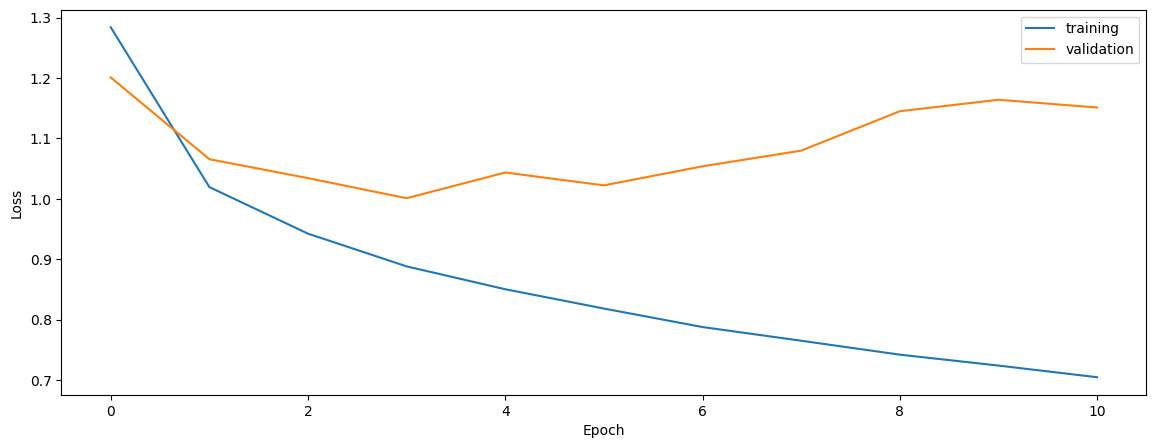

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6721165592757898
0.5974372681368508
0.6463152740260905


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6026258143364647
0.5884066845764855
0.5634050643151849


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6000840525004849
0.5956533513879485
0.5744937612789655


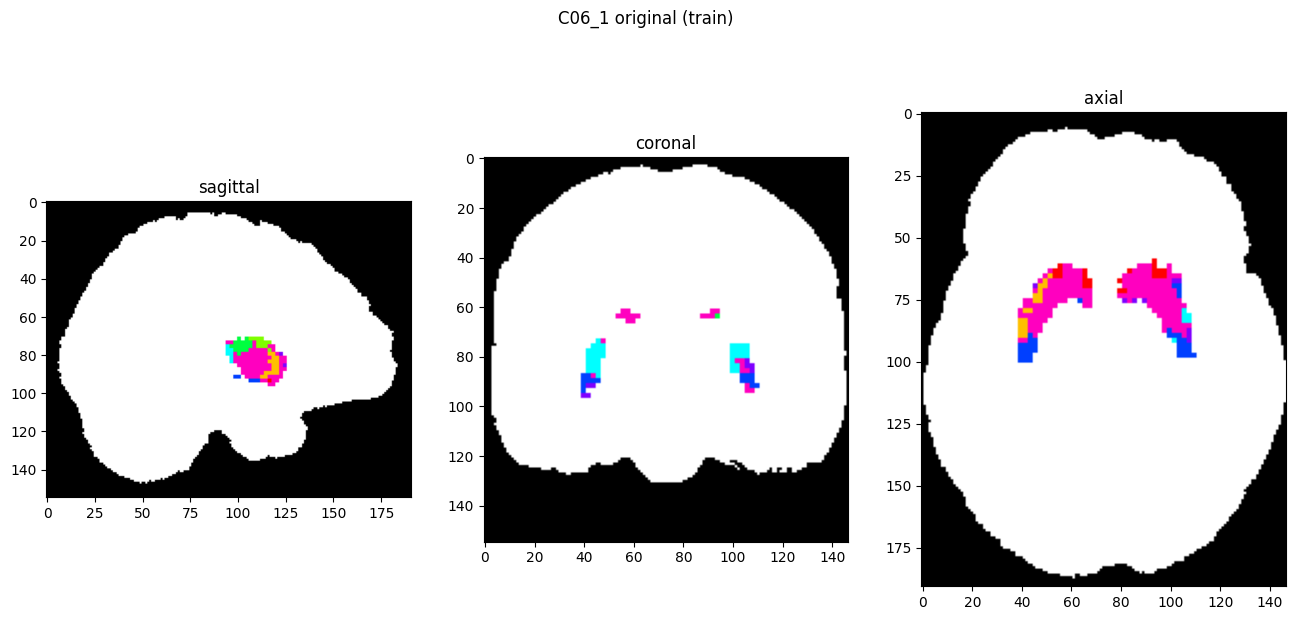

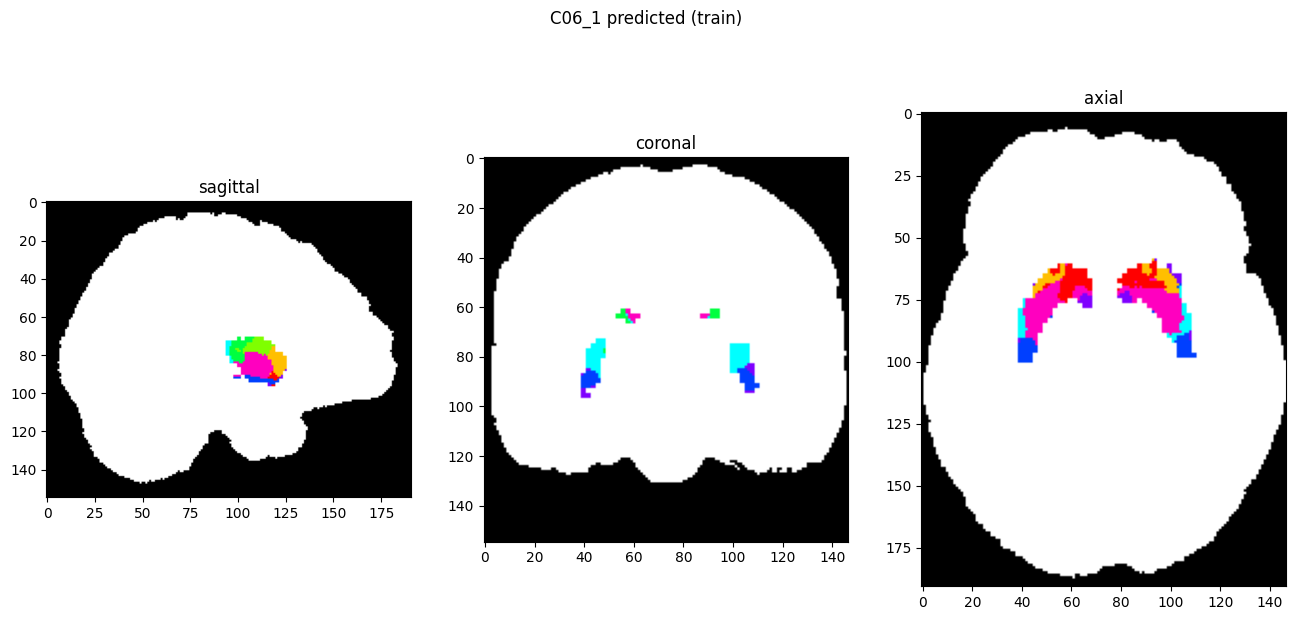

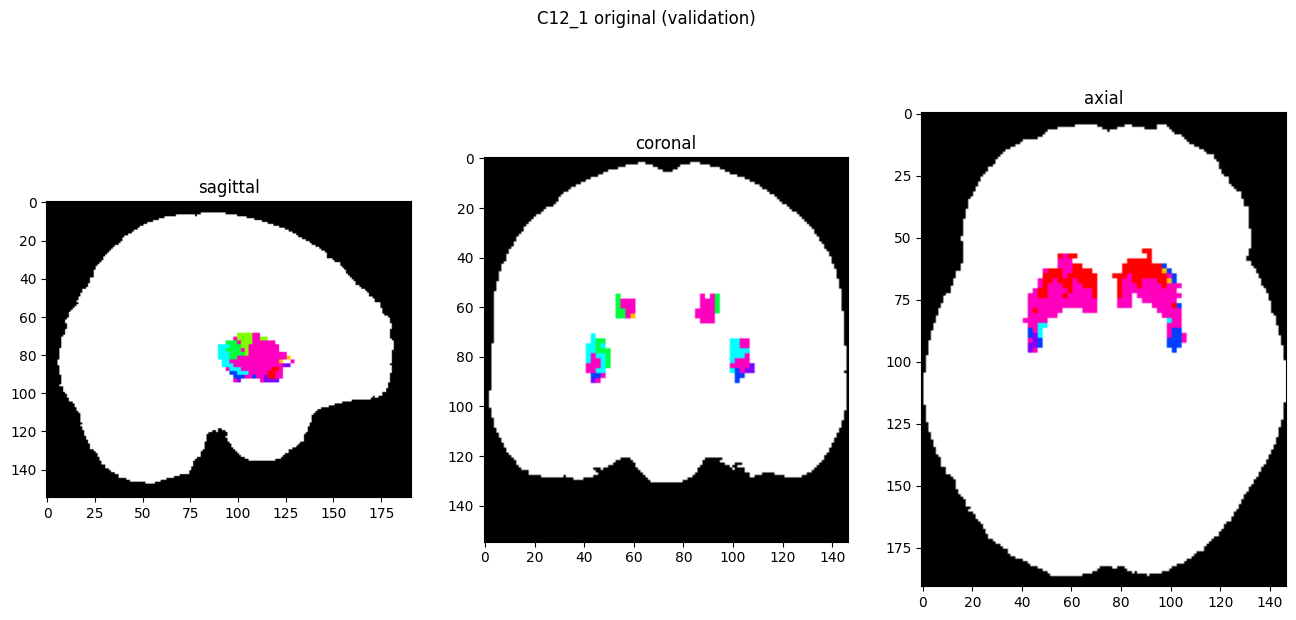

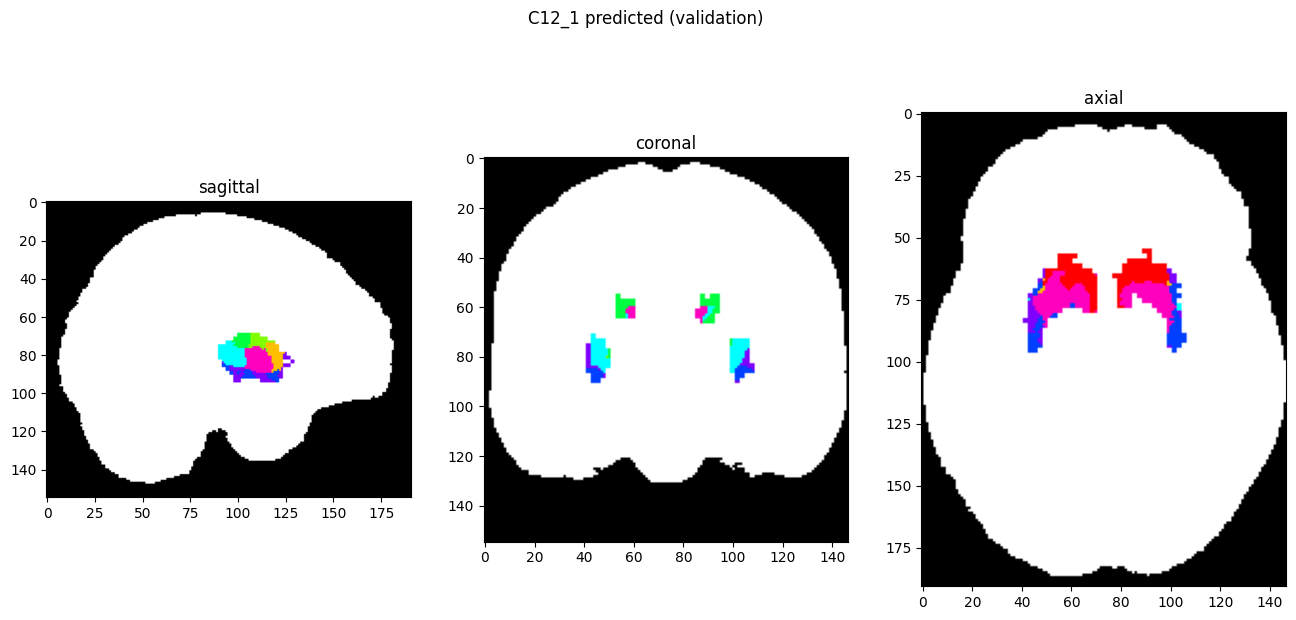

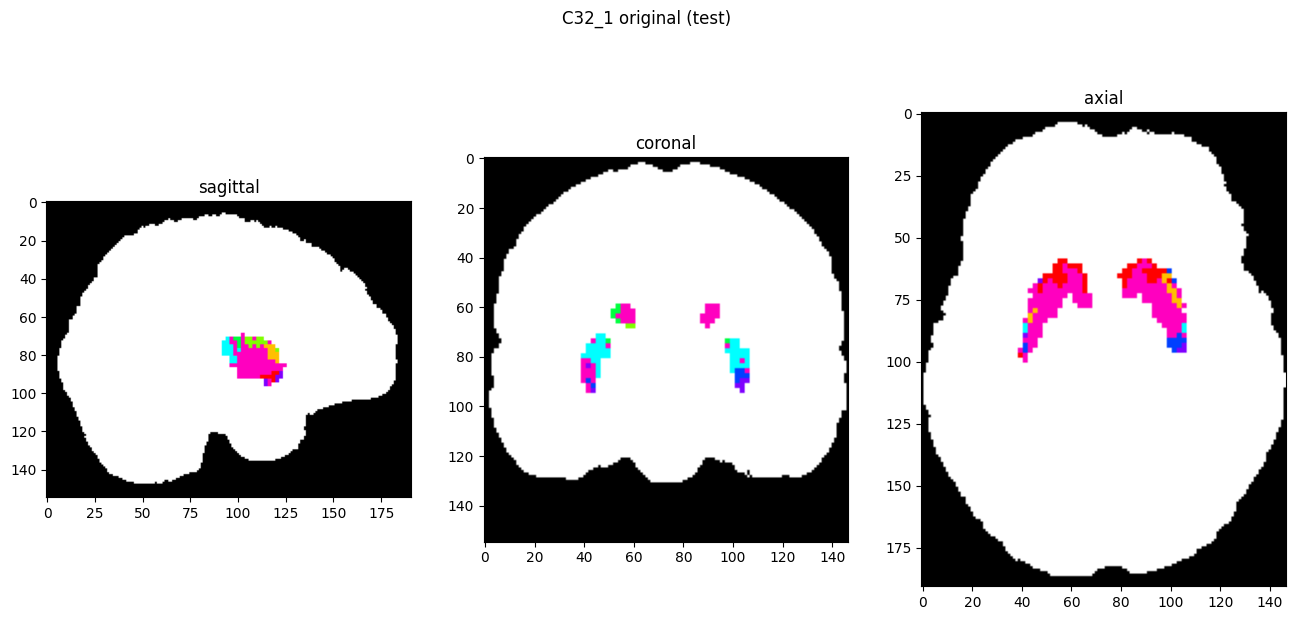

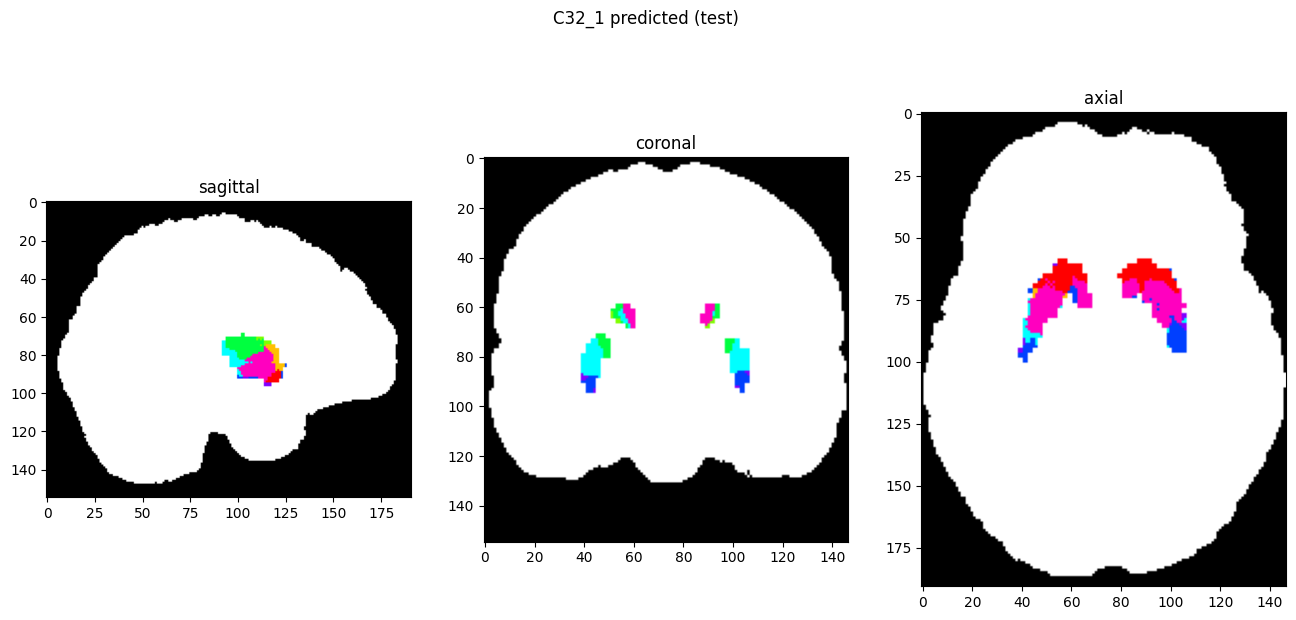

In [10]:
showResults(model, gen, threshold=0)